In [ ]:
#######包及库调用

####################

import numpy as np
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms
from tqdm import tqdm
import itertools
import random
import os
import re
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from numpy.fft import fft, fftshift, ifft
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.optimize import curve_fit
from numpy.fft import fft, fftshift, ifft
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import chirp
from scipy.optimize import curve_fit
from numpy.fft import fft, fftshift, ifft
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy.optimize import minimize
from matplotlib.colors import Normalize
import matplotlib.cm as cm

In [1]:
def generate_gaussian_pulse(amplitude, sigma, t):
    return amplitude * np.exp(-((t / sigma) ** 2) / 2)

In [ ]:
#######FIR及IIR表达式定义(拓扑基本元素定义)

# Function to compute FIR filter frequency response
# 有限冲击响应滤波器
def compute_h(omega, a, tau):
    H = np.zeros_like(omega, dtype=np.complex_)
    for n in range(len(a)):
        H += a[n] * np.exp(-1j * omega * tau[n])
    return H


def compute_h_iir_drop(omega, t, g, T):
    numerator = -(1 - t**2) * np.sqrt(np.abs(g)) * np.exp(-1j * omega * T / 2)
    denominator = 1 - t**2 * g * np.exp(-1j * omega * T)
    return numerator / denominator

# Function to compute IIR filter frequency response
def compute_h_iir_through(omega, t, g, T):
    numerator = t - g * np.exp(-1j * omega * T)
    denominator = 1 - g * t * np.exp(-1j * omega * T)
    return numerator / denominator

In [ ]:
# TODO: MZM
class MZM:
    def __init__(self , idx):
        self.idx = idx
        self.in_ports = [None, None]
        self.out_ports = [None, None]

def create_matrix(num_mzms, connections):
    """
    根据连接关系创建邻接矩阵
    参数:
        num_mzms: MZM数量
        connections: 连接列表，每个元素为 (src_mzm, src_port, tgt_mzm, tgt_port)

    返回:matrix: (2N)×(2N)的邻接矩阵
    """
    size = 2 * num_mzms  # 每个MZM有2个输出端口
    matrix = np.zeros((size, size), dtype=int)

    # 将连接映射到邻接矩阵
    for src_mzm, src_port, tgt_mzm, tgt_port in connections:
        # 输出端口编号: 2*src_mzm + src_port
        # 输入端口编号: 2*tgt_mzm + tgt_port
        out_idx = 2 * src_mzm + src_port
        in_idx = 2 * tgt_mzm + tgt_port
        matrix[out_idx, in_idx] = 1

    return matrix


In [2]:
#######拓扑识别算法

In [ ]:
import re

def parse_expression_with_numbers(expression):
    """
    解析已经带编号的表达式，识别其中的 FIR、IIR_drop 和 IIR_through 滤波器，并计算它们的编号的最大值。
    返回 FIR、IIR_drop 和 IIR_through 的最大编号值。
    """
    # 匹配带编号的 FIR、IIR_drop 和 IIR_through
    fir_filters = re.findall(r'FIR(\d+)', expression)  # 匹配 FIR 后的数字
    iir_drop_filters = re.findall(r'IIR_drop(\d+)', expression)  # 匹配 IIR_drop 后的数字
    iir_through_filters = re.findall(r'IIR_through(\d+)', expression)  # 匹配 IIR_through 后的数字

    # 将字符串编号转换为整数
    fir_filters = [int(fir) for fir in fir_filters]
    iir_drop_filters = [int(iir_drop) for iir_drop in iir_drop_filters]
    iir_through_filters = [int(iir_through) for iir_through in iir_through_filters]

    # 返回 FIR、IIR_drop 和 IIR_through 的最大编号值
    return max(fir_filters, default=0), max(iir_drop_filters, default=0), max(iir_through_filters, default=0)

def process_expression(expression):
    """
    处理带编号的滤波器表达式，提取 FIR、IIR_drop 和 IIR_through 滤波器，计算它们的最大编号，并返回。
    """
    # 解析表达式，提取 FIR、IIR_drop 和 IIR_through 滤波器的最大编号
    max_fir, max_iir_drop, max_iir_through = parse_expression_with_numbers(expression)

    fir_filters = np.ones(max_fir)
    iir_drop_filters = np.ones(max_iir_drop)
    iir_through_filters = np.ones(max_iir_through)
    numbered_expression = expression

    # 返回 FIR、IIR_drop 和 IIR_through 滤波器的最大编号值
    return fir_filters, iir_drop_filters, iir_through_filters, numbered_expression



In [4]:
######滤波器表达式赋值
def compute_expression_array(expression, filter_values):
    """
    逐点计算表达式，支持数组运算。
    expression: 带编号的表达式。
    filter_values: 字典，键为滤波器编号，值为对应的数组。
    """
    # 替换编号为数组形式的表达式
    for filter_name, value_array in filter_values.items():
        expression = expression.replace(filter_name, f"filter_values['{filter_name}']")

    # 利用 eval 和 numpy 逐点计算
    result_array = eval(expression)  # 安全场景下使用 eval
    return result_array

In [6]:
#######滤波器参数优化主程序(GA+L-BFGS)

####################

def fir_filter_design_with_GA_L_BFGS(a, b, c, H_w, omega, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, M_min, M_max, Gn, Ne, cxpb, mutpb, numbered_expression):
    # Start the timer
    start_time = time.time()
    # Initialize optimal parameters
    best_cost = np.inf
    best_params = None
    best_response = None

    # Loop to calculate different filter configurations

    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            for N9 in range(M_min, M_max):
                                                for N10 in range(M_min, M_max):
                                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                                    best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9, \
                                                    best_a10, best_tau10, \
                                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9, N10], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                                    # Optimize coefficients and delays using L-BFGS
                                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9, best_a10, best_tau10])

                                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9, N10], numbered_expression),
                                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                                    current_best_cost = res.fun[0]
                                                    current_best_params_0 = res.x

                                                    # Update optimal values
                                                    if current_best_cost < best_cost:
                                                        best_cost = current_best_cost
                                                        best_params = current_best_params_0
                                                        N_total = [N1, N2, N3, N4, N5, N6, N7, N8, N9, N10]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]
            N10 = N_total[9]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimized Coefficients for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
            print('Optimal Delays tau for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            print('Optimized Coefficients for FIR10')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9):2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10])
            print('Optimal Delays tau for FIR10:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9+N10)])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9):2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9+N10)]))

            pass

        elif len(fir_filters) == 9:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            for N9 in range(M_min, M_max):
                                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                                best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                                best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9, \
                                                best_t1, best_g1, best_T1, \
                                                current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                                # Optimize coefficients and delays using L-BFGS
                                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9], numbered_expression),
                                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                                current_best_cost = res.fun[0]
                                                current_best_params_0 = res.x

                                                # Update optimal values
                                                if current_best_cost < best_cost:
                                                    best_cost = current_best_cost
                                                    best_params = current_best_params_0
                                                    N_total = [N1, N2, N3, N4, N5, N6, N7, N8, N9]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimized Coefficients for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
            print('Optimal Delays tau for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+2]))

            pass

        elif len(fir_filters) == 8:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                            best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                            best_a7, best_tau7, best_a8, best_tau8, \
                                            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                            # Optimize coefficients and delays using L-BFGS
                                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], numbered_expression),
                                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                            current_best_cost = res.fun[0]
                                            current_best_params_0 = res.x

                                            # Update optimal values
                                            if current_best_cost < best_cost:
                                                best_cost = current_best_cost
                                                best_params = current_best_params_0
                                                N_total = [N1, N2, N3, N4, N5, N6, N7, N8]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+5]))

            pass

        elif len(fir_filters) == 7:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                        best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                        best_a7, best_tau7, \
                                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
                                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                        # Optimize coefficients and delays using L-BFGS
                                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7], numbered_expression),
                                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                        current_best_cost = res.fun[0]
                                        current_best_params_0 = res.x

                                        # Update optimal values
                                        if current_best_cost < best_cost:
                                            best_cost = current_best_cost
                                            best_params = current_best_params_0
                                            N_total = [N1, N2, N3, N4, N5, N6, N7]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+8]))

            pass

        elif len(fir_filters) == 6:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                    # Optimize coefficients and delays using L-BFGS
                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6], numbered_expression),
                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                    current_best_cost = res.fun[0]
                                    current_best_params_0 = res.x

                                    # Update optimal values
                                    if current_best_cost < best_cost:
                                        best_cost = current_best_cost
                                        best_params = current_best_params_0
                                        N_total = [N1, N2, N3, N4, N5, N6]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+9]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+10]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+11]))

            pass

        elif len(fir_filters) == 5:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, \
                                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                                best_t5, best_g5, best_T5, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4+N5)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3+N4+N5)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3+N4+N5)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3+N4+N5)+14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5)+8]), np.array(best_params[2*(N1+N2+N3+N4+N5)+9]), np.array(best_params[2*(N1+N2+N3+N4+N5)+10]), np.array(best_params[2*(N1+N2+N3+N4+N5)+11]), np.array(best_params[2*(N1+N2+N3+N4+N5)+12]), np.array(best_params[2*(N1+N2+N3+N4+N5)+13]), np.array(best_params[2*(N1+N2+N3+N4+N5)+14]))

            pass

        elif len(fir_filters) == 4:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, \
                            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                            best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3+N4)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3+N4)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3+N4)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2+N3+N4)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2+N3+N4)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2+N3+N4)+17])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)+1]), np.array(best_params[2*(N1+N2+N3+N4)+2]), np.array(best_params[2*(N1+N2+N3+N4)+3]), np.array(best_params[2*(N1+N2+N3+N4)+4]), np.array(best_params[2*(N1+N2+N3+N4)+5]), np.array(best_params[2*(N1+N2+N3+N4)+6]), np.array(best_params[2*(N1+N2+N3+N4)+7]), np.array(best_params[2*(N1+N2+N3+N4)+8]), np.array(best_params[2*(N1+N2+N3+N4)+9]), np.array(best_params[2*(N1+N2+N3+N4)+10]), np.array(best_params[2*(N1+N2+N3+N4)+11]), np.array(best_params[2*(N1+N2+N3+N4)+12]), np.array(best_params[2*(N1+N2+N3+N4)+13]), np.array(best_params[2*(N1+N2+N3+N4)+14]), np.array(best_params[2*(N1+N2+N3+N4)+15]), np.array(best_params[2*(N1+N2+N3+N4)+16]), np.array(best_params[2*(N1+N2+N3+N4)+17]))

            pass

        elif len(fir_filters) == 3:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                        best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2+N3)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2+N3)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2+N3)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1+N2+N3)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1+N2+N3)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1+N2+N3)+20])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)+1]), np.array(best_params[2*(N1+N2+N3)+2]), np.array(best_params[2*(N1+N2+N3)+3]), np.array(best_params[2*(N1+N2+N3)+4]), np.array(best_params[2*(N1+N2+N3)+5]), np.array(best_params[2*(N1+N2+N3)+6]), np.array(best_params[2*(N1+N2+N3)+7]), np.array(best_params[2*(N1+N2+N3)+8]), np.array(best_params[2*(N1+N2+N3)+9]), np.array(best_params[2*(N1+N2+N3)+10]), np.array(best_params[2*(N1+N2+N3)+11]), np.array(best_params[2*(N1+N2+N3)+12]), np.array(best_params[2*(N1+N2+N3)+13]), np.array(best_params[2*(N1+N2+N3)+14]), np.array(best_params[2*(N1+N2+N3)+15]), np.array(best_params[2*(N1+N2+N3)+16]), np.array(best_params[2*(N1+N2+N3)+17]), np.array(best_params[2*(N1+N2+N3)+18]), np.array(best_params[2*(N1+N2+N3)+19]), np.array(best_params[2*(N1+N2+N3)+20]))

            pass

        elif len(fir_filters) == 2:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2, \
                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                    best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1+N2)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1+N2)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1+N2)+20])
            print('Optimized t for IIR8')
            print(best_params[2*(N1+N2)+21])
            print('Optimal g for IIR8:')
            print(best_params[2*(N1+N2)+22])
            print('Optimal T for IIR8:')
            print(best_params[2*(N1+N2)+23])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2)]), np.array(best_params[2*(N1+N2)+1]), np.array(best_params[2*(N1+N2)+2]), np.array(best_params[2*(N1+N2)+3]), np.array(best_params[2*(N1+N2)+4]), np.array(best_params[2*(N1+N2)+5]), np.array(best_params[2*(N1+N2)+6]), np.array(best_params[2*(N1+N2)+7]), np.array(best_params[2*(N1+N2)+8]), np.array(best_params[2*(N1+N2)+9]), np.array(best_params[2*(N1+N2)+10]), np.array(best_params[2*(N1+N2)+11]), np.array(best_params[2*(N1+N2)+12]), np.array(best_params[2*(N1+N2)+13]), np.array(best_params[2*(N1+N2)+14]), np.array(best_params[2*(N1+N2)+15]), np.array(best_params[2*(N1+N2)+16]), np.array(best_params[2*(N1+N2)+17]), np.array(best_params[2*(N1+N2)+18]), np.array(best_params[2*(N1+N2)+19]), np.array(best_params[2*(N1+N2)+20]), np.array(best_params[2*(N1+N2)+21]), np.array(best_params[2*(N1+N2)+22]), np.array(best_params[2*(N1+N2)+23]))

            pass

        elif len(fir_filters) == 1:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, \
                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, best_t9, best_g9, best_T9, current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8]), np.array([best_t9]), np.array([best_g9]), np.array([best_T9])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1)+20])
            print('Optimized t for IIR8')
            print(best_params[2*(N1)+21])
            print('Optimal g for IIR8:')
            print(best_params[2*(N1)+22])
            print('Optimal T for IIR8:')
            print(best_params[2*(N1)+23])
            print('Optimized t for IIR9')
            print(best_params[2*(N1)+24])
            print('Optimal g for IIR9:')
            print(best_params[2*(N1)+25])
            print('Optimal T for IIR9:')
            print(best_params[2*(N1)+26])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1)]), np.array(best_params[2*(N1)+1]), np.array(best_params[2*(N1)+2]), np.array(best_params[2*(N1)+3]), np.array(best_params[2*(N1)+4]), np.array(best_params[2*(N1)+5]), np.array(best_params[2*(N1)+6]), np.array(best_params[2*(N1)+7]), np.array(best_params[2*(N1)+8]), np.array(best_params[2*(N1)+9]), np.array(best_params[2*(N1)+10]), np.array(best_params[2*(N1)+11]), np.array(best_params[2*(N1)+12]), np.array(best_params[2*(N1)+13]), np.array(best_params[2*(N1)+14]), np.array(best_params[2*(N1)+15]), np.array(best_params[2*(N1)+16]), np.array(best_params[2*(N1)+17]), np.array(best_params[2*(N1)+18]), np.array(best_params[2*(N1)+19]), np.array(best_params[2*(N1)+20]), np.array(best_params[2*(N1)+21]), np.array(best_params[2*(N1)+22]), np.array(best_params[2*(N1)+23]), np.array(best_params[2*(N1)+24]), np.array(best_params[2*(N1)+25]), np.array(best_params[2*(N1)+26]))

            pass

        else:  # 这里替换为你想要的条件
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
            best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, best_t9, best_g9, best_T9, best_t10, best_g10, best_T10, current_best_cost = genetic_algorithm_composite(a, b, c, [0], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8]), np.array([best_t9]), np.array([best_g9]), np.array([best_T9]), np.array([best_t10]), np.array([best_g10]), np.array([best_T10])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimal T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimal T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimal T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimal T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimal T for IIR5:')
            print(best_params[14])
            print('Optimized t for IIR6')
            print(best_params[15])
            print('Optimal g for IIR6:')
            print(best_params[16])
            print('Optimal T for IIR6:')
            print(best_params[17])
            print('Optimized t for IIR7')
            print(best_params[18])
            print('Optimal g for IIR7:')
            print(best_params[19])
            print('Optimal T for IIR7:')
            print(best_params[20])
            print('Optimized t for IIR8')
            print(best_params[21])
            print('Optimal g for IIR8:')
            print(best_params[22])
            print('Optimal T for IIR8:')
            print(best_params[23])
            print('Optimized t for IIR9')
            print(best_params[24])
            print('Optimal g for IIR9:')
            print(best_params[25])
            print('Optimal T for IIR9:')
            print(best_params[26])
            print('Optimized t for IIR10')
            print(best_params[27])
            print('Optimal g for IIR10:')
            print(best_params[28])
            print('Optimal T for IIR10:')
            print(best_params[29])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[0]), np.array(best_params[1]), np.array(best_params[2]), np.array(best_params[3]), np.array(best_params[4]), np.array(best_params[5]), np.array(best_params[6]), np.array(best_params[7]), np.array(best_params[8]), np.array(best_params[9]), np.array(best_params[10]), np.array(best_params[11]), np.array(best_params[12]), np.array(best_params[13]), np.array(best_params[14]), np.array(best_params[15]), np.array(best_params[16]), np.array(best_params[17]), np.array(best_params[18]), np.array(best_params[19]), np.array(best_params[20]), np.array(best_params[21]), np.array(best_params[22]), np.array(best_params[23]), np.array(best_params[24]), np.array(best_params[25]), np.array(best_params[26]), np.array(best_params[27]), np.array(best_params[28]), np.array(best_params[29]))

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            for N9 in range(M_min, M_max):
                                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                                best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                                best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9, \
                                                current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                                # Optimize coefficients and delays using L-BFGS
                                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8, best_a9, best_tau9])

                                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8, N9], numbered_expression),
                                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                                current_best_cost = res.fun[0]
                                                current_best_params_0 = res.x

                                                # Update optimal values
                                                if current_best_cost < best_cost:
                                                    best_cost = current_best_cost
                                                    best_params = current_best_params_0
                                                    N_total = [N1, N2, N3, N4, N5, N6, N7, N8, N9]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimized Coefficients for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
            print('Optimal Delays tau for FIR9:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]))

            pass

        elif len(fir_filters) == 8:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                            best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                            best_a7, best_tau7, best_a8, best_tau8, \
                                            best_t1, best_g1, best_T1, \
                                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                            # Optimize coefficients and delays using L-BFGS
                                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], numbered_expression),
                                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                            current_best_cost = res.fun[0]
                                            current_best_params_0 = res.x

                                            # Update optimal values
                                            if current_best_cost < best_cost:
                                                best_cost = current_best_cost
                                                best_params = current_best_params_0
                                                N_total = [N1, N2, N3, N4, N5, N6, N7, N8]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]))

            pass

        elif len(fir_filters) == 7:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                        best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                        best_a7, best_tau7, \
                                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                        # Optimize coefficients and delays using L-BFGS
                                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7], numbered_expression),
                                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                        current_best_cost = res.fun[0]
                                        current_best_params_0 = res.x

                                        # Update optimal values
                                        if current_best_cost < best_cost:
                                            best_cost = current_best_cost
                                            best_params = current_best_params_0
                                            N_total = [N1, N2, N3, N4, N5, N6, N7]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+5]))

            pass

        elif len(fir_filters) == 6:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                    # Optimize coefficients and delays using L-BFGS
                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6], numbered_expression),
                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                    current_best_cost = res.fun[0]
                                    current_best_params_0 = res.x

                                    # Update optimal values
                                    if current_best_cost < best_cost:
                                        best_cost = current_best_cost
                                        best_params = current_best_params_0
                                        N_total = [N1, N2, N3, N4, N5, N6]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+8]))

            pass

        elif len(fir_filters) == 5:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, \
                                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4+N5)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4+N5)+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5)+8]), np.array(best_params[2*(N1+N2+N3+N4+N5)+9]), np.array(best_params[2*(N1+N2+N3+N4+N5)+10]), np.array(best_params[2*(N1+N2+N3+N4+N5)+11]))

            pass

        elif len(fir_filters) == 4:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, \
                            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                            best_t5, best_g5, best_T5, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3+N4)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3+N4)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3+N4)+14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)+1]), np.array(best_params[2*(N1+N2+N3+N4)+2]), np.array(best_params[2*(N1+N2+N3+N4)+3]), np.array(best_params[2*(N1+N2+N3+N4)+4]), np.array(best_params[2*(N1+N2+N3+N4)+5]), np.array(best_params[2*(N1+N2+N3+N4)+6]), np.array(best_params[2*(N1+N2+N3+N4)+7]), np.array(best_params[2*(N1+N2+N3+N4)+8]), np.array(best_params[2*(N1+N2+N3+N4)+9]), np.array(best_params[2*(N1+N2+N3+N4)+10]), np.array(best_params[2*(N1+N2+N3+N4)+11]), np.array(best_params[2*(N1+N2+N3+N4)+12]), np.array(best_params[2*(N1+N2+N3+N4)+13]), np.array(best_params[2*(N1+N2+N3+N4)+14]))

            pass

        elif len(fir_filters) == 3:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                        best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2+N3)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2+N3)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2+N3)+17])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)+1]), np.array(best_params[2*(N1+N2+N3)+2]), np.array(best_params[2*(N1+N2+N3)+3]), np.array(best_params[2*(N1+N2+N3)+4]), np.array(best_params[2*(N1+N2+N3)+5]), np.array(best_params[2*(N1+N2+N3)+6]), np.array(best_params[2*(N1+N2+N3)+7]), np.array(best_params[2*(N1+N2+N3)+8]), np.array(best_params[2*(N1+N2+N3)+9]), np.array(best_params[2*(N1+N2+N3)+10]), np.array(best_params[2*(N1+N2+N3)+11]), np.array(best_params[2*(N1+N2+N3)+12]), np.array(best_params[2*(N1+N2+N3)+13]), np.array(best_params[2*(N1+N2+N3)+14]), np.array(best_params[2*(N1+N2+N3)+15]), np.array(best_params[2*(N1+N2+N3)+16]), np.array(best_params[2*(N1+N2+N3)+17]))

            pass

        elif len(fir_filters) == 2:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2, \
                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                    best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1+N2)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1+N2)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1+N2)+20])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2)]), np.array(best_params[2*(N1+N2)+1]), np.array(best_params[2*(N1+N2)+2]), np.array(best_params[2*(N1+N2)+3]), np.array(best_params[2*(N1+N2)+4]), np.array(best_params[2*(N1+N2)+5]), np.array(best_params[2*(N1+N2)+6]), np.array(best_params[2*(N1+N2)+7]), np.array(best_params[2*(N1+N2)+8]), np.array(best_params[2*(N1+N2)+9]), np.array(best_params[2*(N1+N2)+10]), np.array(best_params[2*(N1+N2)+11]), np.array(best_params[2*(N1+N2)+12]), np.array(best_params[2*(N1+N2)+13]), np.array(best_params[2*(N1+N2)+14]), np.array(best_params[2*(N1+N2)+15]), np.array(best_params[2*(N1+N2)+16]), np.array(best_params[2*(N1+N2)+17]), np.array(best_params[2*(N1+N2)+18]), np.array(best_params[2*(N1+N2)+19]), np.array(best_params[2*(N1+N2)+20]))

            pass

        elif len(fir_filters) == 1:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, \
                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1)+20])
            print('Optimized t for IIR8')
            print(best_params[2*(N1)+21])
            print('Optimal g for IIR8:')
            print(best_params[2*(N1)+22])
            print('Optimal T for IIR8:')
            print(best_params[2*(N1)+23])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1)]), np.array(best_params[2*(N1)+1]), np.array(best_params[2*(N1)+2]), np.array(best_params[2*(N1)+3]), np.array(best_params[2*(N1)+4]), np.array(best_params[2*(N1)+5]), np.array(best_params[2*(N1)+6]), np.array(best_params[2*(N1)+7]), np.array(best_params[2*(N1)+8]), np.array(best_params[2*(N1)+9]), np.array(best_params[2*(N1)+10]), np.array(best_params[2*(N1)+11]), np.array(best_params[2*(N1)+12]), np.array(best_params[2*(N1)+13]), np.array(best_params[2*(N1)+14]), np.array(best_params[2*(N1)+15]), np.array(best_params[2*(N1)+16]), np.array(best_params[2*(N1)+17]), np.array(best_params[2*(N1)+18]), np.array(best_params[2*(N1)+19]), np.array(best_params[2*(N1)+20]), np.array(best_params[2*(N1)+21]), np.array(best_params[2*(N1)+22]), np.array(best_params[2*(N1)+23]))

            pass

        else:  # 这里替换为你想要的条件
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
            best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, best_t9, best_g9, best_T9, current_best_cost = genetic_algorithm_composite(a, b, c, [0], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8]), np.array([best_t9]), np.array([best_g9]), np.array([best_T9])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimal T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimal T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimal T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimal T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimal T for IIR5:')
            print(best_params[14])
            print('Optimized t for IIR6')
            print(best_params[15])
            print('Optimal g for IIR6:')
            print(best_params[16])
            print('Optimal T for IIR6:')
            print(best_params[17])
            print('Optimized t for IIR7')
            print(best_params[18])
            print('Optimal g for IIR7:')
            print(best_params[19])
            print('Optimal T for IIR7:')
            print(best_params[20])
            print('Optimized t for IIR8')
            print(best_params[21])
            print('Optimal g for IIR8:')
            print(best_params[22])
            print('Optimal T for IIR8:')
            print(best_params[23])
            print('Optimized t for IIR9')
            print(best_params[24])
            print('Optimal g for IIR9:')
            print(best_params[25])
            print('Optimal T for IIR9:')
            print(best_params[26])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[0]), np.array(best_params[1]), np.array(best_params[2]), np.array(best_params[3]), np.array(best_params[4]), np.array(best_params[5]), np.array(best_params[6]), np.array(best_params[7]), np.array(best_params[8]), np.array(best_params[9]), np.array(best_params[10]), np.array(best_params[11]), np.array(best_params[12]), np.array(best_params[13]), np.array(best_params[14]), np.array(best_params[15]), np.array(best_params[16]), np.array(best_params[17]), np.array(best_params[18]), np.array(best_params[19]), np.array(best_params[20]), np.array(best_params[21]), np.array(best_params[22]), np.array(best_params[23]), np.array(best_params[24]), np.array(best_params[25]), np.array(best_params[26]))

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        for N8 in range(M_min, M_max):
                                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                            best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                            best_a7, best_tau7, best_a8, best_tau8, \
                                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                            # Optimize coefficients and delays using L-BFGS
                                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, best_a8, best_tau8])

                                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7, N8], numbered_expression),
                                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                            current_best_cost = res.fun[0]
                                            current_best_params_0 = res.x

                                            # Update optimal values
                                            if current_best_cost < best_cost:
                                                best_cost = current_best_cost
                                                best_params = current_best_params_0
                                                N_total = [N1, N2, N3, N4, N5, N6, N7, N8]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized Coefficients for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            print('Optimal Delays tau for FIR8:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)]))

            pass

        elif len(fir_filters) == 7:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                        best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                        best_a7, best_tau7, \
                                        best_t1, best_g1, best_T1, \
                                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                        # Optimize coefficients and delays using L-BFGS
                                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7], numbered_expression),
                                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                        current_best_cost = res.fun[0]
                                        current_best_params_0 = res.x

                                        # Update optimal values
                                        if current_best_cost < best_cost:
                                            best_cost = current_best_cost
                                            best_params = current_best_params_0
                                            N_total = [N1, N2, N3, N4, N5, N6, N7]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6+N7)+2]))

            pass

        elif len(fir_filters) == 6:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                    # Optimize coefficients and delays using L-BFGS
                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6], numbered_expression),
                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                    current_best_cost = res.fun[0]
                                    current_best_params_0 = res.x

                                    # Update optimal values
                                    if current_best_cost < best_cost:
                                        best_cost = current_best_cost
                                        best_params = current_best_params_0
                                        N_total = [N1, N2, N3, N4, N5, N6]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+5]))

            pass

        elif len(fir_filters) == 5:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, \
                                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4+N5)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4+N5)+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5)+5]), np.array(best_params[2*(N1+N2+N3+N4+N5)+6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+7]), np.array(best_params[2*(N1+N2+N3+N4+N5)+8]))

            pass

        elif len(fir_filters) == 4:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, \
                            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3+N4)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3+N4)+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)+1]), np.array(best_params[2*(N1+N2+N3+N4)+2]), np.array(best_params[2*(N1+N2+N3+N4)+3]), np.array(best_params[2*(N1+N2+N3+N4)+4]), np.array(best_params[2*(N1+N2+N3+N4)+5]), np.array(best_params[2*(N1+N2+N3+N4)+6]), np.array(best_params[2*(N1+N2+N3+N4)+7]), np.array(best_params[2*(N1+N2+N3+N4)+8]), np.array(best_params[2*(N1+N2+N3+N4)+9]), np.array(best_params[2*(N1+N2+N3+N4)+10]), np.array(best_params[2*(N1+N2+N3+N4)+11]))

            pass

        elif len(fir_filters) == 3:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                        best_t5, best_g5, best_T5, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2+N3)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2+N3)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2+N3)+14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)+1]), np.array(best_params[2*(N1+N2+N3)+2]), np.array(best_params[2*(N1+N2+N3)+3]), np.array(best_params[2*(N1+N2+N3)+4]), np.array(best_params[2*(N1+N2+N3)+5]), np.array(best_params[2*(N1+N2+N3)+6]), np.array(best_params[2*(N1+N2+N3)+7]), np.array(best_params[2*(N1+N2+N3)+8]), np.array(best_params[2*(N1+N2+N3)+9]), np.array(best_params[2*(N1+N2+N3)+10]), np.array(best_params[2*(N1+N2+N3)+11]), np.array(best_params[2*(N1+N2+N3)+12]), np.array(best_params[2*(N1+N2+N3)+13]), np.array(best_params[2*(N1+N2+N3)+14]))

            pass

        elif len(fir_filters) == 2:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2, \
                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                    best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1+N2)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1+N2)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1+N2)+17])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2)]), np.array(best_params[2*(N1+N2)+1]), np.array(best_params[2*(N1+N2)+2]), np.array(best_params[2*(N1+N2)+3]), np.array(best_params[2*(N1+N2)+4]), np.array(best_params[2*(N1+N2)+5]), np.array(best_params[2*(N1+N2)+6]), np.array(best_params[2*(N1+N2)+7]), np.array(best_params[2*(N1+N2)+8]), np.array(best_params[2*(N1+N2)+9]), np.array(best_params[2*(N1+N2)+10]), np.array(best_params[2*(N1+N2)+11]), np.array(best_params[2*(N1+N2)+12]), np.array(best_params[2*(N1+N2)+13]), np.array(best_params[2*(N1+N2)+14]), np.array(best_params[2*(N1+N2)+15]), np.array(best_params[2*(N1+N2)+16]), np.array(best_params[2*(N1+N2)+17]))

            pass

        elif len(fir_filters) == 1:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, \
                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1)+17])
            print('Optimized t for IIR7')
            print(best_params[2*(N1)+18])
            print('Optimal g for IIR7:')
            print(best_params[2*(N1)+19])
            print('Optimal T for IIR7:')
            print(best_params[2*(N1)+20])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1)]), np.array(best_params[2*(N1)+1]), np.array(best_params[2*(N1)+2]), np.array(best_params[2*(N1)+3]), np.array(best_params[2*(N1)+4]), np.array(best_params[2*(N1)+5]), np.array(best_params[2*(N1)+6]), np.array(best_params[2*(N1)+7]), np.array(best_params[2*(N1)+8]), np.array(best_params[2*(N1)+9]), np.array(best_params[2*(N1)+10]), np.array(best_params[2*(N1)+11]), np.array(best_params[2*(N1)+12]), np.array(best_params[2*(N1)+13]), np.array(best_params[2*(N1)+14]), np.array(best_params[2*(N1)+15]), np.array(best_params[2*(N1)+16]), np.array(best_params[2*(N1)+17]), np.array(best_params[2*(N1)+18]), np.array(best_params[2*(N1)+19]), np.array(best_params[2*(N1)+20]))

            pass

        else:  # 这里替换为你想要的条件
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
            best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, best_t8, best_g8, best_T8, current_best_cost = genetic_algorithm_composite(a, b, c, [0], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7]), np.array([best_t8]), np.array([best_g8]), np.array([best_T8])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimal T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimal T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimal T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimal T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimal T for IIR5:')
            print(best_params[14])
            print('Optimized t for IIR6')
            print(best_params[15])
            print('Optimal g for IIR6:')
            print(best_params[16])
            print('Optimal T for IIR6:')
            print(best_params[17])
            print('Optimized t for IIR7')
            print(best_params[18])
            print('Optimal g for IIR7:')
            print(best_params[19])
            print('Optimal T for IIR7:')
            print(best_params[20])
            print('Optimized t for IIR8')
            print(best_params[21])
            print('Optimal g for IIR8:')
            print(best_params[22])
            print('Optimal T for IIR8:')
            print(best_params[23])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[0]), np.array(best_params[1]), np.array(best_params[2]), np.array(best_params[3]), np.array(best_params[4]), np.array(best_params[5]), np.array(best_params[6]), np.array(best_params[7]), np.array(best_params[8]), np.array(best_params[9]), np.array(best_params[10]), np.array(best_params[11]), np.array(best_params[12]), np.array(best_params[13]), np.array(best_params[14]), np.array(best_params[15]), np.array(best_params[16]), np.array(best_params[17]), np.array(best_params[18]), np.array(best_params[19]), np.array(best_params[20]), np.array(best_params[21]), np.array(best_params[22]), np.array(best_params[23]))

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    for N7 in range(M_min, M_max):
                                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                        best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                        best_a7, best_tau7, \
                                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6, N7], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                        # Optimize coefficients and delays using L-BFGS
                                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, best_a7, best_tau7])

                                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6, N7], numbered_expression),
                                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                        current_best_cost = res.fun[0]
                                        current_best_params_0 = res.x

                                        # Update optimal values
                                        if current_best_cost < best_cost:
                                            best_cost = current_best_cost
                                            best_params = current_best_params_0
                                            N_total = [N1, N2, N3, N4, N5, N6, N7]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized Coefficients for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            print('Optimal Delays tau for FIR7:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)]))

            pass

        elif len(fir_filters) == 6:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                    best_t1, best_g1, best_T1, \
                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                    # Optimize coefficients and delays using L-BFGS
                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6], numbered_expression),
                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                    current_best_cost = res.fun[0]
                                    current_best_params_0 = res.x

                                    # Update optimal values
                                    if current_best_cost < best_cost:
                                        best_cost = current_best_cost
                                        best_params = current_best_params_0
                                        N_total = [N1, N2, N3, N4, N5, N6]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized Coefficients for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5+N6)+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6]), np.array(best_params[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5+N6)+2]))

            pass

        elif len(fir_filters) == 5:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, \
                                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized Coefficients for FIR5:')
            print(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4+N5)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4+N5)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4+N5)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4+N5)+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5]), np.array(best_params[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)]), np.array(best_params[2*(N1+N2+N3+N4+N5)+1]), np.array(best_params[2*(N1+N2+N3+N4+N5)+2]), np.array(best_params[2*(N1+N2+N3+N4+N5)+3]), np.array(best_params[2*(N1+N2+N3+N4+N5)+4]), np.array(best_params[2*(N1+N2+N3+N4+N5)+5]))

            pass

        elif len(fir_filters) == 4:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, \
                            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized Coefficients for FIR4:')
            print(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3+N4)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3+N4)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3+N4)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3+N4)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3+N4)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3+N4)+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3):2*(N1+N2+N3)+N4]), np.array(best_params[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)]), np.array(best_params[2*(N1+N2+N3+N4)+1]), np.array(best_params[2*(N1+N2+N3+N4)+2]), np.array(best_params[2*(N1+N2+N3+N4)+3]), np.array(best_params[2*(N1+N2+N3+N4)+4]), np.array(best_params[2*(N1+N2+N3+N4)+5]), np.array(best_params[2*(N1+N2+N3+N4)+6]), np.array(best_params[2*(N1+N2+N3+N4)+7]), np.array(best_params[2*(N1+N2+N3+N4)+8]))

            pass

        elif len(fir_filters) == 3:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized Coefficients for FIR3:')
            print(best_params[2*(N1+N2):2*(N1+N2)+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2+N3)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2+N3)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2+N3)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2+N3)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2+N3)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2+N3)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2+N3)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2+N3)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2+N3)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2+N3)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2+N3)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2+N3)+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2):2*(N1+N2)+N3]), np.array(best_params[2*(N1+N2)+N3:2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)]), np.array(best_params[2*(N1+N2+N3)+1]), np.array(best_params[2*(N1+N2+N3)+2]), np.array(best_params[2*(N1+N2+N3)+3]), np.array(best_params[2*(N1+N2+N3)+4]), np.array(best_params[2*(N1+N2+N3)+5]), np.array(best_params[2*(N1+N2+N3)+6]), np.array(best_params[2*(N1+N2+N3)+7]), np.array(best_params[2*(N1+N2+N3)+8]), np.array(best_params[2*(N1+N2+N3)+9]), np.array(best_params[2*(N1+N2+N3)+10]), np.array(best_params[2*(N1+N2+N3)+11]))

            pass

        elif len(fir_filters) == 2:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2, \
                    best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                    best_t5, best_g5, best_T5, current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized Coefficients for FIR2:')
            print(best_params[2*(N1):2*(N1)+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[2*(N1)+N2:2*(N1+N2)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1+N2)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1+N2)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1+N2)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1+N2)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1+N2)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1+N2)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1+N2)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1+N2)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1+N2)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1+N2)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1+N2)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1+N2)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1+N2)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1+N2)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1+N2)+14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1):2*(N1)+N2]), np.array(best_params[2*(N1)+N2:2*(N1+N2)]), np.array(best_params[2*(N1+N2)]), np.array(best_params[2*(N1+N2)+1]), np.array(best_params[2*(N1+N2)+2]), np.array(best_params[2*(N1+N2)+3]), np.array(best_params[2*(N1+N2)+4]), np.array(best_params[2*(N1+N2)+5]), np.array(best_params[2*(N1+N2)+6]), np.array(best_params[2*(N1+N2)+7]), np.array(best_params[2*(N1+N2)+8]), np.array(best_params[2*(N1+N2)+9]), np.array(best_params[2*(N1+N2)+10]), np.array(best_params[2*(N1+N2)+11]), np.array(best_params[2*(N1+N2)+12]), np.array(best_params[2*(N1+N2)+13]), np.array(best_params[2*(N1+N2)+14]))

            pass

        elif len(fir_filters) == 1:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, \
                best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression), method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:2*(N1)])
            print('Optimized t for IIR1')
            print(best_params[2*(N1)])
            print('Optimal g for IIR1:')
            print(best_params[2*(N1)+1])
            print('Optimal T for IIR1:')
            print(best_params[2*(N1)+2])
            print('Optimized t for IIR2')
            print(best_params[2*(N1)+3])
            print('Optimal g for IIR2:')
            print(best_params[2*(N1)+4])
            print('Optimal T for IIR2:')
            print(best_params[2*(N1)+5])
            print('Optimized t for IIR3')
            print(best_params[2*(N1)+6])
            print('Optimal g for IIR3:')
            print(best_params[2*(N1)+7])
            print('Optimal T for IIR3:')
            print(best_params[2*(N1)+8])
            print('Optimized t for IIR4')
            print(best_params[2*(N1)+9])
            print('Optimal g for IIR4:')
            print(best_params[2*(N1)+10])
            print('Optimal T for IIR4:')
            print(best_params[2*(N1)+11])
            print('Optimized t for IIR5')
            print(best_params[2*(N1)+12])
            print('Optimal g for IIR5:')
            print(best_params[2*(N1)+13])
            print('Optimal T for IIR5:')
            print(best_params[2*(N1)+14])
            print('Optimized t for IIR6')
            print(best_params[2*(N1)+15])
            print('Optimal g for IIR6:')
            print(best_params[2*(N1)+16])
            print('Optimal T for IIR6:')
            print(best_params[2*(N1)+17])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:2*(N1)]), np.array(best_params[2*(N1)]), np.array(best_params[2*(N1)+1]), np.array(best_params[2*(N1)+2]), np.array(best_params[2*(N1)+3]), np.array(best_params[2*(N1)+4]), np.array(best_params[2*(N1)+5]), np.array(best_params[2*(N1)+6]), np.array(best_params[2*(N1)+7]), np.array(best_params[2*(N1)+8]), np.array(best_params[2*(N1)+9]), np.array(best_params[2*(N1)+10]), np.array(best_params[2*(N1)+11]), np.array(best_params[2*(N1)+12]), np.array(best_params[2*(N1)+13]), np.array(best_params[2*(N1)+14]), np.array(best_params[2*(N1)+15]), np.array(best_params[2*(N1)+16]), np.array(best_params[2*(N1)+17]))

            pass

        else:  # 这里替换为你想要的条件
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
            best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, best_t7, best_g7, best_T7, current_best_cost = genetic_algorithm_composite(a, b, c, [0], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6]), np.array([best_t7]), np.array([best_g7]), np.array([best_T7])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimal T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimal T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimal T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimal T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimal T for IIR5:')
            print(best_params[14])
            print('Optimized t for IIR6')
            print(best_params[15])
            print('Optimal g for IIR6:')
            print(best_params[16])
            print('Optimal T for IIR6:')
            print(best_params[17])
            print('Optimized t for IIR7')
            print(best_params[18])
            print('Optimal g for IIR7:')
            print(best_params[19])
            print('Optimal T for IIR7:')
            print(best_params[20])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[0]), np.array(best_params[1]), np.array(best_params[2]), np.array(best_params[3]), np.array(best_params[4]), np.array(best_params[5]), np.array(best_params[6]), np.array(best_params[7]), np.array(best_params[8]), np.array(best_params[9]), np.array(best_params[10]), np.array(best_params[11]), np.array(best_params[12]), np.array(best_params[13]), np.array(best_params[14]), np.array(best_params[15]), np.array(best_params[16]), np.array(best_params[17]), np.array(best_params[18]), np.array(best_params[19]), np.array(best_params[20]))

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                for N6 in range(M_min, M_max):  # Set filter order range for H6
                                    best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                    best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6, \
                                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5, N6], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                    # Optimize coefficients and delays using L-BFGS
                                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, best_a6, best_tau6])

                                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5, N6], numbered_expression),
                                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                    current_best_cost = res.fun[0]
                                    current_best_params_0 = res.x

                                    # Update optimal values
                                    if current_best_cost < best_cost:
                                        best_cost = current_best_cost
                                        best_params = current_best_params_0
                                        N_total = [N1, N2, N3, N4, N5, N6]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimized Coefficients for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            print('Optimized Coefficients for FIR6:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6])
            print('Optimal Delays tau for FIR6:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6+N6])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6+N6]))

            pass

        elif len(fir_filters) == 5:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, best_t1, best_g1, best_T1, \
                                current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb,numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimized Coefficients for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5]), best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5], best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+1], best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+2])

            pass
        elif len(fir_filters) == 4:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb,numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]), best_params[N1+N1+N2+N2+N3+N3+N4+N4], best_params[N1+N1+N2+N2+N3+N3+N4+N4+1], best_params[N1+N1+N2+N2+N3+N3+N4+N4+2], best_params[N1+N1+N2+N2+N3+N3+N4+N4+3], best_params[N1+N1+N2+N2+N3+N3+N4+N4+4], best_params[N1+N1+N2+N2+N3+N3+N4+N4+5])

            pass

        elif len(fir_filters) == 3:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb,numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+N2+N2+N3+N3+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+N2+N2+N3+N3+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+N2+N2+N3+N3+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), best_params[N1+N1+N2+N2+N3+N3], best_params[N1+N1+N2+N2+N3+N3+1], best_params[N1+N1+N2+N2+N3+N3+2], best_params[N1+N1+N2+N2+N3+N3+3], best_params[N1+N1+N2+N2+N3+N3+4], best_params[N1+N1+N2+N2+N3+N3+5], best_params[N1+N1+N2+N2+N3+N3+6], best_params[N1+N1+N2+N2+N3+N3+7], best_params[N1+N1+N2+N2+N3+N3+8])

            pass

        elif len(fir_filters) == 2:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2,best_t1, best_g1, best_T1, \
                    best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, \
                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb,numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+N2+N2+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+N2+N2+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+N2+N2+8])
            print('Optimized t for IIR4:')
            print(best_params[N1+N1+N2+N2+9])
            print('Optimal g for IIR4:')
            print(best_params[N1+N1+N2+N2+10])
            print('Optimized T for IIR4:')
            print(best_params[N1+N1+N2+N2+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), best_params[N1+N1+N2+N2], best_params[N1+N1+N2+N2+1], best_params[N1+N1+N2+N2+2], best_params[N1+N1+N2+N2+3], best_params[N1+N1+N2+N2+4], best_params[N1+N1+N2+N2+5], best_params[N1+N1+N2+N2+6], best_params[N1+N1+N2+N2+7], best_params[N1+N1+N2+N2+8], best_params[N1+N1+N2+N2+9], best_params[N1+N1+N2+N2+10], best_params[N1+N1+N2+N2+11])

            pass

        elif len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                best_t3, best_g3, best_T3, best_t4, best_g4, best_T4, best_t5, best_g5, best_T5,\
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+8])
            print('Optimized t for IIR4:')
            print(best_params[N1+N1+9])
            print('Optimal g for IIR4:')
            print(best_params[N1+N1+10])
            print('Optimized T for IIR4:')
            print(best_params[N1+N1+11])
            print('Optimized t for IIR5:')
            print(best_params[N1+N1+12])
            print('Optimal g for IIR5:')
            print(best_params[N1+N1+13])
            print('Optimized T for IIR5:')
            print(best_params[N1+N1+14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), best_params[N1+N1], best_params[N1+N1+1], best_params[N1+N1+2], best_params[N1+N1+3], best_params[N1+N1+4], best_params[N1+N1+5], best_params[N1+N1+6], best_params[N1+N1+7], best_params[N1+N1+8], best_params[N1+N1+9], best_params[N1+N1+10], best_params[N1+N1+11], best_params[N1+N1+12], best_params[N1+N1+13], best_params[N1+N1+14])

            pass
        else:
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
            best_t4, best_g4, best_T4, best_t5, best_g5, best_T5, best_t6, best_g6, best_T6, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5]), np.array([best_t6]), np.array([best_g6]), np.array([best_T6])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2:')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimized T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3:')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimized T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4:')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimized T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5:')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimized T for IIR5:')
            print(best_params[14])
            print('Optimized t for IIR6:')
            print(best_params[15])
            print('Optimal g for IIR6:')
            print(best_params[16])
            print('Optimized T for IIR6:')
            print(best_params[17])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5], best_params[6], best_params[7], best_params[8], best_params[9], best_params[10], best_params[11], best_params[12], best_params[13], best_params[14], best_params[15], best_params[16], best_params[17])

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:
        # 如果条件1为False，条件2为True，执行这部分代码
        if len(fir_filters) == 5:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            for N5 in range(M_min, M_max):  # Set filter order range for H5
                                best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                                best_a4, best_tau4, best_a5, best_tau5, \
                                current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4, N5], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                                # Optimize coefficients and delays using L-BFGS
                                x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, best_a5, best_tau5])

                                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4, N5], numbered_expression),
                                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                                current_best_cost = res.fun[0]
                                current_best_params_0 = res.x

                                # Update optimal values
                                if current_best_cost < best_cost:
                                    best_cost = current_best_cost
                                    best_params = current_best_params_0
                                    N_total = [N1, N2, N3, N4, N5]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimized Coefficients for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
            print('Optimal Delays tau for FIR5:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5]))

            pass
        elif len(fir_filters) == 4:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, best_t1, best_g1, best_T1, \
                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4+N4+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]), best_params[N1+N1+N2+N2+N3+N3+N4+N4], best_params[N1+N1+N2+N2+N3+N3+N4+N4+1], best_params[N1+N1+N2+N2+N3+N3+N4+N4+2])

            pass

        elif len(fir_filters) == 3:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb,numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+N3+N3+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), best_params[N1+N1+N2+N2+N3+N3], best_params[N1+N1+N2+N2+N3+N3+1], best_params[N1+N1+N2+N2+N3+N3+2], best_params[N1+N1+N2+N2+N3+N3+3], best_params[N1+N1+N2+N2+N3+N3+4], best_params[N1+N1+N2+N2+N3+N3+5])

            pass

        elif len(fir_filters) == 2:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2,best_t1, best_g1, best_T1, \
                    best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+N2+N2+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+N2+N2+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+N2+N2+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), best_params[N1+N1+N2+N2], best_params[N1+N1+N2+N2+1], best_params[N1+N1+N2+N2+2], best_params[N1+N1+N2+N2+3], best_params[N1+N1+N2+N2+4], best_params[N1+N1+N2+N2+5], best_params[N1+N1+N2+N2+6], best_params[N1+N1+N2+N2+7], best_params[N1+N1+N2+N2+8])

            pass

        elif len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                best_t3, best_g3, best_T3, best_t4, best_g4, best_T4,\
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+8])
            print('Optimized t for IIR4:')
            print(best_params[N1+N1+9])
            print('Optimal g for IIR4:')
            print(best_params[N1+N1+10])
            print('Optimized T for IIR4:')
            print(best_params[N1+N1+11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), best_params[N1+N1], best_params[N1+N1+1], best_params[N1+N1+2], best_params[N1+N1+3], best_params[N1+N1+4], best_params[N1+N1+5], best_params[N1+N1+6], best_params[N1+N1+7], best_params[N1+N1+8], best_params[N1+N1+9], best_params[N1+N1+10], best_params[N1+N1+11])

            pass
        else:
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
            best_t4, best_g4, best_T4, best_t5, best_g5, best_T5, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4]), np.array([best_t5]), np.array([best_g5]), np.array([best_T5])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2:')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimized T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3:')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimized T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4:')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimized T for IIR4:')
            print(best_params[11])
            print('Optimized t for IIR5:')
            print(best_params[12])
            print('Optimal g for IIR5:')
            print(best_params[13])
            print('Optimized T for IIR5:')
            print(best_params[14])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5], best_params[6], best_params[7], best_params[8], best_params[9], best_params[10], best_params[11], best_params[12], best_params[13], best_params[14])

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        for N4 in range(M_min, M_max):  # Set filter order range for H4
                            best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                            best_a4, best_tau4, \
                            current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3, N4], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                            # Optimize coefficients and delays using L-BFGS
                            x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, best_a4, best_tau4])

                            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3, N4], numbered_expression),
                                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                            current_best_cost = res.fun[0]
                            current_best_params_0 = res.x

                            # Update optimal values
                            if current_best_cost < best_cost:
                                best_cost = current_best_cost
                                best_params = current_best_params_0
                                N_total = [N1, N2, N3, N4]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized Coefficients for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            print('Optimal Delays tau for FIR4:')
            print(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), np.array(best_params[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4]), np.array(best_params[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4]))

            pass

        elif len(fir_filters) == 3:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        best_t1, best_g1, best_T1, \
                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+N3+N3+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]), best_params[N1+N1+N2+N2+N3+N3], best_params[N1+N1+N2+N2+N3+N3+1], best_params[N1+N1+N2+N2+N3+N3+2])

            pass

        elif len(fir_filters) == 2:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2,best_t1, best_g1, best_T1, \
                    best_t2, best_g2, best_T2, \
                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+N2+N2+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+N2+N2+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+N2+N2+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), best_params[N1+N1+N2+N2], best_params[N1+N1+N2+N2+1], best_params[N1+N1+N2+N2+2], best_params[N1+N1+N2+N2+3], best_params[N1+N1+N2+N2+4], best_params[N1+N1+N2+N2+5])

            pass

        elif len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                best_t3, best_g3, best_T3,\
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+5])
            print('Optimized t for IIR3:')
            print(best_params[N1+N1+6])
            print('Optimal g for IIR3:')
            print(best_params[N1+N1+7])
            print('Optimized T for IIR3:')
            print(best_params[N1+N1+8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), best_params[N1+N1], best_params[N1+N1+1], best_params[N1+N1+2], best_params[N1+N1+3], best_params[N1+N1+4], best_params[N1+N1+5], best_params[N1+N1+6], best_params[N1+N1+7], best_params[N1+N1+8])

            pass

        else:
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
            best_t4, best_g4, best_T4, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3]), np.array([best_t4]), np.array([best_g4]), np.array([best_T4])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2:')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimized T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3:')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimized T for IIR3:')
            print(best_params[8])
            print('Optimized t for IIR4:')
            print(best_params[9])
            print('Optimal g for IIR4:')
            print(best_params[10])
            print('Optimized T for IIR4:')
            print(best_params[11])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5], best_params[6], best_params[7], best_params[8], best_params[9], best_params[10], best_params[11])

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:  # 子条件2
            for N1 in range(2, 3):  # Set filter order range for H1
                for N2 in range(3, 4):  # Set filter order range for H2
                    for N3 in range(M_min, M_max):  # Set filter order range for H3
                        best_a1, best_tau1, best_a2, best_tau2, best_a3, best_tau3, \
                        current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2, N3], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                        # Optimize coefficients and delays using L-BFGS
                        x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, best_a3, best_tau3])

                        res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2, N3], numbered_expression),
                                       method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                        current_best_cost = res.fun[0]
                        current_best_params_0 = res.x

                        # Update optimal values
                        if current_best_cost < best_cost:
                            best_cost = current_best_cost
                            best_params = current_best_params_0
                            N_total = [N1, N2, N3]

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized Coefficients for FIR3:')
            print(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            print('Optimal Delays tau for FIR3:')
            print(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), np.array(best_params[N1+N1+N2+N2:N1+N1+N2+N2+N3]), np.array(best_params[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3]))

            pass

        elif len(fir_filters) == 2:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2,best_t1, best_g1, best_T1, \
                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1+N2+N2])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+N2+N2+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+N2+N2+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]), best_params[N1+N1+N2+N2], best_params[N1+N1+N2+N2+1], best_params[N1+N1+N2+N2+2])

            pass

        elif len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+2])
            print('Optimized t for IIR2:')
            print(best_params[N1+N1+3])
            print('Optimal g for IIR2:')
            print(best_params[N1+N1+4])
            print('Optimized T for IIR2:')
            print(best_params[N1+N1+5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), best_params[N1+N1], best_params[N1+N1+1], best_params[N1+N1+2], best_params[N1+N1+3], best_params[N1+N1+4], best_params[N1+N1+5])

            pass
        else:
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, best_t3, best_g3, best_T3, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2]), np.array([best_t3]), np.array([best_g3]), np.array([best_T3])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2:')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimized T for IIR2:')
            print(best_params[5])
            print('Optimized t for IIR3:')
            print(best_params[6])
            print('Optimal g for IIR3:')
            print(best_params[7])
            print('Optimized T for IIR3:')
            print(best_params[8])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5], best_params[6], best_params[7], best_params[8])

            pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                for N2 in range(M_min, M_max):  # Set filter order range for H2
                    best_a1, best_tau1, best_a2, best_tau2, \
                    current_best_cost = genetic_algorithm_composite(a, b, c, [N1, N2], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                    # Optimize coefficients and delays using L-BFGS
                    x0 = np.concatenate([best_a1 , best_tau1, best_a2, best_tau2])

                    res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1, N2], numbered_expression),
                                   method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                    current_best_cost = res.fun[0]
                    current_best_params_0 = res.x

                    # Update optimal values
                    if current_best_cost < best_cost:
                        best_cost = current_best_cost
                        best_params = current_best_params_0
                        N_total = [N1, N2]

            N1 = N_total[0]
            N2 = N_total[1]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized Coefficients for FIR2:')
            print(best_params[N1+N1:N1+N1+N2])
            print('Optimal Delays tau for FIR2:')
            print(best_params[N1+N1+N2:N1+N1+N2+N2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), np.array(best_params[N1+N1:N1+N1+N2]), np.array(best_params[N1+N1+N2:N1+N1+N2+N2]))

            pass

        elif len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1, best_t1, best_g1, best_T1, \
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1 , best_tau1, np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print('Optimized t for IIR1:')
            print(best_params[N1+N1])
            print('Optimal g for IIR1:')
            print(best_params[N1+N1+1])
            print('Optimized T for IIR1:')
            print(best_params[N1+N1+2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]), best_params[N1+N1], best_params[N1+N1+1], best_params[N1+N1+2])

            pass

        else:
            best_t1, best_g1, best_T1, best_t2, best_g2, best_T2, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1]), np.array([best_t2]), np.array([best_g2]), np.array([best_T2])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print('Optimized t for IIR2:')
            print(best_params[3])
            print('Optimal g for IIR2:')
            print(best_params[4])
            print('Optimized T for IIR2:')
            print(best_params[5])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5])

            pass

    else:
        # 如果以上条件都不满足，执行这部分代码
        if len(fir_filters) == 1:  # 子条件2
            for N1 in range(M_min, M_max):  # Set filter order range for H1
                best_a1, best_tau1,\
                current_best_cost = genetic_algorithm_composite(a, b, c, [N1], fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

                # Optimize coefficients and delays using L-BFGS
                x0 = np.concatenate([best_a1, best_tau1])

                res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [N1], numbered_expression),
                               method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

                current_best_cost = res.fun[0]
                current_best_params_0 = res.x

                # Update optimal values
                if current_best_cost < best_cost:
                    best_cost = current_best_cost
                    best_params = current_best_params_0
                    N_total = [N1]

            N1 = N_total[0]

            # Display results and plot
            print('Optimized Coefficients for FIR1:')
            print(best_params[:N1])
            print('Optimal Delays tau for FIR1:')
            print(best_params[N1:N1+N1])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (np.array(best_params[:N1]), np.array(best_params[N1:N1+N1]))

            pass
        else:
            best_t1, best_g1, best_T1, \
            current_best_cost = genetic_algorithm_composite(a, b, c, 0, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression)

            # Optimize coefficients and delays using L-BFGS
            x0 = np.concatenate([np.array([best_t1]), np.array([best_g1]), np.array([best_T1])])

            res = minimize(objective_function, x0, args=(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, [0], numbered_expression),
                           method='L-BFGS-B', options={'disp': False, 'ftol': 1e-10, 'gtol': 1e-10})

            current_best_cost = res.fun[0]
            current_best_params_0 = res.x

            # Update optimal values
            if current_best_cost < best_cost:
                best_cost = current_best_cost
                best_params = current_best_params_0
                N_total = [0]

            # Display results and plot
            print('Optimized t for IIR1:')
            print(best_params[0])
            print('Optimal g for IIR1:')
            print(best_params[1])
            print('Optimized T for IIR1:')
            print(best_params[2])
            print(f'Min-Cost: {best_cost}')

            best_params_all = (best_params[0], best_params[1], best_params[2])

            pass

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution Time: {execution_time:.2f} seconds")

    return best_cost, best_params_all


In [5]:
#######遗传算法主程序

######################

def genetic_algorithm_composite(a, b, c, N_total, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, omega, fs, H_w, Gn, Ne, cxpb, mutpb, numbered_expression):

    if not hasattr(creator, "FitnessMin"):
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            def create_individual():

                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()
                a9 = np.random.uniform(a_min, a_max, N_total[8]).tolist()
                tau9 = np.random.uniform(tau_min, tau_max, N_total[8]).tolist()
                a10 = np.random.uniform(a_min, a_max, N_total[9]).tolist()
                tau10 = np.random.uniform(tau_min, tau_max, N_total[9]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + a9 + tau9 + a10 + tau10

                pass

        elif len(fir_filters) == 9:  # 子条件2
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()
                    a9 = np.random.uniform(a_min, a_max, N_total[8]).tolist()
                    tau9 = np.random.uniform(tau_min, tau_max, N_total[8]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + a9 + tau9 \
                           + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:

                def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()
                    a9 = np.random.uniform(a_min, a_max, N_total[8]).tolist()
                    tau9 = np.random.uniform(tau_min, tau_max, N_total[8]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + a9 + tau9 \
                           + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + [t_drop_1, g_drop_1, T_drop_1] \
                           + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + [t_drop_1, g_drop_1, T_drop_1] \
                           + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 8:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8]

                    pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 9:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_drop_9 = np.random.uniform(t_min, t_max)
                    g_drop_9 = np.random.uniform(g_min, g_max)
                    T_drop_9 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_drop_9, g_drop_9, T_drop_9]

                    pass

            elif len(iir_drop_filters) == 8:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1]+ [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)
                    t_through_9 = np.random.uniform(t_min, t_max)
                    g_through_9 = np.random.uniform(g_min, g_max)
                    T_through_9 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8] + [t_through_9, g_through_9, T_through_9]

                    pass

        else:
            if len(iir_drop_filters) == 10:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_drop_9 = np.random.uniform(t_min, t_max)
                    g_drop_9 = np.random.uniform(g_min, g_max)
                    T_drop_9 = np.random.uniform(T_min, T_max)
                    t_drop_10 = np.random.uniform(t_min, t_max)
                    g_drop_10 = np.random.uniform(g_min, g_max)
                    T_drop_10 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_drop_9, g_drop_9, T_drop_9] + [t_drop_10, g_drop_10, T_drop_10]

                    pass

            elif len(iir_drop_filters) == 9:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_drop_9 = np.random.uniform(t_min, t_max)
                    g_drop_9 = np.random.uniform(g_min, g_max)
                    T_drop_9 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_drop_9, g_drop_9, T_drop_9] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 8:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)
                    t_through_9 = np.random.uniform(t_min, t_max)
                    g_through_9 = np.random.uniform(g_min, g_max)
                    T_through_9 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8] + [t_through_9, g_through_9, T_through_9]

                    pass

            else:
                 def create_individual():
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)
                    t_through_9 = np.random.uniform(t_min, t_max)
                    g_through_9 = np.random.uniform(g_min, g_max)
                    T_through_9 = np.random.uniform(T_min, T_max)
                    t_through_10 = np.random.uniform(t_min, t_max)
                    g_through_10 = np.random.uniform(g_min, g_max)
                    T_through_10 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8] + [t_through_9, g_through_9, T_through_9] + [t_through_10, g_through_10, T_through_10]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 子条件2
            def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()
                a9 = np.random.uniform(a_min, a_max, N_total[8]).tolist()
                tau9 = np.random.uniform(tau_min, tau_max, N_total[8]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + a9 + tau9

                pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                    a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                    tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 8:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1]+ [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

        else:
            if len(iir_drop_filters) == 9:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)
                    t_drop_9 = np.random.uniform(t_min, t_max)
                    g_drop_9 = np.random.uniform(g_min, g_max)
                    T_drop_9 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8] + [t_drop_9, g_drop_9, T_drop_9]

                    pass

            elif len(iir_drop_filters) == 8:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8]

                    pass

            else:
                 def create_individual():
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)
                    t_through_9 = np.random.uniform(t_min, t_max)
                    g_through_9 = np.random.uniform(g_min, g_max)
                    T_through_9 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8] + [t_through_9, g_through_9, T_through_9]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:
             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()
                a8 = np.random.uniform(a_min, a_max, N_total[7]).tolist()
                tau8 = np.random.uniform(tau_min, tau_max, N_total[7]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + a8 + tau8

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                    a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                    tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 7:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1]+ [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

        else:
            if len(iir_drop_filters) == 8:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_drop_8 = np.random.uniform(t_min, t_max)
                    g_drop_8 = np.random.uniform(g_min, g_max)
                    T_drop_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_drop_8, g_drop_8, T_drop_8]

                    pass

            elif len(iir_drop_filters) == 7:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

            else:
                 def create_individual():
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)
                    t_through_8 = np.random.uniform(t_min, t_max)
                    g_through_8 = np.random.uniform(g_min, g_max)
                    T_through_8 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7] + [t_through_8, g_through_8, T_through_8]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:
             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()
                a7 = np.random.uniform(a_min, a_max, N_total[6]).tolist()
                tau7 = np.random.uniform(tau_min, tau_max, N_total[6]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + a7 + tau7

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                    a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                    tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]
                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 6:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1]+ [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

        else:
            if len(iir_drop_filters) == 7:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_drop_7 = np.random.uniform(t_min, t_max)
                    g_drop_7 = np.random.uniform(g_min, g_max)
                    T_drop_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_drop_7, g_drop_7, T_drop_7]

                    pass

            elif len(iir_drop_filters) == 6:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

            else:
                 def create_individual():
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)
                    t_through_7 = np.random.uniform(t_min, t_max)
                    g_through_7 = np.random.uniform(g_min, g_max)
                    T_through_7 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6] + [t_through_7, g_through_7, T_through_7]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            def create_individual():

                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()
                a6 = np.random.uniform(a_min, a_max, N_total[5]).tolist()
                tau6 = np.random.uniform(tau_min, tau_max, N_total[5]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 + a6 + tau6

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 \
                           + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:

                def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                    a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                    tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 \
                           + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] \
                           + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1] \
                           + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass



        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass


        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 5:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass


        else:
            if len(iir_drop_filters) == 6:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_drop_6 = np.random.uniform(t_min, t_max)
                    g_drop_6 = np.random.uniform(g_min, g_max)
                    T_drop_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_drop_6, g_drop_6, T_drop_6]

                    pass

            elif len(iir_drop_filters) == 5:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)
                    t_through_6 = np.random.uniform(t_min, t_max)
                    g_through_6 = np.random.uniform(g_min, g_max)
                    T_through_6 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5] + [t_through_6, g_through_6, T_through_6]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:

        if len(fir_filters) == 5:  # 子条件2

             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()
                a5 = np.random.uniform(a_min, a_max, N_total[4]).tolist()
                tau5 = np.random.uniform(tau_min, tau_max, N_total[4]).tolist()

                t_drop_1 = np.random.uniform(t_min, t_max)
                g_drop_1 = np.random.uniform(g_min, g_max)
                T_drop_1 = np.random.uniform(T_min, T_max)

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + a5 + tau5 \
                       + [t_drop_1, g_drop_1, T_drop_1]

                pass


        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                    a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                    tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass


        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 4:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass


        else:

            if len(iir_drop_filters) == 5:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_drop_5 = np.random.uniform(t_min, t_max)
                    g_drop_5 = np.random.uniform(g_min, g_max)
                    T_drop_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_drop_5, g_drop_5, T_drop_5]

                    pass

            elif len(iir_drop_filters) == 4:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)


                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]
                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)
                    t_through_5 = np.random.uniform(t_min, t_max)
                    g_through_5 = np.random.uniform(g_min, g_max)
                    T_through_5 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4] + [t_through_5, g_through_5, T_through_5]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:
             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()
                a4 = np.random.uniform(a_min, a_max, N_total[3]).tolist()
                tau4 = np.random.uniform(tau_min, tau_max, N_total[3]).tolist()

                t_drop_1 = np.random.uniform(t_min, t_max)
                g_drop_1 = np.random.uniform(g_min, g_max)
                T_drop_1 = np.random.uniform(T_min, T_max)

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3 + a4 + tau4

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                    a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                    tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + a3 + tau3 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass


        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 3:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

        else:

            if len(iir_drop_filters) == 4:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_drop_4 = np.random.uniform(t_min, t_max)
                    g_drop_4 = np.random.uniform(g_min, g_max)
                    T_drop_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_drop_4, g_drop_4, T_drop_4]

                    pass

            elif len(iir_drop_filters) == 3:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)
                    t_through_4 = np.random.uniform(t_min, t_max)
                    g_through_4 = np.random.uniform(g_min, g_max)
                    T_through_4 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3] + [t_through_4, g_through_4, T_through_4]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:

             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()
                a3 = np.random.uniform(a_min, a_max, N_total[2]).tolist()
                tau3 = np.random.uniform(tau_min, tau_max, N_total[2]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2 + a3 + tau3

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                    a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                    tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + a2 + tau2 + [t_through_1, g_through_1, T_through_1]

                    pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 2:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

        else:

            if len(iir_drop_filters) == 3:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_drop_3 = np.random.uniform(t_min, t_max)
                    g_drop_3 = np.random.uniform(g_min, g_max)
                    T_drop_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_drop_3, g_drop_3, T_drop_3]

                    pass

            elif len(iir_drop_filters) == 2:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2] + [t_through_1, g_through_1, T_through_1]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)
                    t_through_3 = np.random.uniform(t_min, t_max)
                    g_through_3 = np.random.uniform(g_min, g_max)
                    T_through_3 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2] + [t_through_3, g_through_3, T_through_3]

                    pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2

             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()
                a2 = np.random.uniform(a_min, a_max, N_total[1]).tolist()
                tau2 = np.random.uniform(tau_min, tau_max, N_total[1]).tolist()

                # 合并参数
                return a1 + tau1 + a2 + tau2

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 1:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():
                    a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                    tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return a1 + tau1 + [t_through_1, g_through_1, T_through_1]

                    pass

        else:

            if len(iir_drop_filters) == 2:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_drop_2 = np.random.uniform(t_min, t_max)
                    g_drop_2 = np.random.uniform(g_min, g_max)
                    T_drop_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_drop_2, g_drop_2, T_drop_2]

                    pass

            elif len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)
                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1] + [t_through_1, g_through_1, T_through_1]

                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)
                    t_through_2 = np.random.uniform(t_min, t_max)
                    g_through_2 = np.random.uniform(g_min, g_max)
                    T_through_2 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1] + [t_through_2, g_through_2, T_through_2]

                    pass

    else:
        # 如果以上条件都不满足，执行这部分代码
        if len(fir_filters) == 1:  # 子条件2
             def create_individual():
                a1 = np.random.uniform(a_min, a_max, N_total[0]).tolist()
                tau1 = np.random.uniform(tau_min, tau_max, N_total[0]).tolist()

                # 合并参数
                return a1 + tau1

                pass

        else:

            if len(iir_drop_filters) == 1:
                 def create_individual():

                    t_drop_1 = np.random.uniform(t_min, t_max)
                    g_drop_1 = np.random.uniform(g_min, g_max)
                    T_drop_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_drop_1, g_drop_1, T_drop_1]

                    pass

            else:
                 def create_individual():

                    t_through_1 = np.random.uniform(t_min, t_max)
                    g_through_1 = np.random.uniform(g_min, g_max)
                    T_through_1 = np.random.uniform(T_min, T_max)

                    # 合并参数
                    return [t_through_1, g_through_1, T_through_1]

                    pass
    # create_indivisual各种情况设置完毕
    #遗传算法
    toolbox.register("evaluate", evaluate, omega=omega, H_w=H_w, fir_filters=fir_filters, iir_drop_filters=iir_drop_filters, iir_through_filters=iir_through_filters, a = a, b = b, c = c, N_total = N_total, numbered_expression = numbered_expression)
    toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.1)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # toolbox.register("evaluate", evaluate, omega=omega, H_w=H_w, N1=N1, N2=N2, N3=N3, N4=N4, N5=N5, N6=N6)

    population = toolbox.population(n=Gn)
    #algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=Ne, verbose=False)
    algorithms.eaSimple(population, toolbox, cxpb=cxpb, mutpb=mutpb, ngen=Ne, stats=None, halloffame=None, verbose=False)

    best_individual = tools.selBest(population, 1)[0]

    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]
            N10 = N_total[9]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:2*N1])
            best_a2 = np.array(best_individual[2*N1:2*N1+N2])
            best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
            best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
            best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
            best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            best_a9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
            best_tau9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            best_a10 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9):2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10])
            best_tau10 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+N10:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9+N10)])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_a9,best_tau9,best_a10,best_tau10,best_cost

            pass

        elif len(fir_filters) == 9:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_a9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
                best_tau9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_a9,best_tau9,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_a9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
                best_tau9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_a9,best_tau9,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4+N5+N6)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3+N4+N5)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3+N4+N5)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3+N4+N5)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_drop_6 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_drop_6 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_drop_6 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_5 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_5 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_5 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3+N4)+14]
                best_t_through_6 = best_individual[2*(N1+N2+N3+N4)+15]
                best_g_through_6 = best_individual[2*(N1+N2+N3+N4)+16]
                best_T_through_6 = best_individual[2*(N1+N2+N3+N4)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_drop_6 = best_individual[2*(N1+N2+N3)+15]
                best_g_drop_6 = best_individual[2*(N1+N2+N3)+16]
                best_T_drop_6 = best_individual[2*(N1+N2+N3)+17]
                best_t_drop_7 = best_individual[2*(N1+N2+N3)+18]
                best_g_drop_7 = best_individual[2*(N1+N2+N3)+19]
                best_T_drop_7 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_drop_6 = best_individual[2*(N1+N2+N3)+15]
                best_g_drop_6 = best_individual[2*(N1+N2+N3)+16]
                best_T_drop_6 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+18]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_6 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_6 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_6 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_through_1 = best_individual[2*(N1+N2+N3)]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_6 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_6 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_6 = best_individual[2*(N1+N2+N3)+17]
                best_t_through_7 = best_individual[2*(N1+N2+N3)+18]
                best_g_through_7 = best_individual[2*(N1+N2+N3)+19]
                best_T_through_7 = best_individual[2*(N1+N2+N3)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_t_drop_7 = best_individual[2*(N1+N2)+18]
                best_g_drop_7 = best_individual[2*(N1+N2)+19]
                best_T_drop_7 = best_individual[2*(N1+N2)+20]
                best_t_drop_8 = best_individual[2*(N1+N2)+21]
                best_g_drop_8 = best_individual[2*(N1+N2)+22]
                best_T_drop_8 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_t_drop_7 = best_individual[2*(N1+N2)+18]
                best_g_drop_7 = best_individual[2*(N1+N2)+19]
                best_T_drop_7 = best_individual[2*(N1+N2)+20]
                best_t_through_1 = best_individual[2*(N1+N2)+21]
                best_g_through_1 = best_individual[2*(N1+N2)+22]
                best_T_through_1 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_t_through_1 = best_individual[2*(N1+N2)+18]
                best_g_through_1 = best_individual[2*(N1+N2)+19]
                best_T_through_1 = best_individual[2*(N1+N2)+20]
                best_t_through_2 = best_individual[2*(N1+N2)+21]
                best_g_through_2 = best_individual[2*(N1+N2)+22]
                best_T_through_2 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_through_1 = best_individual[2*(N1+N2)+15]
                best_g_through_1 = best_individual[2*(N1+N2)+16]
                best_T_through_1 = best_individual[2*(N1+N2)+17]
                best_t_through_2 = best_individual[2*(N1+N2)+18]
                best_g_through_2 = best_individual[2*(N1+N2)+19]
                best_T_through_2 = best_individual[2*(N1+N2)+20]
                best_t_through_3 = best_individual[2*(N1+N2)+21]
                best_g_through_3 = best_individual[2*(N1+N2)+22]
                best_T_through_3 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_through_1 = best_individual[2*(N1+N2)+12]
                best_g_through_1 = best_individual[2*(N1+N2)+13]
                best_T_through_1 = best_individual[2*(N1+N2)+14]
                best_t_through_2 = best_individual[2*(N1+N2)+15]
                best_g_through_2 = best_individual[2*(N1+N2)+16]
                best_T_through_2 = best_individual[2*(N1+N2)+17]
                best_t_through_3 = best_individual[2*(N1+N2)+18]
                best_g_through_3 = best_individual[2*(N1+N2)+19]
                best_T_through_3 = best_individual[2*(N1+N2)+20]
                best_t_through_4 = best_individual[2*(N1+N2)+21]
                best_g_through_4 = best_individual[2*(N1+N2)+22]
                best_T_through_4 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_through_1 = best_individual[2*(N1+N2)+9]
                best_g_through_1 = best_individual[2*(N1+N2)+10]
                best_T_through_1 = best_individual[2*(N1+N2)+11]
                best_t_through_2 = best_individual[2*(N1+N2)+12]
                best_g_through_2 = best_individual[2*(N1+N2)+13]
                best_T_through_2 = best_individual[2*(N1+N2)+14]
                best_t_through_3 = best_individual[2*(N1+N2)+15]
                best_g_through_3 = best_individual[2*(N1+N2)+16]
                best_T_through_3 = best_individual[2*(N1+N2)+17]
                best_t_through_4 = best_individual[2*(N1+N2)+18]
                best_g_through_4 = best_individual[2*(N1+N2)+19]
                best_T_through_4 = best_individual[2*(N1+N2)+20]
                best_t_through_5 = best_individual[2*(N1+N2)+21]
                best_g_through_5 = best_individual[2*(N1+N2)+22]
                best_T_through_5 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_through_1 = best_individual[2*(N1+N2)+6]
                best_g_through_1 = best_individual[2*(N1+N2)+7]
                best_T_through_1 = best_individual[2*(N1+N2)+8]
                best_t_through_2 = best_individual[2*(N1+N2)+9]
                best_g_through_2 = best_individual[2*(N1+N2)+10]
                best_T_through_2 = best_individual[2*(N1+N2)+11]
                best_t_through_3 = best_individual[2*(N1+N2)+12]
                best_g_through_3 = best_individual[2*(N1+N2)+13]
                best_T_through_3 = best_individual[2*(N1+N2)+14]
                best_t_through_4 = best_individual[2*(N1+N2)+15]
                best_g_through_4 = best_individual[2*(N1+N2)+16]
                best_T_through_4 = best_individual[2*(N1+N2)+17]
                best_t_through_5 = best_individual[2*(N1+N2)+18]
                best_g_through_5 = best_individual[2*(N1+N2)+19]
                best_T_through_5 = best_individual[2*(N1+N2)+20]
                best_t_through_6 = best_individual[2*(N1+N2)+21]
                best_g_through_6 = best_individual[2*(N1+N2)+22]
                best_T_through_6 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_through_1 = best_individual[2*(N1+N2)+3]
                best_g_through_1 = best_individual[2*(N1+N2)+4]
                best_T_through_1 = best_individual[2*(N1+N2)+5]
                best_t_through_2 = best_individual[2*(N1+N2)+6]
                best_g_through_2 = best_individual[2*(N1+N2)+7]
                best_T_through_2 = best_individual[2*(N1+N2)+8]
                best_t_through_3 = best_individual[2*(N1+N2)+9]
                best_g_through_3 = best_individual[2*(N1+N2)+10]
                best_T_through_3 = best_individual[2*(N1+N2)+11]
                best_t_through_4 = best_individual[2*(N1+N2)+12]
                best_g_through_4 = best_individual[2*(N1+N2)+13]
                best_T_through_4 = best_individual[2*(N1+N2)+14]
                best_t_through_5 = best_individual[2*(N1+N2)+15]
                best_g_through_5 = best_individual[2*(N1+N2)+16]
                best_T_through_5 = best_individual[2*(N1+N2)+17]
                best_t_through_6 = best_individual[2*(N1+N2)+18]
                best_g_through_6 = best_individual[2*(N1+N2)+19]
                best_T_through_6 = best_individual[2*(N1+N2)+20]
                best_t_through_7 = best_individual[2*(N1+N2)+21]
                best_g_through_7 = best_individual[2*(N1+N2)+22]
                best_T_through_7 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_through_1 = best_individual[2*(N1+N2)]
                best_g_through_1 = best_individual[2*(N1+N2)+1]
                best_T_through_1 = best_individual[2*(N1+N2)+2]
                best_t_through_2 = best_individual[2*(N1+N2)+3]
                best_g_through_2 = best_individual[2*(N1+N2)+4]
                best_T_through_2 = best_individual[2*(N1+N2)+5]
                best_t_through_3 = best_individual[2*(N1+N2)+6]
                best_g_through_3 = best_individual[2*(N1+N2)+7]
                best_T_through_3 = best_individual[2*(N1+N2)+8]
                best_t_through_4 = best_individual[2*(N1+N2)+9]
                best_g_through_4 = best_individual[2*(N1+N2)+10]
                best_T_through_4 = best_individual[2*(N1+N2)+11]
                best_t_through_5 = best_individual[2*(N1+N2)+12]
                best_g_through_5 = best_individual[2*(N1+N2)+13]
                best_T_through_5 = best_individual[2*(N1+N2)+14]
                best_t_through_6 = best_individual[2*(N1+N2)+15]
                best_g_through_6 = best_individual[2*(N1+N2)+16]
                best_T_through_6 = best_individual[2*(N1+N2)+17]
                best_t_through_7 = best_individual[2*(N1+N2)+18]
                best_g_through_7 = best_individual[2*(N1+N2)+19]
                best_T_through_7 = best_individual[2*(N1+N2)+20]
                best_t_through_8 = best_individual[2*(N1+N2)+21]
                best_g_through_8 = best_individual[2*(N1+N2)+22]
                best_T_through_8 = best_individual[2*(N1+N2)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 9:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_t_drop_8 = best_individual[2*(N1)+21]
                best_g_drop_8 = best_individual[2*(N1)+22]
                best_T_drop_8 = best_individual[2*(N1)+23]
                best_t_drop_9 = best_individual[2*(N1)+24]
                best_g_drop_9 = best_individual[2*(N1)+25]
                best_T_drop_9 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_drop_9,best_g_drop_9,best_T_drop_9,best_cost

                pass

            elif len(iir_drop_filters) == 8:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_t_drop_8 = best_individual[2*(N1)+21]
                best_g_drop_8 = best_individual[2*(N1)+22]
                best_T_drop_8 = best_individual[2*(N1)+23]
                best_t_through_1 = best_individual[2*(N1)+24]
                best_g_through_1 = best_individual[2*(N1)+25]
                best_T_through_1 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_t_through_1 = best_individual[2*(N1)+21]
                best_g_through_1 = best_individual[2*(N1)+22]
                best_T_through_1 = best_individual[2*(N1)+23]
                best_t_through_2 = best_individual[2*(N1)+24]
                best_g_through_2 = best_individual[2*(N1)+25]
                best_T_through_2 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_through_1 = best_individual[2*(N1)+18]
                best_g_through_1 = best_individual[2*(N1)+19]
                best_T_through_1 = best_individual[2*(N1)+20]
                best_t_through_2 = best_individual[2*(N1)+21]
                best_g_through_2 = best_individual[2*(N1)+22]
                best_T_through_2 = best_individual[2*(N1)+23]
                best_t_through_3 = best_individual[2*(N1)+24]
                best_g_through_3 = best_individual[2*(N1)+25]
                best_T_through_3 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_through_1 = best_individual[2*(N1)+15]
                best_g_through_1 = best_individual[2*(N1)+16]
                best_T_through_1 = best_individual[2*(N1)+17]
                best_t_through_2 = best_individual[2*(N1)+18]
                best_g_through_2 = best_individual[2*(N1)+19]
                best_T_through_2 = best_individual[2*(N1)+20]
                best_t_through_3 = best_individual[2*(N1)+21]
                best_g_through_3 = best_individual[2*(N1)+22]
                best_T_through_3 = best_individual[2*(N1)+23]
                best_t_through_4 = best_individual[2*(N1)+24]
                best_g_through_4 = best_individual[2*(N1)+25]
                best_T_through_4 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_through_1 = best_individual[2*(N1)+12]
                best_g_through_1 = best_individual[2*(N1)+13]
                best_T_through_1 = best_individual[2*(N1)+14]
                best_t_through_2 = best_individual[2*(N1)+15]
                best_g_through_2 = best_individual[2*(N1)+16]
                best_T_through_2 = best_individual[2*(N1)+17]
                best_t_through_3 = best_individual[2*(N1)+18]
                best_g_through_3 = best_individual[2*(N1)+19]
                best_T_through_3 = best_individual[2*(N1)+20]
                best_t_through_4 = best_individual[2*(N1)+21]
                best_g_through_4 = best_individual[2*(N1)+22]
                best_T_through_4 = best_individual[2*(N1)+23]
                best_t_through_5 = best_individual[2*(N1)+24]
                best_g_through_5 = best_individual[2*(N1)+25]
                best_T_through_5 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_through_1 = best_individual[2*(N1)+9]
                best_g_through_1 = best_individual[2*(N1)+10]
                best_T_through_1 = best_individual[2*(N1)+11]
                best_t_through_2 = best_individual[2*(N1)+12]
                best_g_through_2 = best_individual[2*(N1)+13]
                best_T_through_2 = best_individual[2*(N1)+14]
                best_t_through_3 = best_individual[2*(N1)+15]
                best_g_through_3 = best_individual[2*(N1)+16]
                best_T_through_3 = best_individual[2*(N1)+17]
                best_t_through_4 = best_individual[2*(N1)+18]
                best_g_through_4 = best_individual[2*(N1)+19]
                best_T_through_4 = best_individual[2*(N1)+20]
                best_t_through_5 = best_individual[2*(N1)+21]
                best_g_through_5 = best_individual[2*(N1)+22]
                best_T_through_5 = best_individual[2*(N1)+23]
                best_t_through_6 = best_individual[2*(N1)+24]
                best_g_through_6 = best_individual[2*(N1)+25]
                best_T_through_6 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_through_1 = best_individual[2*(N1)+6]
                best_g_through_1 = best_individual[2*(N1)+7]
                best_T_through_1 = best_individual[2*(N1)+8]
                best_t_through_2 = best_individual[2*(N1)+9]
                best_g_through_2 = best_individual[2*(N1)+10]
                best_T_through_2 = best_individual[2*(N1)+11]
                best_t_through_3 = best_individual[2*(N1)+12]
                best_g_through_3 = best_individual[2*(N1)+13]
                best_T_through_3 = best_individual[2*(N1)+14]
                best_t_through_4 = best_individual[2*(N1)+15]
                best_g_through_4 = best_individual[2*(N1)+16]
                best_T_through_4 = best_individual[2*(N1)+17]
                best_t_through_5 = best_individual[2*(N1)+18]
                best_g_through_5 = best_individual[2*(N1)+19]
                best_T_through_5 = best_individual[2*(N1)+20]
                best_t_through_6 = best_individual[2*(N1)+21]
                best_g_through_6 = best_individual[2*(N1)+22]
                best_T_through_6 = best_individual[2*(N1)+23]
                best_t_through_7 = best_individual[2*(N1)+24]
                best_g_through_7 = best_individual[2*(N1)+25]
                best_T_through_7 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_through_1 = best_individual[2*(N1)+3]
                best_g_through_1 = best_individual[2*(N1)+4]
                best_T_through_1 = best_individual[2*(N1)+5]
                best_t_through_2 = best_individual[2*(N1)+6]
                best_g_through_2 = best_individual[2*(N1)+7]
                best_T_through_2 = best_individual[2*(N1)+8]
                best_t_through_3 = best_individual[2*(N1)+9]
                best_g_through_3 = best_individual[2*(N1)+10]
                best_T_through_3 = best_individual[2*(N1)+11]
                best_t_through_4 = best_individual[2*(N1)+12]
                best_g_through_4 = best_individual[2*(N1)+13]
                best_T_through_4 = best_individual[2*(N1)+14]
                best_t_through_5 = best_individual[2*(N1)+15]
                best_g_through_5 = best_individual[2*(N1)+16]
                best_T_through_5 = best_individual[2*(N1)+17]
                best_t_through_6 = best_individual[2*(N1)+18]
                best_g_through_6 = best_individual[2*(N1)+19]
                best_T_through_6 = best_individual[2*(N1)+20]
                best_t_through_7 = best_individual[2*(N1)+21]
                best_g_through_7 = best_individual[2*(N1)+22]
                best_T_through_7 = best_individual[2*(N1)+23]
                best_t_through_8 = best_individual[2*(N1)+24]
                best_g_through_8 = best_individual[2*(N1)+25]
                best_T_through_8 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

            else:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_through_1 = best_individual[2*(N1)]
                best_g_through_1 = best_individual[2*(N1)+1]
                best_T_through_1 = best_individual[2*(N1)+2]
                best_t_through_2 = best_individual[2*(N1)+3]
                best_g_through_2 = best_individual[2*(N1)+4]
                best_T_through_2 = best_individual[2*(N1)+5]
                best_t_through_3 = best_individual[2*(N1)+6]
                best_g_through_3 = best_individual[2*(N1)+7]
                best_T_through_3 = best_individual[2*(N1)+8]
                best_t_through_4 = best_individual[2*(N1)+9]
                best_g_through_4 = best_individual[2*(N1)+10]
                best_T_through_4 = best_individual[2*(N1)+11]
                best_t_through_5 = best_individual[2*(N1)+12]
                best_g_through_5 = best_individual[2*(N1)+13]
                best_T_through_5 = best_individual[2*(N1)+14]
                best_t_through_6 = best_individual[2*(N1)+15]
                best_g_through_6 = best_individual[2*(N1)+16]
                best_T_through_6 = best_individual[2*(N1)+17]
                best_t_through_7 = best_individual[2*(N1)+18]
                best_g_through_7 = best_individual[2*(N1)+19]
                best_T_through_7 = best_individual[2*(N1)+20]
                best_t_through_8 = best_individual[2*(N1)+21]
                best_g_through_8 = best_individual[2*(N1)+22]
                best_T_through_8 = best_individual[2*(N1)+23]
                best_t_through_9 = best_individual[2*(N1)+24]
                best_g_through_9 = best_individual[2*(N1)+25]
                best_T_through_9 = best_individual[2*(N1)+26]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_t_through_9,best_g_through_9,best_T_through_9,best_cost

                pass

        else:
            if len(iir_drop_filters) == 10:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_drop_10 = best_individual[27]
                best_g_drop_10 = best_individual[28]
                best_T_drop_10 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_drop_9,best_g_drop_9,best_T_drop_9,best_t_drop_10,best_g_drop_10,best_T_drop_10,best_cost

                pass

            elif len(iir_drop_filters) == 9:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_through_1 = best_individual[27]
                best_g_through_1 = best_individual[28]
                best_T_through_1 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_drop_9,best_g_drop_9,best_T_drop_9,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 8:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]
                best_t_through_2 = best_individual[27]
                best_g_through_2 = best_individual[28]
                best_T_through_2 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]
                best_t_through_3 = best_individual[27]
                best_g_through_3 = best_individual[28]
                best_T_through_3 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]
                best_t_through_4 = best_individual[27]
                best_g_through_4 = best_individual[28]
                best_T_through_4 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]
                best_t_through_5 = best_individual[27]
                best_g_through_5 = best_individual[28]
                best_T_through_5 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]
                best_t_through_6 = best_individual[27]
                best_g_through_6 = best_individual[28]
                best_T_through_6 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]
                best_t_through_7 = best_individual[27]
                best_g_through_7 = best_individual[28]
                best_T_through_7 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]
                best_t_through_8 = best_individual[27]
                best_g_through_8 = best_individual[28]
                best_T_through_8 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]
                best_t_through_9 = best_individual[27]
                best_g_through_9 = best_individual[28]
                best_T_through_9 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_t_through_9,best_g_through_9,best_T_through_9,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]
                best_t_through_10 = best_individual[27]
                best_g_through_10 = best_individual[28]
                best_T_through_10 = best_individual[29]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_t_through_9,best_g_through_9,best_T_through_9,best_t_through_10,best_g_through_10,best_T_through_10,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:2*N1])
            best_a2 = np.array(best_individual[2*N1:2*N1+N2])
            best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
            best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
            best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
            best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            best_a9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8):2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9])
            best_tau9 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+N9:2*(N1+N2+N3+N4+N5+N6+N7+N8+N9)])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_a9,best_tau9,best_cost

            pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
                best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7+N8)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5+N6)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4+N5)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3+N4)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3+N4)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3+N4)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_drop_6 = best_individual[2*(N1+N2+N3)+15]
                best_g_drop_6 = best_individual[2*(N1+N2+N3)+16]
                best_T_drop_6 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_through_1 = best_individual[2*(N1+N2+N3)]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+14]
                best_t_through_6 = best_individual[2*(N1+N2+N3)+15]
                best_g_through_6 = best_individual[2*(N1+N2+N3)+16]
                best_T_through_6 = best_individual[2*(N1+N2+N3)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_t_drop_7 = best_individual[2*(N1+N2)+18]
                best_g_drop_7 = best_individual[2*(N1+N2)+19]
                best_T_drop_7 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_t_through_1 = best_individual[2*(N1+N2)+18]
                best_g_through_1 = best_individual[2*(N1+N2)+19]
                best_T_through_1 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_through_1 = best_individual[2*(N1+N2)+15]
                best_g_through_1 = best_individual[2*(N1+N2)+16]
                best_T_through_1 = best_individual[2*(N1+N2)+17]
                best_t_through_2 = best_individual[2*(N1+N2)+18]
                best_g_through_2 = best_individual[2*(N1+N2)+19]
                best_T_through_2 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_through_1 = best_individual[2*(N1+N2)+12]
                best_g_through_1 = best_individual[2*(N1+N2)+13]
                best_T_through_1 = best_individual[2*(N1+N2)+14]
                best_t_through_2 = best_individual[2*(N1+N2)+15]
                best_g_through_2 = best_individual[2*(N1+N2)+16]
                best_T_through_2 = best_individual[2*(N1+N2)+17]
                best_t_through_3 = best_individual[2*(N1+N2)+18]
                best_g_through_3 = best_individual[2*(N1+N2)+19]
                best_T_through_3 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_through_1 = best_individual[2*(N1+N2)+9]
                best_g_through_1 = best_individual[2*(N1+N2)+10]
                best_T_through_1 = best_individual[2*(N1+N2)+11]
                best_t_through_2 = best_individual[2*(N1+N2)+12]
                best_g_through_2 = best_individual[2*(N1+N2)+13]
                best_T_through_2 = best_individual[2*(N1+N2)+14]
                best_t_through_3 = best_individual[2*(N1+N2)+15]
                best_g_through_3 = best_individual[2*(N1+N2)+16]
                best_T_through_3 = best_individual[2*(N1+N2)+17]
                best_t_through_4 = best_individual[2*(N1+N2)+18]
                best_g_through_4 = best_individual[2*(N1+N2)+19]
                best_T_through_4 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_through_1 = best_individual[2*(N1+N2)+6]
                best_g_through_1 = best_individual[2*(N1+N2)+7]
                best_T_through_1 = best_individual[2*(N1+N2)+8]
                best_t_through_2 = best_individual[2*(N1+N2)+9]
                best_g_through_2 = best_individual[2*(N1+N2)+10]
                best_T_through_2 = best_individual[2*(N1+N2)+11]
                best_t_through_3 = best_individual[2*(N1+N2)+12]
                best_g_through_3 = best_individual[2*(N1+N2)+13]
                best_T_through_3 = best_individual[2*(N1+N2)+14]
                best_t_through_4 = best_individual[2*(N1+N2)+15]
                best_g_through_4 = best_individual[2*(N1+N2)+16]
                best_T_through_4 = best_individual[2*(N1+N2)+17]
                best_t_through_5 = best_individual[2*(N1+N2)+18]
                best_g_through_5 = best_individual[2*(N1+N2)+19]
                best_T_through_5 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_through_1 = best_individual[2*(N1+N2)+3]
                best_g_through_1 = best_individual[2*(N1+N2)+4]
                best_T_through_1 = best_individual[2*(N1+N2)+5]
                best_t_through_2 = best_individual[2*(N1+N2)+6]
                best_g_through_2 = best_individual[2*(N1+N2)+7]
                best_T_through_2 = best_individual[2*(N1+N2)+8]
                best_t_through_3 = best_individual[2*(N1+N2)+9]
                best_g_through_3 = best_individual[2*(N1+N2)+10]
                best_T_through_3 = best_individual[2*(N1+N2)+11]
                best_t_through_4 = best_individual[2*(N1+N2)+12]
                best_g_through_4 = best_individual[2*(N1+N2)+13]
                best_T_through_4 = best_individual[2*(N1+N2)+14]
                best_t_through_5 = best_individual[2*(N1+N2)+15]
                best_g_through_5 = best_individual[2*(N1+N2)+16]
                best_T_through_5 = best_individual[2*(N1+N2)+17]
                best_t_through_6 = best_individual[2*(N1+N2)+18]
                best_g_through_6 = best_individual[2*(N1+N2)+19]
                best_T_through_6 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_through_1 = best_individual[2*(N1+N2)]
                best_g_through_1 = best_individual[2*(N1+N2)+1]
                best_T_through_1 = best_individual[2*(N1+N2)+2]
                best_t_through_2 = best_individual[2*(N1+N2)+3]
                best_g_through_2 = best_individual[2*(N1+N2)+4]
                best_T_through_2 = best_individual[2*(N1+N2)+5]
                best_t_through_3 = best_individual[2*(N1+N2)+6]
                best_g_through_3 = best_individual[2*(N1+N2)+7]
                best_T_through_3 = best_individual[2*(N1+N2)+8]
                best_t_through_4 = best_individual[2*(N1+N2)+9]
                best_g_through_4 = best_individual[2*(N1+N2)+10]
                best_T_through_4 = best_individual[2*(N1+N2)+11]
                best_t_through_5 = best_individual[2*(N1+N2)+12]
                best_g_through_5 = best_individual[2*(N1+N2)+13]
                best_T_through_5 = best_individual[2*(N1+N2)+14]
                best_t_through_6 = best_individual[2*(N1+N2)+15]
                best_g_through_6 = best_individual[2*(N1+N2)+16]
                best_T_through_6 = best_individual[2*(N1+N2)+17]
                best_t_through_7 = best_individual[2*(N1+N2)+18]
                best_g_through_7 = best_individual[2*(N1+N2)+19]
                best_T_through_7 = best_individual[2*(N1+N2)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_t_drop_8 = best_individual[2*(N1)+21]
                best_g_drop_8 = best_individual[2*(N1)+22]
                best_T_drop_8 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_t_through_1 = best_individual[2*(N1)+21]
                best_g_through_1 = best_individual[2*(N1)+22]
                best_T_through_1 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_through_1 = best_individual[2*(N1)+18]
                best_g_through_1 = best_individual[2*(N1)+19]
                best_T_through_1 = best_individual[2*(N1)+20]
                best_t_through_2 = best_individual[2*(N1)+21]
                best_g_through_2 = best_individual[2*(N1)+22]
                best_T_through_2 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_through_1 = best_individual[2*(N1)+15]
                best_g_through_1 = best_individual[2*(N1)+16]
                best_T_through_1 = best_individual[2*(N1)+17]
                best_t_through_2 = best_individual[2*(N1)+18]
                best_g_through_2 = best_individual[2*(N1)+19]
                best_T_through_2 = best_individual[2*(N1)+20]
                best_t_through_3 = best_individual[2*(N1)+21]
                best_g_through_3 = best_individual[2*(N1)+22]
                best_T_through_3 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_through_1 = best_individual[2*(N1)+12]
                best_g_through_1 = best_individual[2*(N1)+13]
                best_T_through_1 = best_individual[2*(N1)+14]
                best_t_through_2 = best_individual[2*(N1)+15]
                best_g_through_2 = best_individual[2*(N1)+16]
                best_T_through_2 = best_individual[2*(N1)+17]
                best_t_through_3 = best_individual[2*(N1)+18]
                best_g_through_3 = best_individual[2*(N1)+19]
                best_T_through_3 = best_individual[2*(N1)+20]
                best_t_through_4 = best_individual[2*(N1)+21]
                best_g_through_4 = best_individual[2*(N1)+22]
                best_T_through_4 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_through_1 = best_individual[2*(N1)+9]
                best_g_through_1 = best_individual[2*(N1)+10]
                best_T_through_1 = best_individual[2*(N1)+11]
                best_t_through_2 = best_individual[2*(N1)+12]
                best_g_through_2 = best_individual[2*(N1)+13]
                best_T_through_2 = best_individual[2*(N1)+14]
                best_t_through_3 = best_individual[2*(N1)+15]
                best_g_through_3 = best_individual[2*(N1)+16]
                best_T_through_3 = best_individual[2*(N1)+17]
                best_t_through_4 = best_individual[2*(N1)+18]
                best_g_through_4 = best_individual[2*(N1)+19]
                best_T_through_4 = best_individual[2*(N1)+20]
                best_t_through_5 = best_individual[2*(N1)+21]
                best_g_through_5 = best_individual[2*(N1)+22]
                best_T_through_5 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_through_1 = best_individual[2*(N1)+6]
                best_g_through_1 = best_individual[2*(N1)+7]
                best_T_through_1 = best_individual[2*(N1)+8]
                best_t_through_2 = best_individual[2*(N1)+9]
                best_g_through_2 = best_individual[2*(N1)+10]
                best_T_through_2 = best_individual[2*(N1)+11]
                best_t_through_3 = best_individual[2*(N1)+12]
                best_g_through_3 = best_individual[2*(N1)+13]
                best_T_through_3 = best_individual[2*(N1)+14]
                best_t_through_4 = best_individual[2*(N1)+15]
                best_g_through_4 = best_individual[2*(N1)+16]
                best_T_through_4 = best_individual[2*(N1)+17]
                best_t_through_5 = best_individual[2*(N1)+18]
                best_g_through_5 = best_individual[2*(N1)+19]
                best_T_through_5 = best_individual[2*(N1)+20]
                best_t_through_6 = best_individual[2*(N1)+21]
                best_g_through_6 = best_individual[2*(N1)+22]
                best_T_through_6 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_through_1 = best_individual[2*(N1)+3]
                best_g_through_1 = best_individual[2*(N1)+4]
                best_T_through_1 = best_individual[2*(N1)+5]
                best_t_through_2 = best_individual[2*(N1)+6]
                best_g_through_2 = best_individual[2*(N1)+7]
                best_T_through_2 = best_individual[2*(N1)+8]
                best_t_through_3 = best_individual[2*(N1)+9]
                best_g_through_3 = best_individual[2*(N1)+10]
                best_T_through_3 = best_individual[2*(N1)+11]
                best_t_through_4 = best_individual[2*(N1)+12]
                best_g_through_4 = best_individual[2*(N1)+13]
                best_T_through_4 = best_individual[2*(N1)+14]
                best_t_through_5 = best_individual[2*(N1)+15]
                best_g_through_5 = best_individual[2*(N1)+16]
                best_T_through_5 = best_individual[2*(N1)+17]
                best_t_through_6 = best_individual[2*(N1)+18]
                best_g_through_6 = best_individual[2*(N1)+19]
                best_T_through_6 = best_individual[2*(N1)+20]
                best_t_through_7 = best_individual[2*(N1)+21]
                best_g_through_7 = best_individual[2*(N1)+22]
                best_T_through_7 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            else:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_through_1 = best_individual[2*(N1)]
                best_g_through_1 = best_individual[2*(N1)+1]
                best_T_through_1 = best_individual[2*(N1)+2]
                best_t_through_2 = best_individual[2*(N1)+3]
                best_g_through_2 = best_individual[2*(N1)+4]
                best_T_through_2 = best_individual[2*(N1)+5]
                best_t_through_3 = best_individual[2*(N1)+6]
                best_g_through_3 = best_individual[2*(N1)+7]
                best_T_through_3 = best_individual[2*(N1)+8]
                best_t_through_4 = best_individual[2*(N1)+9]
                best_g_through_4 = best_individual[2*(N1)+10]
                best_T_through_4 = best_individual[2*(N1)+11]
                best_t_through_5 = best_individual[2*(N1)+12]
                best_g_through_5 = best_individual[2*(N1)+13]
                best_T_through_5 = best_individual[2*(N1)+14]
                best_t_through_6 = best_individual[2*(N1)+15]
                best_g_through_6 = best_individual[2*(N1)+16]
                best_T_through_6 = best_individual[2*(N1)+17]
                best_t_through_7 = best_individual[2*(N1)+18]
                best_g_through_7 = best_individual[2*(N1)+19]
                best_T_through_7 = best_individual[2*(N1)+20]
                best_t_through_8 = best_individual[2*(N1)+21]
                best_g_through_8 = best_individual[2*(N1)+22]
                best_T_through_8 = best_individual[2*(N1)+23]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

        else:
            if len(iir_drop_filters) == 9:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_drop_9,best_g_drop_9,best_T_drop_9,best_cost

                pass

            elif len(iir_drop_filters) == 8:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_t_through_9,best_g_through_9,best_T_through_9,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:2*N1])
            best_a2 = np.array(best_individual[2*N1:2*N1+N2])
            best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
            best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
            best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
            best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            best_a8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7):2*(N1+N2+N3+N4+N5+N6+N7)+N8])
            best_tau8 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+N8:2*(N1+N2+N3+N4+N5+N6+N7+N8)])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_a8,best_tau8,best_cost

            pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
                best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6+N7)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5+N6)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4+N5)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3+N4)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3+N4)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3+N4)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_drop_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_drop_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_drop_5 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_through_1 = best_individual[2*(N1+N2+N3)]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+11]
                best_t_through_5 = best_individual[2*(N1+N2+N3)+12]
                best_g_through_5 = best_individual[2*(N1+N2+N3)+13]
                best_T_through_5 = best_individual[2*(N1+N2+N3)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_drop_6 = best_individual[2*(N1+N2)+15]
                best_g_drop_6 = best_individual[2*(N1+N2)+16]
                best_T_drop_6 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_t_through_1 = best_individual[2*(N1+N2)+15]
                best_g_through_1 = best_individual[2*(N1+N2)+16]
                best_T_through_1 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_through_1 = best_individual[2*(N1+N2)+12]
                best_g_through_1 = best_individual[2*(N1+N2)+13]
                best_T_through_1 = best_individual[2*(N1+N2)+14]
                best_t_through_2 = best_individual[2*(N1+N2)+15]
                best_g_through_2 = best_individual[2*(N1+N2)+16]
                best_T_through_2 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_through_1 = best_individual[2*(N1+N2)+9]
                best_g_through_1 = best_individual[2*(N1+N2)+10]
                best_T_through_1 = best_individual[2*(N1+N2)+11]
                best_t_through_2 = best_individual[2*(N1+N2)+12]
                best_g_through_2 = best_individual[2*(N1+N2)+13]
                best_T_through_2 = best_individual[2*(N1+N2)+14]
                best_t_through_3 = best_individual[2*(N1+N2)+15]
                best_g_through_3 = best_individual[2*(N1+N2)+16]
                best_T_through_3 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_through_1 = best_individual[2*(N1+N2)+6]
                best_g_through_1 = best_individual[2*(N1+N2)+7]
                best_T_through_1 = best_individual[2*(N1+N2)+8]
                best_t_through_2 = best_individual[2*(N1+N2)+9]
                best_g_through_2 = best_individual[2*(N1+N2)+10]
                best_T_through_2 = best_individual[2*(N1+N2)+11]
                best_t_through_3 = best_individual[2*(N1+N2)+12]
                best_g_through_3 = best_individual[2*(N1+N2)+13]
                best_T_through_3 = best_individual[2*(N1+N2)+14]
                best_t_through_4 = best_individual[2*(N1+N2)+15]
                best_g_through_4 = best_individual[2*(N1+N2)+16]
                best_T_through_4 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_through_1 = best_individual[2*(N1+N2)+3]
                best_g_through_1 = best_individual[2*(N1+N2)+4]
                best_T_through_1 = best_individual[2*(N1+N2)+5]
                best_t_through_2 = best_individual[2*(N1+N2)+6]
                best_g_through_2 = best_individual[2*(N1+N2)+7]
                best_T_through_2 = best_individual[2*(N1+N2)+8]
                best_t_through_3 = best_individual[2*(N1+N2)+9]
                best_g_through_3 = best_individual[2*(N1+N2)+10]
                best_T_through_3 = best_individual[2*(N1+N2)+11]
                best_t_through_4 = best_individual[2*(N1+N2)+12]
                best_g_through_4 = best_individual[2*(N1+N2)+13]
                best_T_through_4 = best_individual[2*(N1+N2)+14]
                best_t_through_5 = best_individual[2*(N1+N2)+15]
                best_g_through_5 = best_individual[2*(N1+N2)+16]
                best_T_through_5 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_through_1 = best_individual[2*(N1+N2)]
                best_g_through_1 = best_individual[2*(N1+N2)+1]
                best_T_through_1 = best_individual[2*(N1+N2)+2]
                best_t_through_2 = best_individual[2*(N1+N2)+3]
                best_g_through_2 = best_individual[2*(N1+N2)+4]
                best_T_through_2 = best_individual[2*(N1+N2)+5]
                best_t_through_3 = best_individual[2*(N1+N2)+6]
                best_g_through_3 = best_individual[2*(N1+N2)+7]
                best_T_through_3 = best_individual[2*(N1+N2)+8]
                best_t_through_4 = best_individual[2*(N1+N2)+9]
                best_g_through_4 = best_individual[2*(N1+N2)+10]
                best_T_through_4 = best_individual[2*(N1+N2)+11]
                best_t_through_5 = best_individual[2*(N1+N2)+12]
                best_g_through_5 = best_individual[2*(N1+N2)+13]
                best_T_through_5 = best_individual[2*(N1+N2)+14]
                best_t_through_6 = best_individual[2*(N1+N2)+15]
                best_g_through_6 = best_individual[2*(N1+N2)+16]
                best_T_through_6 = best_individual[2*(N1+N2)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_drop_7 = best_individual[2*(N1)+18]
                best_g_drop_7 = best_individual[2*(N1)+19]
                best_T_drop_7 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_t_through_1 = best_individual[2*(N1)+18]
                best_g_through_1 = best_individual[2*(N1)+19]
                best_T_through_1 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_through_1 = best_individual[2*(N1)+15]
                best_g_through_1 = best_individual[2*(N1)+16]
                best_T_through_1 = best_individual[2*(N1)+17]
                best_t_through_2 = best_individual[2*(N1)+18]
                best_g_through_2 = best_individual[2*(N1)+19]
                best_T_through_2 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_through_1 = best_individual[2*(N1)+12]
                best_g_through_1 = best_individual[2*(N1)+13]
                best_T_through_1 = best_individual[2*(N1)+14]
                best_t_through_2 = best_individual[2*(N1)+15]
                best_g_through_2 = best_individual[2*(N1)+16]
                best_T_through_2 = best_individual[2*(N1)+17]
                best_t_through_3 = best_individual[2*(N1)+18]
                best_g_through_3 = best_individual[2*(N1)+19]
                best_T_through_3 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_through_1 = best_individual[2*(N1)+9]
                best_g_through_1 = best_individual[2*(N1)+10]
                best_T_through_1 = best_individual[2*(N1)+11]
                best_t_through_2 = best_individual[2*(N1)+12]
                best_g_through_2 = best_individual[2*(N1)+13]
                best_T_through_2 = best_individual[2*(N1)+14]
                best_t_through_3 = best_individual[2*(N1)+15]
                best_g_through_3 = best_individual[2*(N1)+16]
                best_T_through_3 = best_individual[2*(N1)+17]
                best_t_through_4 = best_individual[2*(N1)+18]
                best_g_through_4 = best_individual[2*(N1)+19]
                best_T_through_4 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_through_1 = best_individual[2*(N1)+6]
                best_g_through_1 = best_individual[2*(N1)+7]
                best_T_through_1 = best_individual[2*(N1)+8]
                best_t_through_2 = best_individual[2*(N1)+9]
                best_g_through_2 = best_individual[2*(N1)+10]
                best_T_through_2 = best_individual[2*(N1)+11]
                best_t_through_3 = best_individual[2*(N1)+12]
                best_g_through_3 = best_individual[2*(N1)+13]
                best_T_through_3 = best_individual[2*(N1)+14]
                best_t_through_4 = best_individual[2*(N1)+15]
                best_g_through_4 = best_individual[2*(N1)+16]
                best_T_through_4 = best_individual[2*(N1)+17]
                best_t_through_5 = best_individual[2*(N1)+18]
                best_g_through_5 = best_individual[2*(N1)+19]
                best_T_through_5 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_through_1 = best_individual[2*(N1)+3]
                best_g_through_1 = best_individual[2*(N1)+4]
                best_T_through_1 = best_individual[2*(N1)+5]
                best_t_through_2 = best_individual[2*(N1)+6]
                best_g_through_2 = best_individual[2*(N1)+7]
                best_T_through_2 = best_individual[2*(N1)+8]
                best_t_through_3 = best_individual[2*(N1)+9]
                best_g_through_3 = best_individual[2*(N1)+10]
                best_T_through_3 = best_individual[2*(N1)+11]
                best_t_through_4 = best_individual[2*(N1)+12]
                best_g_through_4 = best_individual[2*(N1)+13]
                best_T_through_4 = best_individual[2*(N1)+14]
                best_t_through_5 = best_individual[2*(N1)+15]
                best_g_through_5 = best_individual[2*(N1)+16]
                best_T_through_5 = best_individual[2*(N1)+17]
                best_t_through_6 = best_individual[2*(N1)+18]
                best_g_through_6 = best_individual[2*(N1)+19]
                best_T_through_6 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            else:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_through_1 = best_individual[2*(N1)]
                best_g_through_1 = best_individual[2*(N1)+1]
                best_T_through_1 = best_individual[2*(N1)+2]
                best_t_through_2 = best_individual[2*(N1)+3]
                best_g_through_2 = best_individual[2*(N1)+4]
                best_T_through_2 = best_individual[2*(N1)+5]
                best_t_through_3 = best_individual[2*(N1)+6]
                best_g_through_3 = best_individual[2*(N1)+7]
                best_T_through_3 = best_individual[2*(N1)+8]
                best_t_through_4 = best_individual[2*(N1)+9]
                best_g_through_4 = best_individual[2*(N1)+10]
                best_T_through_4 = best_individual[2*(N1)+11]
                best_t_through_5 = best_individual[2*(N1)+12]
                best_g_through_5 = best_individual[2*(N1)+13]
                best_T_through_5 = best_individual[2*(N1)+14]
                best_t_through_6 = best_individual[2*(N1)+15]
                best_g_through_6 = best_individual[2*(N1)+16]
                best_T_through_6 = best_individual[2*(N1)+17]
                best_t_through_7 = best_individual[2*(N1)+18]
                best_g_through_7 = best_individual[2*(N1)+19]
                best_T_through_7 = best_individual[2*(N1)+20]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

        else:
            if len(iir_drop_filters) == 8:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_drop_8,best_g_drop_8,best_T_drop_8,best_cost

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_t_through_8,best_g_through_8,best_T_through_8,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:2*N1])
            best_a2 = np.array(best_individual[2*N1:2*N1+N2])
            best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
            best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
            best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
            best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
            best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
            best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
            best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
            best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
            best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
            best_a7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6):2*(N1+N2+N3+N4+N5+N6)+N7])
            best_tau7 = np.array(best_individual[2*(N1+N2+N3+N4+N5+N6)+N7:2*(N1+N2+N3+N4+N5+N6+N7)])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_a7,best_tau7,best_cost

            pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_a6 = np.array(best_individual[2*(N1+N2+N3+N4+N5):2*(N1+N2+N3+N4+N5)+N6])
                best_tau6 = np.array(best_individual[2*(N1+N2+N3+N4+N5)+N6:2*(N1+N2+N3+N4+N5+N6)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5+N6)+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_a5 = np.array(best_individual[2*(N1+N2+N3+N4):2*(N1+N2+N3+N4)+N5])
                best_tau5 = np.array(best_individual[2*(N1+N2+N3+N4)+N5:2*(N1+N2+N3+N4+N5)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4+N5)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4+N5)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4+N5)+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_a4 = np.array(best_individual[2*(N1+N2+N3):2*(N1+N2+N3)+N4])
                best_tau4 = np.array(best_individual[2*(N1+N2+N3)+N4:2*(N1+N2+N3+N4)])
                best_t_through_1 = best_individual[2*(N1+N2+N3+N4)]
                best_g_through_1 = best_individual[2*(N1+N2+N3+N4)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3+N4)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3+N4)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3+N4)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3+N4)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3+N4)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3+N4)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3+N4)+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_drop_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_drop_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_drop_4 = best_individual[2*(N1+N2+N3)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_drop_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_drop_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_drop_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_drop_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_drop_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_drop_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_drop_1 = best_individual[2*(N1+N2+N3)]
                best_g_drop_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_drop_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_1 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_a3 = np.array(best_individual[2*(N1+N2):2*(N1+N2)+N3])
                best_tau3 = np.array(best_individual[2*(N1+N2)+N3:2*(N1+N2+N3)])
                best_t_through_1 = best_individual[2*(N1+N2+N3)]
                best_g_through_1 = best_individual[2*(N1+N2+N3)+1]
                best_T_through_1 = best_individual[2*(N1+N2+N3)+2]
                best_t_through_2 = best_individual[2*(N1+N2+N3)+3]
                best_g_through_2 = best_individual[2*(N1+N2+N3)+4]
                best_T_through_2 = best_individual[2*(N1+N2+N3)+5]
                best_t_through_3 = best_individual[2*(N1+N2+N3)+6]
                best_g_through_3 = best_individual[2*(N1+N2+N3)+7]
                best_T_through_3 = best_individual[2*(N1+N2+N3)+8]
                best_t_through_4 = best_individual[2*(N1+N2+N3)+9]
                best_g_through_4 = best_individual[2*(N1+N2+N3)+10]
                best_T_through_4 = best_individual[2*(N1+N2+N3)+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_drop_5 = best_individual[2*(N1+N2)+12]
                best_g_drop_5 = best_individual[2*(N1+N2)+13]
                best_T_drop_5 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_drop_4 = best_individual[2*(N1+N2)+9]
                best_g_drop_4 = best_individual[2*(N1+N2)+10]
                best_T_drop_4 = best_individual[2*(N1+N2)+11]
                best_t_through_1 = best_individual[2*(N1+N2)+12]
                best_g_through_1 = best_individual[2*(N1+N2)+13]
                best_T_through_1 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_drop_3 = best_individual[2*(N1+N2)+6]
                best_g_drop_3 = best_individual[2*(N1+N2)+7]
                best_T_drop_3 = best_individual[2*(N1+N2)+8]
                best_t_through_1 = best_individual[2*(N1+N2)+9]
                best_g_through_1 = best_individual[2*(N1+N2)+10]
                best_T_through_1 = best_individual[2*(N1+N2)+11]
                best_t_through_2 = best_individual[2*(N1+N2)+12]
                best_g_through_2 = best_individual[2*(N1+N2)+13]
                best_T_through_2 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_drop_2 = best_individual[2*(N1+N2)+3]
                best_g_drop_2 = best_individual[2*(N1+N2)+4]
                best_T_drop_2 = best_individual[2*(N1+N2)+5]
                best_t_through_1 = best_individual[2*(N1+N2)+6]
                best_g_through_1 = best_individual[2*(N1+N2)+7]
                best_T_through_1 = best_individual[2*(N1+N2)+8]
                best_t_through_2 = best_individual[2*(N1+N2)+9]
                best_g_through_2 = best_individual[2*(N1+N2)+10]
                best_T_through_2 = best_individual[2*(N1+N2)+11]
                best_t_through_3 = best_individual[2*(N1+N2)+12]
                best_g_through_3 = best_individual[2*(N1+N2)+13]
                best_T_through_3 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_drop_1 = best_individual[2*(N1+N2)]
                best_g_drop_1 = best_individual[2*(N1+N2)+1]
                best_T_drop_1 = best_individual[2*(N1+N2)+2]
                best_t_through_1 = best_individual[2*(N1+N2)+3]
                best_g_through_1 = best_individual[2*(N1+N2)+4]
                best_T_through_1 = best_individual[2*(N1+N2)+5]
                best_t_through_2 = best_individual[2*(N1+N2)+6]
                best_g_through_2 = best_individual[2*(N1+N2)+7]
                best_T_through_2 = best_individual[2*(N1+N2)+8]
                best_t_through_3 = best_individual[2*(N1+N2)+9]
                best_g_through_3 = best_individual[2*(N1+N2)+10]
                best_T_through_3 = best_individual[2*(N1+N2)+11]
                best_t_through_4 = best_individual[2*(N1+N2)+12]
                best_g_through_4 = best_individual[2*(N1+N2)+13]
                best_T_through_4 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_a2 = np.array(best_individual[2*N1:2*N1+N2])
                best_tau2 = np.array(best_individual[2*N1+N2:2*(N1+N2)])
                best_t_through_1 = best_individual[2*(N1+N2)]
                best_g_through_1 = best_individual[2*(N1+N2)+1]
                best_T_through_1 = best_individual[2*(N1+N2)+2]
                best_t_through_2 = best_individual[2*(N1+N2)+3]
                best_g_through_2 = best_individual[2*(N1+N2)+4]
                best_T_through_2 = best_individual[2*(N1+N2)+5]
                best_t_through_3 = best_individual[2*(N1+N2)+6]
                best_g_through_3 = best_individual[2*(N1+N2)+7]
                best_T_through_3 = best_individual[2*(N1+N2)+8]
                best_t_through_4 = best_individual[2*(N1+N2)+9]
                best_g_through_4 = best_individual[2*(N1+N2)+10]
                best_T_through_4 = best_individual[2*(N1+N2)+11]
                best_t_through_5 = best_individual[2*(N1+N2)+12]
                best_g_through_5 = best_individual[2*(N1+N2)+13]
                best_T_through_5 = best_individual[2*(N1+N2)+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_drop_6 = best_individual[2*(N1)+15]
                best_g_drop_6 = best_individual[2*(N1)+16]
                best_T_drop_6 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_drop_5 = best_individual[2*(N1)+12]
                best_g_drop_5 = best_individual[2*(N1)+13]
                best_T_drop_5 = best_individual[2*(N1)+14]
                best_t_through_1 = best_individual[2*(N1)+15]
                best_g_through_1 = best_individual[2*(N1)+16]
                best_T_through_1 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_drop_4 = best_individual[2*(N1)+9]
                best_g_drop_4 = best_individual[2*(N1)+10]
                best_T_drop_4 = best_individual[2*(N1)+11]
                best_t_through_1 = best_individual[2*(N1)+12]
                best_g_through_1 = best_individual[2*(N1)+13]
                best_T_through_1 = best_individual[2*(N1)+14]
                best_t_through_2 = best_individual[2*(N1)+15]
                best_g_through_2 = best_individual[2*(N1)+16]
                best_T_through_2 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_drop_3 = best_individual[2*(N1)+6]
                best_g_drop_3 = best_individual[2*(N1)+7]
                best_T_drop_3 = best_individual[2*(N1)+8]
                best_t_through_1 = best_individual[2*(N1)+9]
                best_g_through_1 = best_individual[2*(N1)+10]
                best_T_through_1 = best_individual[2*(N1)+11]
                best_t_through_2 = best_individual[2*(N1)+12]
                best_g_through_2 = best_individual[2*(N1)+13]
                best_T_through_2 = best_individual[2*(N1)+14]
                best_t_through_3 = best_individual[2*(N1)+15]
                best_g_through_3 = best_individual[2*(N1)+16]
                best_T_through_3 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_drop_2 = best_individual[2*(N1)+3]
                best_g_drop_2 = best_individual[2*(N1)+4]
                best_T_drop_2 = best_individual[2*(N1)+5]
                best_t_through_1 = best_individual[2*(N1)+6]
                best_g_through_1 = best_individual[2*(N1)+7]
                best_T_through_1 = best_individual[2*(N1)+8]
                best_t_through_2 = best_individual[2*(N1)+9]
                best_g_through_2 = best_individual[2*(N1)+10]
                best_T_through_2 = best_individual[2*(N1)+11]
                best_t_through_3 = best_individual[2*(N1)+12]
                best_g_through_3 = best_individual[2*(N1)+13]
                best_T_through_3 = best_individual[2*(N1)+14]
                best_t_through_4 = best_individual[2*(N1)+15]
                best_g_through_4 = best_individual[2*(N1)+16]
                best_T_through_4 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_drop_1 = best_individual[2*(N1)]
                best_g_drop_1 = best_individual[2*(N1)+1]
                best_T_drop_1 = best_individual[2*(N1)+2]
                best_t_through_1 = best_individual[2*(N1)+3]
                best_g_through_1 = best_individual[2*(N1)+4]
                best_T_through_1 = best_individual[2*(N1)+5]
                best_t_through_2 = best_individual[2*(N1)+6]
                best_g_through_2 = best_individual[2*(N1)+7]
                best_T_through_2 = best_individual[2*(N1)+8]
                best_t_through_3 = best_individual[2*(N1)+9]
                best_g_through_3 = best_individual[2*(N1)+10]
                best_T_through_3 = best_individual[2*(N1)+11]
                best_t_through_4 = best_individual[2*(N1)+12]
                best_g_through_4 = best_individual[2*(N1)+13]
                best_T_through_4 = best_individual[2*(N1)+14]
                best_t_through_5 = best_individual[2*(N1)+15]
                best_g_through_5 = best_individual[2*(N1)+16]
                best_T_through_5 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            else:
                N1 = N_total[0]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:2*N1])
                best_t_through_1 = best_individual[2*(N1)]
                best_g_through_1 = best_individual[2*(N1)+1]
                best_T_through_1 = best_individual[2*(N1)+2]
                best_t_through_2 = best_individual[2*(N1)+3]
                best_g_through_2 = best_individual[2*(N1)+4]
                best_T_through_2 = best_individual[2*(N1)+5]
                best_t_through_3 = best_individual[2*(N1)+6]
                best_g_through_3 = best_individual[2*(N1)+7]
                best_T_through_3 = best_individual[2*(N1)+8]
                best_t_through_4 = best_individual[2*(N1)+9]
                best_g_through_4 = best_individual[2*(N1)+10]
                best_T_through_4 = best_individual[2*(N1)+11]
                best_t_through_5 = best_individual[2*(N1)+12]
                best_g_through_5 = best_individual[2*(N1)+13]
                best_T_through_5 = best_individual[2*(N1)+14]
                best_t_through_6 = best_individual[2*(N1)+15]
                best_g_through_6 = best_individual[2*(N1)+16]
                best_T_through_6 = best_individual[2*(N1)+17]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

        else:
            if len(iir_drop_filters) == 7:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_drop_7,best_g_drop_7,best_T_drop_7,best_cost

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_t_through_7,best_g_through_7,best_T_through_7,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
            best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
            best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            best_a5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
            best_tau5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            best_a6 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6])
            best_tau6 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+N6+N6])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_a6,best_tau6,best_cost

            pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_a5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
                best_tau5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_a5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
                best_tau5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5+N5+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_t_drop_3 = best_individual[N1+N1+N2+N2+N3+N3+6]
                best_g_drop_3 = best_individual[N1+N1+N2+N2+N3+N3+7]
                best_T_drop_3 = best_individual[N1+N1+N2+N2+N3+N3+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+6]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+7]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_t_through_2 = best_individual[N1+N1+N2+N2+N3+N3+6]
                best_g_through_2 = best_individual[N1+N1+N2+N2+N3+N3+7]
                best_T_through_2 = best_individual[N1+N1+N2+N2+N3+N3+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_t_through_3 = best_individual[N1+N1+N2+N2+N3+N3+6]
                best_g_through_3 = best_individual[N1+N1+N2+N2+N3+N3+7]
                best_T_through_3 = best_individual[N1+N1+N2+N2+N3+N3+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_t_drop_3 = best_individual[N1+N1+N2+N2+6]
                best_g_drop_3 = best_individual[N1+N1+N2+N2+7]
                best_T_drop_3 = best_individual[N1+N1+N2+N2+8]
                best_t_drop_4 = best_individual[N1+N1+N2+N2+9]
                best_g_drop_4 = best_individual[N1+N1+N2+N2+10]
                best_T_drop_4 = best_individual[N1+N1+N2+N2+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_t_drop_3 = best_individual[N1+N1+N2+N2+6]
                best_g_drop_3 = best_individual[N1+N1+N2+N2+7]
                best_T_drop_3 = best_individual[N1+N1+N2+N2+8]
                best_t_through_1 = best_individual[N1+N1+N2+N2+9]
                best_g_through_1 = best_individual[N1+N1+N2+N2+10]
                best_T_through_1 = best_individual[N1+N1+N2+N2+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_t_through_1 = best_individual[N1+N1+N2+N2+6]
                best_g_through_1 = best_individual[N1+N1+N2+N2+7]
                best_T_through_1 = best_individual[N1+N1+N2+N2+8]
                best_t_through_2 = best_individual[N1+N1+N2+N2+9]
                best_g_through_2 = best_individual[N1+N1+N2+N2+10]
                best_T_through_2 = best_individual[N1+N1+N2+N2+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+5]
                best_t_through_2 = best_individual[N1+N1+N2+N2+6]
                best_g_through_2 = best_individual[N1+N1+N2+N2+7]
                best_T_through_2 = best_individual[N1+N1+N2+N2+8]
                best_t_through_3 = best_individual[N1+N1+N2+N2+9]
                best_g_through_3 = best_individual[N1+N1+N2+N2+10]
                best_T_through_3 = best_individual[N1+N1+N2+N2+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_through_1 = best_individual[N1+N1+N2+N2]
                best_g_through_1 = best_individual[N1+N1+N2+N2+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+5]
                best_t_through_3 = best_individual[N1+N1+N2+N2+6]
                best_g_through_3 = best_individual[N1+N1+N2+N2+7]
                best_T_through_3 = best_individual[N1+N1+N2+N2+8]
                best_t_through_4 = best_individual[N1+N1+N2+N2+9]
                best_g_through_4 = best_individual[N1+N1+N2+N2+10]
                best_T_through_4 = best_individual[N1+N1+N2+N2+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_t_drop_4 = best_individual[N1+N1+9]
                best_g_drop_4 = best_individual[N1+N1+10]
                best_T_drop_4 = best_individual[N1+N1+11]
                best_t_drop_5 = best_individual[N1+N1+12]
                best_g_drop_5 = best_individual[N1+N1+13]
                best_T_drop_5 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_t_drop_4 = best_individual[N1+N1+9]
                best_g_drop_4 = best_individual[N1+N1+10]
                best_T_drop_4 = best_individual[N1+N1+11]
                best_t_through_1 = best_individual[N1+N1+12]
                best_g_through_1 = best_individual[N1+N1+13]
                best_T_through_1 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_t_through_1 = best_individual[N1+N1+9]
                best_g_through_1 = best_individual[N1+N1+10]
                best_T_through_1 = best_individual[N1+N1+11]
                best_t_through_2 = best_individual[N1+N1+12]
                best_g_through_2 = best_individual[N1+N1+13]
                best_T_through_2 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_through_1 = best_individual[N1+N1+6]
                best_g_through_1 = best_individual[N1+N1+7]
                best_T_through_1 = best_individual[N1+N1+8]
                best_t_through_2 = best_individual[N1+N1+9]
                best_g_through_2 = best_individual[N1+N1+10]
                best_T_through_2 = best_individual[N1+N1+11]
                best_t_through_3 = best_individual[N1+N1+12]
                best_g_through_3 = best_individual[N1+N1+13]
                best_T_through_3 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_through_1 = best_individual[N1+N1+3]
                best_g_through_1 = best_individual[N1+N1+4]
                best_T_through_1 = best_individual[N1+N1+5]
                best_t_through_2 = best_individual[N1+N1+6]
                best_g_through_2 = best_individual[N1+N1+7]
                best_T_through_2 = best_individual[N1+N1+8]
                best_t_through_3 = best_individual[N1+N1+9]
                best_g_through_3 = best_individual[N1+N1+10]
                best_T_through_3 = best_individual[N1+N1+11]
                best_t_through_4 = best_individual[N1+N1+12]
                best_g_through_4 = best_individual[N1+N1+13]
                best_T_through_4 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_through_1 = best_individual[N1+N1]
                best_g_through_1 = best_individual[N1+N1+1]
                best_T_through_1 = best_individual[N1+N1+2]
                best_t_through_2 = best_individual[N1+N1+3]
                best_g_through_2 = best_individual[N1+N1+4]
                best_T_through_2 = best_individual[N1+N1+5]
                best_t_through_3 = best_individual[N1+N1+6]
                best_g_through_3 = best_individual[N1+N1+7]
                best_T_through_3 = best_individual[N1+N1+8]
                best_t_through_4 = best_individual[N1+N1+9]
                best_g_through_4 = best_individual[N1+N1+10]
                best_T_through_4 = best_individual[N1+N1+11]
                best_t_through_5 = best_individual[N1+N1+12]
                best_g_through_5 = best_individual[N1+N1+13]
                best_T_through_5 = best_individual[N1+N1+14]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

        else:
            if len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_drop_6,best_g_drop_6,best_T_drop_6,best_cost

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_t_through_6,best_g_through_6,best_T_through_6,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:

        if len(fir_filters) == 5:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
            best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
            best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            best_a5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4:N1+N1+N2+N2+N3+N3+N4+N4+N5])
            best_tau5 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4+N4+N5:N1+N1+N2+N2+N3+N3+N4+N4+N5+N5])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_a5,best_tau5,best_cost

            pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
                best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+N4+N4+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+N3+N3+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+N3+N3+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+N3+N3+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_t_drop_3 = best_individual[N1+N1+N2+N2+6]
                best_g_drop_3 = best_individual[N1+N1+N2+N2+7]
                best_T_drop_3 = best_individual[N1+N1+N2+N2+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_t_through_1 = best_individual[N1+N1+N2+N2+6]
                best_g_through_1 = best_individual[N1+N1+N2+N2+7]
                best_T_through_1 = best_individual[N1+N1+N2+N2+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+5]
                best_t_through_2 = best_individual[N1+N1+N2+N2+6]
                best_g_through_2 = best_individual[N1+N1+N2+N2+7]
                best_T_through_2 = best_individual[N1+N1+N2+N2+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_through_1 = best_individual[N1+N1+N2+N2]
                best_g_through_1 = best_individual[N1+N1+N2+N2+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+5]
                best_t_through_3 = best_individual[N1+N1+N2+N2+6]
                best_g_through_3 = best_individual[N1+N1+N2+N2+7]
                best_T_through_3 = best_individual[N1+N1+N2+N2+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_t_drop_4 = best_individual[N1+N1+9]
                best_g_drop_4 = best_individual[N1+N1+10]
                best_T_drop_4 = best_individual[N1+N1+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_t_through_1 = best_individual[N1+N1+9]
                best_g_through_1 = best_individual[N1+N1+10]
                best_T_through_1 = best_individual[N1+N1+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_through_1 = best_individual[N1+N1+6]
                best_g_through_1 = best_individual[N1+N1+7]
                best_T_through_1 = best_individual[N1+N1+8]
                best_t_through_2 = best_individual[N1+N1+9]
                best_g_through_2 = best_individual[N1+N1+10]
                best_T_through_2 = best_individual[N1+N1+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_through_1 = best_individual[N1+N1+3]
                best_g_through_1 = best_individual[N1+N1+4]
                best_T_through_1 = best_individual[N1+N1+5]
                best_t_through_2 = best_individual[N1+N1+6]
                best_g_through_2 = best_individual[N1+N1+7]
                best_T_through_2 = best_individual[N1+N1+8]
                best_t_through_3 = best_individual[N1+N1+9]
                best_g_through_3 = best_individual[N1+N1+10]
                best_T_through_3 = best_individual[N1+N1+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_through_1 = best_individual[N1+N1]
                best_g_through_1 = best_individual[N1+N1+1]
                best_T_through_1 = best_individual[N1+N1+2]
                best_t_through_2 = best_individual[N1+N1+3]
                best_g_through_2 = best_individual[N1+N1+4]
                best_T_through_2 = best_individual[N1+N1+5]
                best_t_through_3 = best_individual[N1+N1+6]
                best_g_through_3 = best_individual[N1+N1+7]
                best_T_through_3 = best_individual[N1+N1+8]
                best_t_through_4 = best_individual[N1+N1+9]
                best_g_through_4 = best_individual[N1+N1+10]
                best_T_through_4 = best_individual[N1+N1+11]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

        else:
            if len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_drop_5,best_g_drop_5,best_T_drop_5,best_cost

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_t_through_5,best_g_through_5,best_T_through_5,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
            best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
            best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            best_a4 = np.array(best_individual[N1+N1+N2+N2+N3+N3:N1+N1+N2+N2+N3+N3+N4])
            best_tau4 = np.array(best_individual[N1+N1+N2+N2+N3+N3+N4:N1+N1+N2+N2+N3+N3+N4+N4])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_a4,best_tau4,best_cost

            pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_drop_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
                best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
                best_t_through_1 = best_individual[N1+N1+N2+N2+N3+N3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+N3+N3+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+N3+N3+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_drop_2 = best_individual[N1+N1+N2+N2+3]
                best_g_drop_2 = best_individual[N1+N1+N2+N2+4]
                best_T_drop_2 = best_individual[N1+N1+N2+N2+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_1 = best_individual[N1+N1+N2+N2+3]
                best_g_through_1 = best_individual[N1+N1+N2+N2+4]
                best_T_through_1 = best_individual[N1+N1+N2+N2+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_through_1 = best_individual[N1+N1+N2+N2]
                best_g_through_1 = best_individual[N1+N1+N2+N2+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+2]
                best_t_through_2 = best_individual[N1+N1+N2+N2+3]
                best_g_through_2 = best_individual[N1+N1+N2+N2+4]
                best_T_through_2 = best_individual[N1+N1+N2+N2+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_drop_3 = best_individual[N1+N1+6]
                best_g_drop_3 = best_individual[N1+N1+7]
                best_T_drop_3 = best_individual[N1+N1+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_t_through_1 = best_individual[N1+N1+6]
                best_g_through_1 = best_individual[N1+N1+7]
                best_T_through_1 = best_individual[N1+N1+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_through_1 = best_individual[N1+N1+3]
                best_g_through_1 = best_individual[N1+N1+4]
                best_T_through_1 = best_individual[N1+N1+5]
                best_t_through_2 = best_individual[N1+N1+6]
                best_g_through_2 = best_individual[N1+N1+7]
                best_T_through_2 = best_individual[N1+N1+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_through_1 = best_individual[N1+N1]
                best_g_through_1 = best_individual[N1+N1+1]
                best_T_through_1 = best_individual[N1+N1+2]
                best_t_through_2 = best_individual[N1+N1+3]
                best_g_through_2 = best_individual[N1+N1+4]
                best_T_through_2 = best_individual[N1+N1+5]
                best_t_through_3 = best_individual[N1+N1+6]
                best_g_through_3 = best_individual[N1+N1+7]
                best_T_through_3 = best_individual[N1+N1+8]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

        else:
            if len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_drop_4,best_g_drop_4,best_T_drop_4,best_cost

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_t_through_4,best_g_through_4,best_T_through_4,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
            best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
            best_a3 = np.array(best_individual[N1+N1+N2+N2:N1+N1+N2+N2+N3])
            best_tau3 = np.array(best_individual[N1+N1+N2+N2+N3:N1+N1+N2+N2+N3+N3])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_a3,best_tau3,best_cost

            pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_drop_1 = best_individual[N1+N1+N2+N2]
                best_g_drop_1 = best_individual[N1+N1+N2+N2+1]
                best_T_drop_1 = best_individual[N1+N1+N2+N2+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
                best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
                best_t_through_1 = best_individual[N1+N1+N2+N2]
                best_g_through_1 = best_individual[N1+N1+N2+N2+1]
                best_T_through_1 = best_individual[N1+N1+N2+N2+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_a2,best_tau2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_drop_2 = best_individual[N1+N1+3]
                best_g_drop_2 = best_individual[N1+N1+4]
                best_T_drop_2 = best_individual[N1+N1+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_t_through_1 = best_individual[N1+N1+3]
                best_g_through_1 = best_individual[N1+N1+4]
                best_T_through_1 = best_individual[N1+N1+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_through_1 = best_individual[N1+N1]
                best_g_through_1 = best_individual[N1+N1+1]
                best_T_through_1 = best_individual[N1+N1+2]
                best_t_through_2 = best_individual[N1+N1+3]
                best_g_through_2 = best_individual[N1+N1+4]
                best_T_through_2 = best_individual[N1+N1+5]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

        else:
            if len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_drop_3,best_g_drop_3,best_T_drop_3,best_cost

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_t_through_3,best_g_through_3,best_T_through_3,best_cost

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_a2 = np.array(best_individual[N1+N1:N1+N1+N2])
            best_tau2 = np.array(best_individual[N1+N1+N2:N1+N1+N2+N2])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_a2,best_tau2,best_cost

            pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_drop_1 = best_individual[N1+N1]
                best_g_drop_1 = best_individual[N1+N1+1]
                best_T_drop_1 = best_individual[N1+N1+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1+N1])
                best_t_through_1 = best_individual[N1+N1]
                best_g_through_1 = best_individual[N1+N1+1]
                best_T_through_1 = best_individual[N1+N1+2]
                best_cost = best_individual.fitness.values[0]

                return best_a1,best_tau1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

        else:
            if len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_drop_2,best_g_drop_2,best_T_drop_2,best_cost

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_t_through_2,best_g_through_2,best_T_through_2,best_cost

                pass

    else:
        if len(fir_filters) == 1:  # 子条件2
            N1 = N_total[0]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1+N1])
            best_cost = best_individual.fitness.values[0]

            return best_a1,best_tau1,best_cost

            pass

        else:
            if len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_cost = best_individual.fitness.values[0]

                return best_t_drop_1,best_g_drop_1,best_T_drop_1,best_cost

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_cost = best_individual.fitness.values[0]

                return best_t_through_1,best_g_through_1,best_T_through_1,best_cost

                pass


In [7]:
#####适应度函数

def objective_function(best_individual, omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c, N_total, numbered_expression):
    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]
            N10 = N_total[9]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
            best_a9 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
            best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
            best_a10 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9):2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + N10]
            best_tau10 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + N10:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9 + N10)]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)
            FIR10 = compute_h(omega, best_a10, best_tau10)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
                "FIR10": FIR10,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9 + N10))

            Cost = 0

            pass

        elif len(fir_filters) == 9:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_a9 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
                best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                            N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_drop_1) & (best_t_drop_1 < 1) & (best_g_drop_1 > 0) & (best_g_drop_1 < 1) & (
                        best_T_drop_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1 * 4)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_a9 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
                best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                            N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_through_1) & (best_t_through_1 < 1) & (best_g_through_1 > 0) & (
                        best_g_through_1 < 1) & (best_T_through_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1 * 3)

                pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2 * 4)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 7 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_drop_8 = best_individual[2 * (N1 + N2) + 21]
                best_g_drop_8 = best_individual[2 * (N1 + N2) + 22]
                best_T_drop_8 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 7 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_8 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_8 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_8 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 8 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 9:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]
                best_t_drop_9 = best_individual[2 * (N1) + 24]
                best_g_drop_9 = best_individual[2 * (N1) + 25]
                best_T_drop_9 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 9 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 8:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]
                best_t_through_1 = best_individual[2 * (N1) + 24]
                best_g_through_1 = best_individual[2 * (N1) + 25]
                best_T_through_1 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 8 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_through_1 = best_individual[2 * (N1) + 21]
                best_g_through_1 = best_individual[2 * (N1) + 22]
                best_T_through_1 = best_individual[2 * (N1) + 23]
                best_t_through_2 = best_individual[2 * (N1) + 24]
                best_g_through_2 = best_individual[2 * (N1) + 25]
                best_T_through_2 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]
                best_t_through_2 = best_individual[2 * (N1) + 21]
                best_g_through_2 = best_individual[2 * (N1) + 22]
                best_T_through_2 = best_individual[2 * (N1) + 23]
                best_t_through_3 = best_individual[2 * (N1) + 24]
                best_g_through_3 = best_individual[2 * (N1) + 25]
                best_T_through_3 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]
                best_t_through_3 = best_individual[2 * (N1) + 21]
                best_g_through_3 = best_individual[2 * (N1) + 22]
                best_T_through_3 = best_individual[2 * (N1) + 23]
                best_t_through_4 = best_individual[2 * (N1) + 24]
                best_g_through_4 = best_individual[2 * (N1) + 25]
                best_T_through_4 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]
                best_t_through_4 = best_individual[2 * (N1) + 21]
                best_g_through_4 = best_individual[2 * (N1) + 22]
                best_T_through_4 = best_individual[2 * (N1) + 23]
                best_t_through_5 = best_individual[2 * (N1) + 24]
                best_g_through_5 = best_individual[2 * (N1) + 25]
                best_T_through_5 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]
                best_t_through_5 = best_individual[2 * (N1) + 21]
                best_g_through_5 = best_individual[2 * (N1) + 22]
                best_T_through_5 = best_individual[2 * (N1) + 23]
                best_t_through_6 = best_individual[2 * (N1) + 24]
                best_g_through_6 = best_individual[2 * (N1) + 25]
                best_T_through_6 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]
                best_t_through_6 = best_individual[2 * (N1) + 21]
                best_g_through_6 = best_individual[2 * (N1) + 22]
                best_T_through_6 = best_individual[2 * (N1) + 23]
                best_t_through_7 = best_individual[2 * (N1) + 24]
                best_g_through_7 = best_individual[2 * (N1) + 25]
                best_T_through_7 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]
                best_t_through_7 = best_individual[2 * (N1) + 21]
                best_g_through_7 = best_individual[2 * (N1) + 22]
                best_T_through_7 = best_individual[2 * (N1) + 23]
                best_t_through_8 = best_individual[2 * (N1) + 24]
                best_g_through_8 = best_individual[2 * (N1) + 25]
                best_T_through_8 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 8 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]
                best_t_through_8 = best_individual[2 * (N1) + 21]
                best_g_through_8 = best_individual[2 * (N1) + 22]
                best_T_through_8 = best_individual[2 * (N1) + 23]
                best_t_through_9 = best_individual[2 * (N1) + 24]
                best_g_through_9 = best_individual[2 * (N1) + 25]
                best_T_through_9 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 9 * 3)

                pass

        else:
            if len(iir_drop_filters) == 10:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_drop_10 = best_individual[27]
                best_g_drop_10 = best_individual[28]
                best_T_drop_10 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0) &
                        (0 < best_t_drop_10) & (best_t_drop_10 < 1) &
                        (best_g_drop_10 > 0) & (best_g_drop_10 < 1) &
                        (best_T_drop_10 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_drop10 = compute_h_iir_drop(omega, best_t_drop_10, best_g_drop_10, best_T_drop_10)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_drop10": IIR_drop10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 10 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 9:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_through_1 = best_individual[27]
                best_g_through_1 = best_individual[28]
                best_T_through_1 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 9 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]
                best_t_through_2 = best_individual[27]
                best_g_through_2 = best_individual[28]
                best_T_through_2 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]
                best_t_through_3 = best_individual[27]
                best_g_through_3 = best_individual[28]
                best_T_through_3 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]
                best_t_through_4 = best_individual[27]
                best_g_through_4 = best_individual[28]
                best_T_through_4 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]
                best_t_through_5 = best_individual[27]
                best_g_through_5 = best_individual[28]
                best_T_through_5 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]
                best_t_through_6 = best_individual[27]
                best_g_through_6 = best_individual[28]
                best_T_through_6 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]
                best_t_through_7 = best_individual[27]
                best_g_through_7 = best_individual[28]
                best_T_through_7 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]
                best_t_through_8 = best_individual[27]
                best_g_through_8 = best_individual[28]
                best_T_through_8 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 8 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]
                best_t_through_9 = best_individual[27]
                best_g_through_9 = best_individual[28]
                best_T_through_9 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 9 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]
                best_t_through_10 = best_individual[27]
                best_g_through_10 = best_individual[28]
                best_T_through_10 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0) &
                        (0 < best_t_through_10) & (best_t_through_10 < 1) &
                        (best_g_through_10 > 0) & (best_g_through_10 < 1) &
                        (best_T_through_10 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)
                IIR_through10 = compute_h_iir_through(omega, best_t_through_10, best_g_through_10, best_T_through_10)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                    "IIR_through10": IIR_through10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 10 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 子条件2

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
            best_a9 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
            best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]

            # 检查是否所有元素满足条件
            Cost = 0  # 若所有元素满足条件，Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 0 * 4)

            pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 7 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_through_1 = best_individual[2 * (N1) + 21]
                best_g_through_1 = best_individual[2 * (N1) + 22]
                best_T_through_1 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]
                best_t_through_2 = best_individual[2 * (N1) + 21]
                best_g_through_2 = best_individual[2 * (N1) + 22]
                best_T_through_2 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]
                best_t_through_3 = best_individual[2 * (N1) + 21]
                best_g_through_3 = best_individual[2 * (N1) + 22]
                best_T_through_3 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]
                best_t_through_4 = best_individual[2 * (N1) + 21]
                best_g_through_4 = best_individual[2 * (N1) + 22]
                best_T_through_4 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]
                best_t_through_5 = best_individual[2 * (N1) + 21]
                best_g_through_5 = best_individual[2 * (N1) + 22]
                best_T_through_5 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]
                best_t_through_6 = best_individual[2 * (N1) + 21]
                best_g_through_6 = best_individual[2 * (N1) + 22]
                best_T_through_6 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]
                best_t_through_7 = best_individual[2 * (N1) + 21]
                best_g_through_7 = best_individual[2 * (N1) + 22]
                best_T_through_7 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 7 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]
                best_t_through_8 = best_individual[2 * (N1) + 21]
                best_g_through_8 = best_individual[2 * (N1) + 22]
                best_T_through_8 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 8 * 3)

                pass

        else:
            if len(iir_drop_filters) == 9:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 9 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 8 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 9 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 0 * 3)

            pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 7 * 3)

                pass

        else:
            if len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 7 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 8 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "IIR_through1": IIR_through1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array
            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 0 * 3)

            pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 6 * 3)

                pass

        else:
            if len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 6 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 7 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
            best_a5 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
            best_tau5 = np.array(best_individual[
                                 N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
            best_a6 = np.array(best_individual[
                               N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6])
            best_tau6 = np.array(best_individual[
                                 N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6 + N6])

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2 + N6 ** 2)

            Cost = 0

            pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_a5 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
                best_tau5 = np.array(best_individual[
                                     N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_drop_1) & (best_t_drop_1 < 1) & (best_g_drop_1 > 0) & (best_g_drop_1 < 1) & (
                        best_T_drop_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_a5 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
                best_tau5 = np.array(best_individual[
                                     N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_through_1) & (best_t_through_1 < 1) & (best_g_through_1 > 0) & (
                        best_g_through_1 < 1) & (best_T_through_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_4 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_4 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_4 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]
                best_t_drop_5 = best_individual[N1 + N1 + 12]
                best_g_drop_5 = best_individual[N1 + N1 + 13]
                best_T_drop_5 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]
                best_t_through_1 = best_individual[N1 + N1 + 12]
                best_g_through_1 = best_individual[N1 + N1 + 13]
                best_T_through_1 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_through_1 = best_individual[N1 + N1 + 9]
                best_g_through_1 = best_individual[N1 + N1 + 10]
                best_T_through_1 = best_individual[N1 + N1 + 11]
                best_t_through_2 = best_individual[N1 + N1 + 12]
                best_g_through_2 = best_individual[N1 + N1 + 13]
                best_T_through_2 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]
                best_t_through_2 = best_individual[N1 + N1 + 9]
                best_g_through_2 = best_individual[N1 + N1 + 10]
                best_T_through_2 = best_individual[N1 + N1 + 11]
                best_t_through_3 = best_individual[N1 + N1 + 12]
                best_g_through_3 = best_individual[N1 + N1 + 13]
                best_T_through_3 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]
                best_t_through_3 = best_individual[N1 + N1 + 9]
                best_g_through_3 = best_individual[N1 + N1 + 10]
                best_T_through_3 = best_individual[N1 + N1 + 11]
                best_t_through_4 = best_individual[N1 + N1 + 12]
                best_g_through_4 = best_individual[N1 + N1 + 13]
                best_T_through_4 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]
                best_t_through_4 = best_individual[N1 + N1 + 9]
                best_g_through_4 = best_individual[N1 + N1 + 10]
                best_T_through_4 = best_individual[N1 + N1 + 11]
                best_t_through_5 = best_individual[N1 + N1 + 12]
                best_g_through_5 = best_individual[N1 + N1 + 13]
                best_T_through_5 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:
        if len(fir_filters) == 5:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
            best_a5 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
            best_tau5 = np.array(best_individual[ N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])


            # 检查是否所有元素满足条件

            Cost = 0  # 若所有元素满足条件，Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

            pass


        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_through_1 = best_individual[N1 + N1 + 9]
                best_g_through_1 = best_individual[N1 + N1 + 10]
                best_T_through_1 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]
                best_t_through_2 = best_individual[N1 + N1 + 9]
                best_g_through_2 = best_individual[N1 + N1 + 10]
                best_T_through_2 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]
                best_t_through_3 = best_individual[N1 + N1 + 9]
                best_g_through_3 = best_individual[N1 + N1 + 10]
                best_T_through_3 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]
                best_t_through_4 = best_individual[N1 + N1 + 9]
                best_g_through_4 = best_individual[N1 + N1 + 10]
                best_T_through_4 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

            pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array
            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

            pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2)

            pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    else:
        if len(fir_filters) == 1:  # 子条件2
            N1 = N_total[0]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)

            filter_values = {
                "FIR1": FIR1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2)

            pass

        else:
            if len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    # 参数设置
    A = 1                 # 信号振幅
    f0 = 0                # 起始频率（GHz）
    f1 = 10               # 结束频率（GHz）
    T = 1                  # 信号持续时间（秒）
    fs = 200               # 采样频率（Hz）

    # 时间向量
    t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs

    # 生成线性调频信号（chirp信号）
    signal = A * chirp(t, f0=f0, t1=T, f1=f1, method='linear')

    # 反转信号（用于脉压）
    r_signal = np.flip(signal)

    # 时域卷积脉压
    result_same = np.convolve(signal, r_signal, mode='same')

    # 计算信号的傅里叶变换
    N = len(signal)
    f = np.fft.fftfreq(N, d=1/fs)  # 频率向量
    #f = fftshift(f)                # 将频率从负到正移动
    signal_fft = fft(signal, N)    # 信号的傅里叶变换，长度为N
    r_signal_fft = fft(r_signal, N)  # 反转信号的傅里叶变换，长度为N

    # 频域相乘（脉压）
    H_result = signal_fft * H

    # 通过反傅里叶变换转换回时域
    Result = ifft(H_result)
    Result = fftshift(Result)  # 将频域移回中心

    Result_H = np.real(Result)
    Result_H = Result_H / np.max(Result_H)

    Result_H_w = np.real(H_w)
    Result_H_w = Result_H_w / np.max(Result_H_w)

    mean = (Result_H + Result_H_w) / 2
    H_error = np.linalg.norm(((Result_H - mean) ** 2 + (Result_H_w - mean) ** 2) / 2)

    error = b * H_error + a * (N_cost) ** 1 + c * Cost

    return (error,)


In [8]:
###########适应度函数主程序

###########################

def evaluate(best_individual, omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, a, b, c,  N_total, numbered_expression):
    # 为每个滤波器提取滤波器参数 
    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]
            N10 = N_total[9]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
            best_a9 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
            best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
            best_a10 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9):2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + N10]
            best_tau10 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + N10:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9 + N10)]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)
            FIR10 = compute_h(omega, best_a10, best_tau10)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
                "FIR10": FIR10,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9 + N10))

            Cost = 0

            pass

        elif len(fir_filters) == 9:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_a9 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
                best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                            N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_drop_1) & (best_t_drop_1 < 1) & (best_g_drop_1 > 0) & (best_g_drop_1 < 1) & (
                        best_T_drop_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1 * 4)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]
                N9 = N_total[8]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_a9 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
                best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                            N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_through_1) & (best_t_through_1 < 1) & (best_g_through_1 > 0) & (
                        best_g_through_1 < 1) & (best_T_through_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 1 * 3)

                pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2 * 4)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3 + N4) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2 + N3) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2 + N3) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2 + N3) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 7 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_drop_8 = best_individual[2 * (N1 + N2) + 21]
                best_g_drop_8 = best_individual[2 * (N1 + N2) + 22]
                best_T_drop_8 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 7 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 20]
                best_t_through_8 = best_individual[2 * (N1 + N2) + 21]
                best_g_through_8 = best_individual[2 * (N1 + N2) + 22]
                best_T_through_8 = best_individual[2 * (N1 + N2) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 8 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 9:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]
                best_t_drop_9 = best_individual[2 * (N1) + 24]
                best_g_drop_9 = best_individual[2 * (N1) + 25]
                best_T_drop_9 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 9 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 8:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]
                best_t_through_1 = best_individual[2 * (N1) + 24]
                best_g_through_1 = best_individual[2 * (N1) + 25]
                best_T_through_1 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 8 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_through_1 = best_individual[2 * (N1) + 21]
                best_g_through_1 = best_individual[2 * (N1) + 22]
                best_T_through_1 = best_individual[2 * (N1) + 23]
                best_t_through_2 = best_individual[2 * (N1) + 24]
                best_g_through_2 = best_individual[2 * (N1) + 25]
                best_T_through_2 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]
                best_t_through_2 = best_individual[2 * (N1) + 21]
                best_g_through_2 = best_individual[2 * (N1) + 22]
                best_T_through_2 = best_individual[2 * (N1) + 23]
                best_t_through_3 = best_individual[2 * (N1) + 24]
                best_g_through_3 = best_individual[2 * (N1) + 25]
                best_T_through_3 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]
                best_t_through_3 = best_individual[2 * (N1) + 21]
                best_g_through_3 = best_individual[2 * (N1) + 22]
                best_T_through_3 = best_individual[2 * (N1) + 23]
                best_t_through_4 = best_individual[2 * (N1) + 24]
                best_g_through_4 = best_individual[2 * (N1) + 25]
                best_T_through_4 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]
                best_t_through_4 = best_individual[2 * (N1) + 21]
                best_g_through_4 = best_individual[2 * (N1) + 22]
                best_T_through_4 = best_individual[2 * (N1) + 23]
                best_t_through_5 = best_individual[2 * (N1) + 24]
                best_g_through_5 = best_individual[2 * (N1) + 25]
                best_T_through_5 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]
                best_t_through_5 = best_individual[2 * (N1) + 21]
                best_g_through_5 = best_individual[2 * (N1) + 22]
                best_T_through_5 = best_individual[2 * (N1) + 23]
                best_t_through_6 = best_individual[2 * (N1) + 24]
                best_g_through_6 = best_individual[2 * (N1) + 25]
                best_T_through_6 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]
                best_t_through_6 = best_individual[2 * (N1) + 21]
                best_g_through_6 = best_individual[2 * (N1) + 22]
                best_T_through_6 = best_individual[2 * (N1) + 23]
                best_t_through_7 = best_individual[2 * (N1) + 24]
                best_g_through_7 = best_individual[2 * (N1) + 25]
                best_T_through_7 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]
                best_t_through_7 = best_individual[2 * (N1) + 21]
                best_g_through_7 = best_individual[2 * (N1) + 22]
                best_T_through_7 = best_individual[2 * (N1) + 23]
                best_t_through_8 = best_individual[2 * (N1) + 24]
                best_g_through_8 = best_individual[2 * (N1) + 25]
                best_T_through_8 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 8 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]
                best_t_through_8 = best_individual[2 * (N1) + 21]
                best_g_through_8 = best_individual[2 * (N1) + 22]
                best_T_through_8 = best_individual[2 * (N1) + 23]
                best_t_through_9 = best_individual[2 * (N1) + 24]
                best_g_through_9 = best_individual[2 * (N1) + 25]
                best_T_through_9 = best_individual[2 * (N1) + 26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 9 * 3)

                pass

        else:
            if len(iir_drop_filters) == 10:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_drop_10 = best_individual[27]
                best_g_drop_10 = best_individual[28]
                best_T_drop_10 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0) &
                        (0 < best_t_drop_10) & (best_t_drop_10 < 1) &
                        (best_g_drop_10 > 0) & (best_g_drop_10 < 1) &
                        (best_T_drop_10 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_drop10 = compute_h_iir_drop(omega, best_t_drop_10, best_g_drop_10, best_T_drop_10)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_drop10": IIR_drop10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 10 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 9:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]
                best_t_through_1 = best_individual[27]
                best_g_through_1 = best_individual[28]
                best_T_through_1 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 9 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]
                best_t_through_2 = best_individual[27]
                best_g_through_2 = best_individual[28]
                best_T_through_2 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]
                best_t_through_3 = best_individual[27]
                best_g_through_3 = best_individual[28]
                best_T_through_3 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]
                best_t_through_4 = best_individual[27]
                best_g_through_4 = best_individual[28]
                best_T_through_4 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]
                best_t_through_5 = best_individual[27]
                best_g_through_5 = best_individual[28]
                best_T_through_5 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]
                best_t_through_6 = best_individual[27]
                best_g_through_6 = best_individual[28]
                best_T_through_6 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]
                best_t_through_7 = best_individual[27]
                best_g_through_7 = best_individual[28]
                best_T_through_7 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]
                best_t_through_8 = best_individual[27]
                best_g_through_8 = best_individual[28]
                best_T_through_8 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 8 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]
                best_t_through_9 = best_individual[27]
                best_g_through_9 = best_individual[28]
                best_T_through_9 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 9 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]
                best_t_through_10 = best_individual[27]
                best_g_through_10 = best_individual[28]
                best_T_through_10 = best_individual[29]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0) &
                        (0 < best_t_through_10) & (best_t_through_10 < 1) &
                        (best_g_through_10 > 0) & (best_g_through_10 < 1) &
                        (best_T_through_10 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)
                IIR_through10 = compute_h_iir_through(omega, best_t_through_10, best_g_through_10, best_T_through_10)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                    "IIR_through10": IIR_through10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 10 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 子条件2

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]
            N9 = N_total[8]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
            best_a9 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9]
            best_tau9 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + N9:2 * (
                        N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9)]

            # 检查是否所有元素满足条件
            Cost = 0  # 若所有元素满足条件，Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8 + N9) + 0 * 4)

            pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]
                N8 = N_total[7]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_a8 = best_individual[
                          2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
                best_tau8 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3 + N4) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2 + N3) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2 + N3) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2 + N3) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_drop_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_drop_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_drop_7 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]
                best_t_through_7 = best_individual[2 * (N1 + N2) + 18]
                best_g_through_7 = best_individual[2 * (N1 + N2) + 19]
                best_T_through_7 = best_individual[2 * (N1 + N2) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 7 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 8:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_drop_8 = best_individual[2 * (N1) + 21]
                best_g_drop_8 = best_individual[2 * (N1) + 22]
                best_T_drop_8 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]
                best_t_through_1 = best_individual[2 * (N1) + 21]
                best_g_through_1 = best_individual[2 * (N1) + 22]
                best_T_through_1 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]
                best_t_through_2 = best_individual[2 * (N1) + 21]
                best_g_through_2 = best_individual[2 * (N1) + 22]
                best_T_through_2 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]
                best_t_through_3 = best_individual[2 * (N1) + 21]
                best_g_through_3 = best_individual[2 * (N1) + 22]
                best_T_through_3 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]
                best_t_through_4 = best_individual[2 * (N1) + 21]
                best_g_through_4 = best_individual[2 * (N1) + 22]
                best_T_through_4 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]
                best_t_through_5 = best_individual[2 * (N1) + 21]
                best_g_through_5 = best_individual[2 * (N1) + 22]
                best_T_through_5 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]
                best_t_through_6 = best_individual[2 * (N1) + 21]
                best_g_through_6 = best_individual[2 * (N1) + 22]
                best_T_through_6 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]
                best_t_through_7 = best_individual[2 * (N1) + 21]
                best_g_through_7 = best_individual[2 * (N1) + 22]
                best_T_through_7 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 7 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]
                best_t_through_8 = best_individual[2 * (N1) + 21]
                best_g_through_8 = best_individual[2 * (N1) + 22]
                best_T_through_8 = best_individual[2 * (N1) + 23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 8 * 3)

                pass

        else:
            if len(iir_drop_filters) == 9:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_drop_9 = best_individual[24]
                best_g_drop_9 = best_individual[25]
                best_T_drop_9 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_drop_9) & (best_t_drop_9 < 1) &
                        (best_g_drop_9 > 0) & (best_g_drop_9 < 1) &
                        (best_T_drop_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 9 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]
                best_t_through_1 = best_individual[24]
                best_g_through_1 = best_individual[25]
                best_T_through_1 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]
                best_t_through_2 = best_individual[24]
                best_g_through_2 = best_individual[25]
                best_T_through_2 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]
                best_t_through_3 = best_individual[24]
                best_g_through_3 = best_individual[25]
                best_T_through_3 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]
                best_t_through_4 = best_individual[24]
                best_g_through_4 = best_individual[25]
                best_T_through_4 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]
                best_t_through_5 = best_individual[24]
                best_g_through_5 = best_individual[25]
                best_T_through_5 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]
                best_t_through_6 = best_individual[24]
                best_g_through_6 = best_individual[25]
                best_T_through_6 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]
                best_t_through_7 = best_individual[24]
                best_g_through_7 = best_individual[25]
                best_T_through_7 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 7 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]
                best_t_through_8 = best_individual[24]
                best_g_through_8 = best_individual[25]
                best_T_through_8 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 8 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]
                best_t_through_9 = best_individual[24]
                best_g_through_9 = best_individual[25]
                best_T_through_9 = best_individual[26]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0) &
                        (0 < best_t_through_9) & (best_t_through_9 < 1) &
                        (best_g_through_9 > 0) & (best_g_through_9 < 1) &
                        (best_T_through_9 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 9 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]
            N8 = N_total[7]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
            best_a8 = best_individual[
                      2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7):2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8]
            best_tau8 = best_individual[
                        2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + N8:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8)]

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7 + N8) + 0 * 4 + 0 * 3)

            pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]
                N7 = N_total[6]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
                best_tau7 = best_individual[
                            2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3 + N4) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2 + N3) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2 + N3) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2 + N3) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_drop_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_drop_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_drop_6 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]
                best_t_through_6 = best_individual[2 * (N1 + N2) + 15]
                best_g_through_6 = best_individual[2 * (N1 + N2) + 16]
                best_T_through_6 = best_individual[2 * (N1 + N2) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 6 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 7:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_drop_7 = best_individual[2 * (N1) + 18]
                best_g_drop_7 = best_individual[2 * (N1) + 19]
                best_T_drop_7 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]
                best_t_through_1 = best_individual[2 * (N1) + 18]
                best_g_through_1 = best_individual[2 * (N1) + 19]
                best_T_through_1 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]
                best_t_through_2 = best_individual[2 * (N1) + 18]
                best_g_through_2 = best_individual[2 * (N1) + 19]
                best_T_through_2 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]
                best_t_through_3 = best_individual[2 * (N1) + 18]
                best_g_through_3 = best_individual[2 * (N1) + 19]
                best_T_through_3 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]
                best_t_through_4 = best_individual[2 * (N1) + 18]
                best_g_through_4 = best_individual[2 * (N1) + 19]
                best_T_through_4 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]
                best_t_through_5 = best_individual[2 * (N1) + 18]
                best_g_through_5 = best_individual[2 * (N1) + 19]
                best_T_through_5 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]
                best_t_through_6 = best_individual[2 * (N1) + 18]
                best_g_through_6 = best_individual[2 * (N1) + 19]
                best_T_through_6 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 6 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]
                best_t_through_7 = best_individual[2 * (N1) + 18]
                best_g_through_7 = best_individual[2 * (N1) + 19]
                best_T_through_7 = best_individual[2 * (N1) + 20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 7 * 3)

                pass

        else:
            if len(iir_drop_filters) == 8:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_drop_8 = best_individual[21]
                best_g_drop_8 = best_individual[22]
                best_T_drop_8 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_drop_8) & (best_t_drop_8 < 1) &
                        (best_g_drop_8 > 0) & (best_g_drop_8 < 1) &
                        (best_T_drop_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 8 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]
                best_t_through_1 = best_individual[21]
                best_g_through_1 = best_individual[22]
                best_T_through_1 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]
                best_t_through_2 = best_individual[21]
                best_g_through_2 = best_individual[22]
                best_T_through_2 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]
                best_t_through_3 = best_individual[21]
                best_g_through_3 = best_individual[22]
                best_T_through_3 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]
                best_t_through_4 = best_individual[21]
                best_g_through_4 = best_individual[22]
                best_T_through_4 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]
                best_t_through_5 = best_individual[21]
                best_g_through_5 = best_individual[22]
                best_T_through_5 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]
                best_t_through_6 = best_individual[21]
                best_g_through_6 = best_individual[22]
                best_T_through_6 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 6 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]
                best_t_through_7 = best_individual[21]
                best_g_through_7 = best_individual[22]
                best_T_through_7 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 7 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]
                best_t_through_8 = best_individual[21]
                best_g_through_8 = best_individual[22]
                best_T_through_8 = best_individual[23]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0) &
                        (0 < best_t_through_8) & (best_t_through_8 < 1) &
                        (best_g_through_8 > 0) & (best_g_through_8 < 1) &
                        (best_T_through_8 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 8 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:

            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            N7 = N_total[6]

            best_a1 = best_individual[:N1]
            best_tau1 = best_individual[N1:2 * (N1)]
            best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
            best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
            best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
            best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
            best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
            best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
            best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
            best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
            best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
            best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
            best_a7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6):2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7]
            best_tau7 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + N7:2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7)]

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "IIR_through1": IIR_through1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array
            # Penalty for filter order
            N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6 + N7) + 0 * 4 + 0 * 3)

            pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1 * 4 + 0 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                N6 = N_total[5]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_a6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5):2 * (N1 + N2 + N3 + N4 + N5) + N6]
                best_tau6 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + N6:2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5 + N6) + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5 + N6) + 0 * 4 + 1 * 3)

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 2 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 1 * 4 + 1 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_a5 = best_individual[2 * (N1 + N2 + N3 + N4):2 * (N1 + N2 + N3 + N4) + N5]
                best_tau5 = best_individual[2 * (N1 + N2 + N3 + N4) + N5:2 * (N1 + N2 + N3 + N4 + N5)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4 + N5) + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4 + N5) + 0 * 4 + 2 * 3)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 3 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 2 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 1 * 4 + 2 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_a4 = best_individual[2 * (N1 + N2 + N3):2 * (N1 + N2 + N3) + N4]
                best_tau4 = best_individual[2 * (N1 + N2 + N3) + N4:2 * (N1 + N2 + N3 + N4)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3 + N4)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3 + N4) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3 + N4) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3 + N4) + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3 + N4) + 0 * 4 + 3 * 3)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 4 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 3 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 2 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_drop_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_drop_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 1 * 4 + 3 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_a3 = best_individual[2 * (N1 + N2):2 * (N1 + N2) + N3]
                best_tau3 = best_individual[2 * (N1 + N2) + N3:2 * (N1 + N2 + N3)]
                best_t_through_1 = best_individual[2 * (N1 + N2 + N3)]
                best_g_through_1 = best_individual[2 * (N1 + N2 + N3) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2 + N3) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2 + N3) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2 + N3) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2 + N3) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2 + N3) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2 + N3) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2 + N3) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2 + N3) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2 + N3) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2 + N3) + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2 + N3) + 0 * 4 + 4 * 3)

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_drop_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_drop_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_drop_5 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 5 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_drop_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_drop_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_drop_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 4 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_drop_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_drop_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_drop_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 3 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_drop_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_drop_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_drop_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 2 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_drop_1 = best_individual[2 * (N1 + N2)]
                best_g_drop_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_drop_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_1 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 1 * 4 + 4 * 3)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_a2 = best_individual[2 * (N1):2 * (N1) + N2]
                best_tau2 = best_individual[2 * (N1) + N2:2 * (N1 + N2)]
                best_t_through_1 = best_individual[2 * (N1 + N2)]
                best_g_through_1 = best_individual[2 * (N1 + N2) + 1]
                best_T_through_1 = best_individual[2 * (N1 + N2) + 2]
                best_t_through_2 = best_individual[2 * (N1 + N2) + 3]
                best_g_through_2 = best_individual[2 * (N1 + N2) + 4]
                best_T_through_2 = best_individual[2 * (N1 + N2) + 5]
                best_t_through_3 = best_individual[2 * (N1 + N2) + 6]
                best_g_through_3 = best_individual[2 * (N1 + N2) + 7]
                best_T_through_3 = best_individual[2 * (N1 + N2) + 8]
                best_t_through_4 = best_individual[2 * (N1 + N2) + 9]
                best_g_through_4 = best_individual[2 * (N1 + N2) + 10]
                best_T_through_4 = best_individual[2 * (N1 + N2) + 11]
                best_t_through_5 = best_individual[2 * (N1 + N2) + 12]
                best_g_through_5 = best_individual[2 * (N1 + N2) + 13]
                best_T_through_5 = best_individual[2 * (N1 + N2) + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1 + N2) + 0 * 4 + 5 * 3)

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 6:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_drop_6 = best_individual[2 * (N1) + 15]
                best_g_drop_6 = best_individual[2 * (N1) + 16]
                best_T_drop_6 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 6 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_drop_5 = best_individual[2 * (N1) + 12]
                best_g_drop_5 = best_individual[2 * (N1) + 13]
                best_T_drop_5 = best_individual[2 * (N1) + 14]
                best_t_through_1 = best_individual[2 * (N1) + 15]
                best_g_through_1 = best_individual[2 * (N1) + 16]
                best_T_through_1 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 5 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_drop_4 = best_individual[2 * (N1) + 9]
                best_g_drop_4 = best_individual[2 * (N1) + 10]
                best_T_drop_4 = best_individual[2 * (N1) + 11]
                best_t_through_1 = best_individual[2 * (N1) + 12]
                best_g_through_1 = best_individual[2 * (N1) + 13]
                best_T_through_1 = best_individual[2 * (N1) + 14]
                best_t_through_2 = best_individual[2 * (N1) + 15]
                best_g_through_2 = best_individual[2 * (N1) + 16]
                best_T_through_2 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 4 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_drop_3 = best_individual[2 * (N1) + 6]
                best_g_drop_3 = best_individual[2 * (N1) + 7]
                best_T_drop_3 = best_individual[2 * (N1) + 8]
                best_t_through_1 = best_individual[2 * (N1) + 9]
                best_g_through_1 = best_individual[2 * (N1) + 10]
                best_T_through_1 = best_individual[2 * (N1) + 11]
                best_t_through_2 = best_individual[2 * (N1) + 12]
                best_g_through_2 = best_individual[2 * (N1) + 13]
                best_T_through_2 = best_individual[2 * (N1) + 14]
                best_t_through_3 = best_individual[2 * (N1) + 15]
                best_g_through_3 = best_individual[2 * (N1) + 16]
                best_T_through_3 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 3 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_drop_2 = best_individual[2 * (N1) + 3]
                best_g_drop_2 = best_individual[2 * (N1) + 4]
                best_T_drop_2 = best_individual[2 * (N1) + 5]
                best_t_through_1 = best_individual[2 * (N1) + 6]
                best_g_through_1 = best_individual[2 * (N1) + 7]
                best_T_through_1 = best_individual[2 * (N1) + 8]
                best_t_through_2 = best_individual[2 * (N1) + 9]
                best_g_through_2 = best_individual[2 * (N1) + 10]
                best_T_through_2 = best_individual[2 * (N1) + 11]
                best_t_through_3 = best_individual[2 * (N1) + 12]
                best_g_through_3 = best_individual[2 * (N1) + 13]
                best_T_through_3 = best_individual[2 * (N1) + 14]
                best_t_through_4 = best_individual[2 * (N1) + 15]
                best_g_through_4 = best_individual[2 * (N1) + 16]
                best_T_through_4 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 2 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_drop_1 = best_individual[2 * (N1)]
                best_g_drop_1 = best_individual[2 * (N1) + 1]
                best_T_drop_1 = best_individual[2 * (N1) + 2]
                best_t_through_1 = best_individual[2 * (N1) + 3]
                best_g_through_1 = best_individual[2 * (N1) + 4]
                best_T_through_1 = best_individual[2 * (N1) + 5]
                best_t_through_2 = best_individual[2 * (N1) + 6]
                best_g_through_2 = best_individual[2 * (N1) + 7]
                best_T_through_2 = best_individual[2 * (N1) + 8]
                best_t_through_3 = best_individual[2 * (N1) + 9]
                best_g_through_3 = best_individual[2 * (N1) + 10]
                best_T_through_3 = best_individual[2 * (N1) + 11]
                best_t_through_4 = best_individual[2 * (N1) + 12]
                best_g_through_4 = best_individual[2 * (N1) + 13]
                best_T_through_4 = best_individual[2 * (N1) + 14]
                best_t_through_5 = best_individual[2 * (N1) + 15]
                best_g_through_5 = best_individual[2 * (N1) + 16]
                best_T_through_5 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 1 * 4 + 5 * 3)

                pass

            else:
                N1 = N_total[0]

                best_a1 = best_individual[:N1]
                best_tau1 = best_individual[N1:2 * (N1)]
                best_t_through_1 = best_individual[2 * (N1)]
                best_g_through_1 = best_individual[2 * (N1) + 1]
                best_T_through_1 = best_individual[2 * (N1) + 2]
                best_t_through_2 = best_individual[2 * (N1) + 3]
                best_g_through_2 = best_individual[2 * (N1) + 4]
                best_T_through_2 = best_individual[2 * (N1) + 5]
                best_t_through_3 = best_individual[2 * (N1) + 6]
                best_g_through_3 = best_individual[2 * (N1) + 7]
                best_T_through_3 = best_individual[2 * (N1) + 8]
                best_t_through_4 = best_individual[2 * (N1) + 9]
                best_g_through_4 = best_individual[2 * (N1) + 10]
                best_T_through_4 = best_individual[2 * (N1) + 11]
                best_t_through_5 = best_individual[2 * (N1) + 12]
                best_g_through_5 = best_individual[2 * (N1) + 13]
                best_T_through_5 = best_individual[2 * (N1) + 14]
                best_t_through_6 = best_individual[2 * (N1) + 15]
                best_g_through_6 = best_individual[2 * (N1) + 16]
                best_T_through_6 = best_individual[2 * (N1) + 17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (N1) + 0 * 4 + 6 * 3)

                pass

        else:
            if len(iir_drop_filters) == 7:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_drop_7 = best_individual[18]
                best_g_drop_7 = best_individual[19]
                best_T_drop_7 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_drop_7) & (best_t_drop_7 < 1) &
                        (best_g_drop_7 > 0) & (best_g_drop_7 < 1) &
                        (best_T_drop_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 7 * 4 + 0 * 3)

                pass

            elif len(iir_drop_filters) == 6:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]
                best_t_through_1 = best_individual[18]
                best_g_through_1 = best_individual[19]
                best_T_through_1 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 6 * 4 + 1 * 3)

                pass

            elif len(iir_drop_filters) == 5:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]
                best_t_through_2 = best_individual[18]
                best_g_through_2 = best_individual[19]
                best_T_through_2 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 5 * 4 + 2 * 3)

                pass

            elif len(iir_drop_filters) == 4:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]
                best_t_through_3 = best_individual[18]
                best_g_through_3 = best_individual[19]
                best_T_through_3 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 4 * 4 + 3 * 3)

                pass

            elif len(iir_drop_filters) == 3:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]
                best_t_through_4 = best_individual[18]
                best_g_through_4 = best_individual[19]
                best_T_through_4 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 3 * 4 + 4 * 3)

                pass

            elif len(iir_drop_filters) == 2:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]
                best_t_through_5 = best_individual[18]
                best_g_through_5 = best_individual[19]
                best_T_through_5 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 2 * 4 + 5 * 3)

                pass

            elif len(iir_drop_filters) == 1:

                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]
                best_t_through_6 = best_individual[18]
                best_g_through_6 = best_individual[19]
                best_T_through_6 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 1 * 4 + 6 * 3)

                pass

            else:

                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]
                best_t_through_7 = best_individual[18]
                best_g_through_7 = best_individual[19]
                best_T_through_7 = best_individual[20]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0) &
                        (0 < best_t_through_7) & (best_t_through_7 < 1) &
                        (best_g_through_7 > 0) & (best_g_through_7 < 1) &
                        (best_T_through_7 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (2 * (0) + 0 * 4 + 7 * 3)

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            N6 = N_total[5]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
            best_a5 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
            best_tau5 = np.array(best_individual[
                                 N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
            best_a6 = np.array(best_individual[
                               N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6])
            best_tau6 = np.array(best_individual[
                                 N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + N6 + N6])

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2 + N6 ** 2)

            Cost = 0

            pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_a5 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
                best_tau5 = np.array(best_individual[
                                     N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_drop_1) & (best_t_drop_1 < 1) & (best_g_drop_1 > 0) & (best_g_drop_1 < 1) & (
                        best_T_drop_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]
                N5 = N_total[4]
                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_a5 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
                best_tau5 = np.array(best_individual[
                                     N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5 + 2]

                # 检查是否所有元素满足条件
                if np.all((0 < best_t_through_1) & (best_t_through_1 < 1) & (best_g_through_1 > 0) & (
                        best_g_through_1 < 1) & (best_T_through_1 > 0)):
                    Cost = 0  # 若所有元素满足条件，Cost = 0
                else:
                    Cost = 10 ** 10  # 若有任何元素不满足条件，Cost = 无穷大

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 8]
                best_t_through_4 = best_individual[N1 + N1 + N2 + N2 + 9]
                best_g_through_4 = best_individual[N1 + N1 + N2 + N2 + 10]
                best_T_through_4 = best_individual[N1 + N1 + N2 + N2 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 5:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]
                best_t_drop_5 = best_individual[N1 + N1 + 12]
                best_g_drop_5 = best_individual[N1 + N1 + 13]
                best_T_drop_5 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]
                best_t_through_1 = best_individual[N1 + N1 + 12]
                best_g_through_1 = best_individual[N1 + N1 + 13]
                best_T_through_1 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_through_1 = best_individual[N1 + N1 + 9]
                best_g_through_1 = best_individual[N1 + N1 + 10]
                best_T_through_1 = best_individual[N1 + N1 + 11]
                best_t_through_2 = best_individual[N1 + N1 + 12]
                best_g_through_2 = best_individual[N1 + N1 + 13]
                best_T_through_2 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]
                best_t_through_2 = best_individual[N1 + N1 + 9]
                best_g_through_2 = best_individual[N1 + N1 + 10]
                best_T_through_2 = best_individual[N1 + N1 + 11]
                best_t_through_3 = best_individual[N1 + N1 + 12]
                best_g_through_3 = best_individual[N1 + N1 + 13]
                best_T_through_3 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]
                best_t_through_3 = best_individual[N1 + N1 + 9]
                best_g_through_3 = best_individual[N1 + N1 + 10]
                best_T_through_3 = best_individual[N1 + N1 + 11]
                best_t_through_4 = best_individual[N1 + N1 + 12]
                best_g_through_4 = best_individual[N1 + N1 + 13]
                best_T_through_4 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]
                best_t_through_4 = best_individual[N1 + N1 + 9]
                best_g_through_4 = best_individual[N1 + N1 + 10]
                best_T_through_4 = best_individual[N1 + N1 + 11]
                best_t_through_5 = best_individual[N1 + N1 + 12]
                best_g_through_5 = best_individual[N1 + N1 + 13]
                best_T_through_5 = best_individual[N1 + N1 + 14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 6:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_drop_6 = best_individual[15]
                best_g_drop_6 = best_individual[16]
                best_T_drop_6 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_drop_6) & (best_t_drop_6 < 1) &
                        (best_g_drop_6 > 0) & (best_g_drop_6 < 1) &
                        (best_T_drop_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]
                best_t_through_1 = best_individual[15]
                best_g_through_1 = best_individual[16]
                best_T_through_1 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]
                best_t_through_2 = best_individual[15]
                best_g_through_2 = best_individual[16]
                best_T_through_2 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]
                best_t_through_3 = best_individual[15]
                best_g_through_3 = best_individual[16]
                best_T_through_3 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]
                best_t_through_4 = best_individual[15]
                best_g_through_4 = best_individual[16]
                best_T_through_4 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]
                best_t_through_5 = best_individual[15]
                best_g_through_5 = best_individual[16]
                best_T_through_5 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]
                best_t_through_6 = best_individual[15]
                best_g_through_6 = best_individual[16]
                best_T_through_6 = best_individual[17]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0) &
                        (0 < best_t_through_6) & (best_t_through_6 < 1) &
                        (best_g_through_6 > 0) & (best_g_through_6 < 1) &
                        (best_T_through_6 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:
        if len(fir_filters) == 5:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]
            N5 = N_total[4]
            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
            best_a5 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
            best_tau5 = np.array(best_individual[ N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])

            # N1 = N_total[0]
            # N2 = N_total[1]
            # N3 = N_total[2]
            # N4 = N_total[3]
            # N5 = N_total[4]
            # best_a1 = np.array(best_individual[:N1])
            # #best_tau1 = np.array(best_individual[N1:N1 + N1])
            # best_tau1 = [-0.26451889973491277, 0.08467042233555166]
            # best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            # #best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            # best_tau2 = [-0.1541145425561914, 0.38046932167241565]
            # best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            # #best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            # best_tau3 = [0.04427222695865383, 0.1966237126700548]
            # best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            # #best_tau4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
            # best_tau4 = [-0.624792511771736, -0.05402630567207902]
            # best_a5 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5])
            # #best_tau5 = np.array(best_individual[ N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + N5 + N5])
            # best_tau5 = [-0.26451889973491277, 0.08467042233555166]
            # 检查是否所有元素满足条件

            Cost = 0  # 若所有元素满足条件，Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2 + N5 ** 2)

            pass


        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]
                N4 = N_total[3]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
                best_tau4 = np.array(
                    best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]
                best_t_through_3 = best_individual[N1 + N1 + N2 + N2 + 6]
                best_g_through_3 = best_individual[N1 + N1 + N2 + N2 + 7]
                best_T_through_3 = best_individual[N1 + N1 + N2 + N2 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 4:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_drop_4 = best_individual[N1 + N1 + 9]
                best_g_drop_4 = best_individual[N1 + N1 + 10]
                best_T_drop_4 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]
                best_t_through_1 = best_individual[N1 + N1 + 9]
                best_g_through_1 = best_individual[N1 + N1 + 10]
                best_T_through_1 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]
                best_t_through_2 = best_individual[N1 + N1 + 9]
                best_g_through_2 = best_individual[N1 + N1 + 10]
                best_T_through_2 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]
                best_t_through_3 = best_individual[N1 + N1 + 9]
                best_g_through_3 = best_individual[N1 + N1 + 10]
                best_T_through_3 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]
                best_t_through_4 = best_individual[N1 + N1 + 9]
                best_g_through_4 = best_individual[N1 + N1 + 10]
                best_T_through_4 = best_individual[N1 + N1 + 11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 5:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_drop_5 = best_individual[12]
                best_g_drop_5 = best_individual[13]
                best_T_drop_5 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_drop_5) & (best_t_drop_5 < 1) &
                        (best_g_drop_5 > 0) & (best_g_drop_5 < 1) &
                        (best_T_drop_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]
                best_t_through_1 = best_individual[12]
                best_g_through_1 = best_individual[13]
                best_T_through_1 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]
                best_t_through_2 = best_individual[12]
                best_g_through_2 = best_individual[13]
                best_T_through_2 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]
                best_t_through_3 = best_individual[12]
                best_g_through_3 = best_individual[13]
                best_T_through_3 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]
                best_t_through_4 = best_individual[12]
                best_g_through_4 = best_individual[13]
                best_T_through_4 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]
                best_t_through_5 = best_individual[12]
                best_g_through_5 = best_individual[13]
                best_T_through_5 = best_individual[14]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0) &
                        (0 < best_t_through_5) & (best_t_through_5 < 1) &
                        (best_g_through_5 > 0) & (best_g_through_5 < 1) &
                        (best_T_through_5 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]
            N4 = N_total[3]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
            best_a4 = np.array(best_individual[N1 + N1 + N2 + N2 + N3 + N3:N1 + N1 + N2 + N2 + N3 + N3 + N4])
            best_tau4 = np.array(
                best_individual[N1 + N1 + N2 + N2 + N3 + N3 + N4:N1 + N1 + N2 + N2 + N3 + N3 + N4 + N4])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2 + N4 ** 2)

            pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]
                N3 = N_total[2]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
                best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + N3 + N3 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array
                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]
                best_t_through_2 = best_individual[N1 + N1 + N2 + N2 + 3]
                best_g_through_2 = best_individual[N1 + N1 + N2 + N2 + 4]
                best_T_through_2 = best_individual[N1 + N1 + N2 + N2 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 3:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_drop_3 = best_individual[N1 + N1 + 6]
                best_g_drop_3 = best_individual[N1 + N1 + 7]
                best_T_drop_3 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]
                best_t_through_1 = best_individual[N1 + N1 + 6]
                best_g_through_1 = best_individual[N1 + N1 + 7]
                best_T_through_1 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]
                best_t_through_2 = best_individual[N1 + N1 + 6]
                best_g_through_2 = best_individual[N1 + N1 + 7]
                best_T_through_2 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]
                best_t_through_3 = best_individual[N1 + N1 + 6]
                best_g_through_3 = best_individual[N1 + N1 + 7]
                best_T_through_3 = best_individual[N1 + N1 + 8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 4:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_drop_4 = best_individual[9]
                best_g_drop_4 = best_individual[10]
                best_T_drop_4 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_drop_4) & (best_t_drop_4 < 1) &
                        (best_g_drop_4 > 0) & (best_g_drop_4 < 1) &
                        (best_T_drop_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]
                best_t_through_1 = best_individual[9]
                best_g_through_1 = best_individual[10]
                best_T_through_1 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]
                best_t_through_2 = best_individual[9]
                best_g_through_2 = best_individual[10]
                best_T_through_2 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]
                best_t_through_3 = best_individual[9]
                best_g_through_3 = best_individual[10]
                best_T_through_3 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]
                best_t_through_4 = best_individual[9]
                best_g_through_4 = best_individual[10]
                best_T_through_4 = best_individual[11]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0) &
                        (0 < best_t_through_4) & (best_t_through_4 < 1) &
                        (best_g_through_4 > 0) & (best_g_through_4 < 1) &
                        (best_T_through_4 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:
            N1 = N_total[0]
            N2 = N_total[1]
            N3 = N_total[2]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
            best_a3 = np.array(best_individual[N1 + N1 + N2 + N2:N1 + N1 + N2 + N2 + N3])
            best_tau3 = np.array(best_individual[N1 + N1 + N2 + N2 + N3:N1 + N1 + N2 + N2 + N3 + N3])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array
            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2 + N3 ** 2)

            pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_drop_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_drop_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + N2 + N2 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

            else:
                N1 = N_total[0]
                N2 = N_total[1]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
                best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])
                best_t_through_1 = best_individual[N1 + N1 + N2 + N2]
                best_g_through_1 = best_individual[N1 + N1 + N2 + N2 + 1]
                best_T_through_1 = best_individual[N1 + N1 + N2 + N2 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2 + N2 ** 2)

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 2:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_drop_2 = best_individual[N1 + N1 + 3]
                best_g_drop_2 = best_individual[N1 + N1 + 4]
                best_T_drop_2 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            elif len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]
                best_t_through_1 = best_individual[N1 + N1 + 3]
                best_g_through_1 = best_individual[N1 + N1 + 4]
                best_T_through_1 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]
                best_t_through_2 = best_individual[N1 + N1 + 3]
                best_g_through_2 = best_individual[N1 + N1 + 4]
                best_T_through_2 = best_individual[N1 + N1 + 5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 3:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_drop_3 = best_individual[6]
                best_g_drop_3 = best_individual[7]
                best_T_drop_3 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_drop_3) & (best_t_drop_3 < 1) &
                        (best_g_drop_3 > 0) & (best_g_drop_3 < 1) &
                        (best_T_drop_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]
                best_t_through_1 = best_individual[6]
                best_g_through_1 = best_individual[7]
                best_T_through_1 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]
                best_t_through_2 = best_individual[6]
                best_g_through_2 = best_individual[7]
                best_T_through_2 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]
                best_t_through_3 = best_individual[6]
                best_g_through_3 = best_individual[7]
                best_T_through_3 = best_individual[8]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0) &
                        (0 < best_t_through_3) & (best_t_through_3 < 1) &
                        (best_g_through_3 > 0) & (best_g_through_3 < 1) &
                        (best_T_through_3 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2
            N1 = N_total[0]
            N2 = N_total[1]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])
            best_a2 = np.array(best_individual[N1 + N1:N1 + N1 + N2])
            best_tau2 = np.array(best_individual[N1 + N1 + N2:N1 + N1 + N2 + N2])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2 + N2 ** 2)

            pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 1:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_drop_1 = best_individual[N1 + N1]
                best_g_drop_1 = best_individual[N1 + N1 + 1]
                best_T_drop_1 = best_individual[N1 + N1 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

            else:
                N1 = N_total[0]

                best_a1 = np.array(best_individual[:N1])
                best_tau1 = np.array(best_individual[N1:N1 + N1])
                best_t_through_1 = best_individual[N1 + N1]
                best_g_through_1 = best_individual[N1 + N1 + 1]
                best_T_through_1 = best_individual[N1 + N1 + 2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = a * (N1 ** 2)

                pass

        else:
            if len(iir_drop_filters) == 2:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_drop_2 = best_individual[3]
                best_g_drop_2 = best_individual[4]
                best_T_drop_2 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_drop_2) & (best_t_drop_2 < 1) &
                        (best_g_drop_2 > 0) & (best_g_drop_2 < 1) &
                        (best_T_drop_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]
                best_t_through_1 = best_individual[3]
                best_g_through_1 = best_individual[4]
                best_T_through_1 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0) &
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]
                best_t_through_2 = best_individual[3]
                best_g_through_2 = best_individual[4]
                best_T_through_2 = best_individual[5]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0) &
                        (0 < best_t_through_2) & (best_t_through_2 < 1) &
                        (best_g_through_2 > 0) & (best_g_through_2 < 1) &
                        (best_T_through_2 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    else:
        if len(fir_filters) == 1:  # 子条件2
            N1 = N_total[0]

            best_a1 = np.array(best_individual[:N1])
            best_tau1 = np.array(best_individual[N1:N1 + N1])

            # 检查是否所有元素满足条件

            Cost = 0

            FIR1 = compute_h(omega, best_a1, best_tau1)

            filter_values = {
                "FIR1": FIR1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            # Penalty for filter order
            N_cost = a * (N1 ** 2)

            pass

        else:
            if len(iir_drop_filters) == 1:
                best_t_drop_1 = best_individual[0]
                best_g_drop_1 = best_individual[1]
                best_T_drop_1 = best_individual[2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_drop_1) & (best_t_drop_1 < 1) &
                        (best_g_drop_1 > 0) & (best_g_drop_1 < 1) &
                        (best_T_drop_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

            else:
                best_t_through_1 = best_individual[0]
                best_g_through_1 = best_individual[1]
                best_T_through_1 = best_individual[2]

                # 检查是否所有元素满足条件
                if np.all(
                        (0 < best_t_through_1) & (best_t_through_1 < 1) &
                        (best_g_through_1 > 0) & (best_g_through_1 < 1) &
                        (best_T_through_1 > 0)
                ):
                    Cost = 0
                else:
                    Cost = 10 ** 10

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                # Penalty for filter order
                N_cost = 0

                pass

    # 参数设置
    A = 1                 # 信号振幅
    f0 = 0                # 起始频率（GHz）
    f1 = 10               # 结束频率（GHz）
    T = 1                  # 信号持续时间（秒）
    fs = 200               # 采样频率（Hz）

    # 时间向量
    t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs

    # 生成线性调频信号（chirp信号）
    signal = A * chirp(t, f0=f0, t1=T, f1=f1, method='linear')

    # 反转信号（用于脉压）
    r_signal = np.flip(signal)

    # 时域卷积脉压
    result_same = np.convolve(signal, r_signal, mode='same')

    # 计算信号的傅里叶变换
    N = len(signal)
    f = np.fft.fftfreq(N, d=1/fs)  # 频率向量
    #f = fftshift(f)                # 将频率从负到正移动
    signal_fft = fft(signal, N)    # 信号的傅里叶变换，长度为N
    r_signal_fft = fft(r_signal, N)  # 反转信号的傅里叶变换，长度为N

    # 频域相乘（脉压）
    H_result = signal_fft * H

    # 通过反傅里叶变换转换回时域
    Result = ifft(H_result)
    Result = fftshift(Result)  # 将频域移回中心

    Result_H = np.real(Result)
    Result_H = Result_H / np.max(Result_H)

    Result_H_w = np.real(H_w)
    Result_H_w = Result_H_w / np.max(Result_H_w)

    mean = (Result_H + Result_H_w) / 2
    H_error = np.linalg.norm(((Result_H - mean) ** 2 + (Result_H_w - mean) ** 2) / 2)

    error = b * H_error + a * (N_cost) ** 1 + c * Cost

    return (error,)


In [9]:
########绘图主程序

###################

def plot_response(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, best_params, output_folder):
    if len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 10:  # 这里替换为你想要的条件
        if len(fir_filters) == 10:  # 这里替换为你想要的条件
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]
            best_a6 = best_params[10]
            best_tau6 = best_params[11]
            best_a7 = best_params[12]
            best_tau7 = best_params[13]
            best_a8 = best_params[14]
            best_tau8 = best_params[15]
            best_a9 = best_params[16]
            best_tau9 = best_params[17]
            best_a10 = best_params[18]
            best_tau10 = best_params[19]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)
            FIR10 = compute_h(omega, best_a10, best_tau10)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
                "FIR10": FIR10,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 9:  # 子条件2
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_a9 = best_params[16]
                best_tau9 = best_params[17]
                best_t_drop_1 = best_params[18]
                best_g_drop_1 = best_params[19]
                best_T_drop_1 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_a9 = best_params[16]
                best_tau9 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                FIR9 = compute_h(omega, best_a9, best_tau9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "FIR9": FIR9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_t_drop_1 = best_params[16]
                best_g_drop_1 = best_params[17]
                best_T_drop_1 = best_params[18]
                best_t_drop_2 = best_params[19]
                best_g_drop_2 = best_params[20]
                best_T_drop_2 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_t_drop_1 = best_params[16]
                best_g_drop_1 = best_params[17]
                best_T_drop_1 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]
                best_t_drop_2 = best_params[17]
                best_g_drop_2 = best_params[18]
                best_T_drop_2 = best_params[19]
                best_t_drop_3 = best_params[20]
                best_g_drop_3 = best_params[21]
                best_T_drop_3 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]
                best_t_drop_2 = best_params[17]
                best_g_drop_2 = best_params[18]
                best_T_drop_2 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]
                best_t_drop_3 = best_params[18]
                best_g_drop_3 = best_params[19]
                best_T_drop_3 = best_params[20]
                best_t_drop_4 = best_params[21]
                best_g_drop_4 = best_params[22]
                best_T_drop_4 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]
                best_t_drop_3 = best_params[18]
                best_g_drop_3 = best_params[19]
                best_T_drop_3 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]
                best_t_drop_4 = best_params[19]
                best_g_drop_4 = best_params[20]
                best_T_drop_4 = best_params[21]
                best_t_drop_5 = best_params[22]
                best_g_drop_5 = best_params[23]
                best_T_drop_5 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]
                best_t_drop_4 = best_params[19]
                best_g_drop_4 = best_params[20]
                best_T_drop_4 = best_params[21]
                best_t_through_1 = best_params[22]
                best_g_through_1 = best_params[23]
                best_T_through_1 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]
                best_t_through_2 = best_params[22]
                best_g_through_2 = best_params[23]
                best_T_through_2 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]
                best_t_through_3 = best_params[22]
                best_g_through_3 = best_params[23]
                best_T_through_3 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]
                best_t_through_3 = best_params[19]
                best_g_through_3 = best_params[20]
                best_T_through_3 = best_params[21]
                best_t_through_4 = best_params[22]
                best_g_through_4 = best_params[23]
                best_T_through_4 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]
                best_t_through_4 = best_params[19]
                best_g_through_4 = best_params[20]
                best_T_through_4 = best_params[21]
                best_t_through_5 = best_params[22]
                best_g_through_5 = best_params[23]
                best_T_through_5 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]
                best_t_drop_5 = best_params[20]
                best_g_drop_5 = best_params[21]
                best_T_drop_5 = best_params[22]
                best_t_drop_6 = best_params[23]
                best_g_drop_6 = best_params[24]
                best_T_drop_6 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]
                best_t_drop_5 = best_params[20]
                best_g_drop_5 = best_params[21]
                best_T_drop_5 = best_params[22]
                best_t_through_1 = best_params[23]
                best_g_through_1 = best_params[24]
                best_T_through_1 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]
                best_t_through_2 = best_params[23]
                best_g_through_2 = best_params[24]
                best_T_through_2 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]
                best_t_through_3 = best_params[23]
                best_g_through_3 = best_params[24]
                best_T_through_3 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]
                best_t_through_4 = best_params[23]
                best_g_through_4 = best_params[24]
                best_T_through_4 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]
                best_t_through_4 = best_params[20]
                best_g_through_4 = best_params[21]
                best_T_through_4 = best_params[22]
                best_t_through_5 = best_params[23]
                best_g_through_5 = best_params[24]
                best_T_through_5 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]
                best_t_through_5 = best_params[20]
                best_g_through_5 = best_params[21]
                best_T_through_5 = best_params[22]
                best_t_through_6 = best_params[23]
                best_g_through_6 = best_params[24]
                best_T_through_6 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]
                best_t_drop_6 = best_params[21]
                best_g_drop_6 = best_params[22]
                best_T_drop_6 = best_params[23]
                best_t_drop_7 = best_params[24]
                best_g_drop_7 = best_params[25]
                best_T_drop_7 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]
                best_t_drop_6 = best_params[21]
                best_g_drop_6 = best_params[22]
                best_T_drop_6 = best_params[23]
                best_t_through_1 = best_params[24]
                best_g_through_1 = best_params[25]
                best_T_through_1 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]
                best_t_through_2 = best_params[24]
                best_g_through_2 = best_params[25]
                best_T_through_2 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]
                best_t_through_3 = best_params[24]
                best_g_through_3 = best_params[25]
                best_T_through_3 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]
                best_t_through_4 = best_params[24]
                best_g_through_4 = best_params[25]
                best_T_through_4 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]
                best_t_through_5 = best_params[24]
                best_g_through_5 = best_params[25]
                best_T_through_5 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]
                best_t_through_5 = best_params[21]
                best_g_through_5 = best_params[22]
                best_T_through_5 = best_params[23]
                best_t_through_6 = best_params[24]
                best_g_through_6 = best_params[25]
                best_T_through_6 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]
                best_t_through_6 = best_params[21]
                best_g_through_6 = best_params[22]
                best_T_through_6 = best_params[23]
                best_t_through_7 = best_params[24]
                best_g_through_7 = best_params[25]
                best_T_through_7 = best_params[26]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 8:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]
                best_t_drop_7 = best_params[22]
                best_g_drop_7 = best_params[23]
                best_T_drop_7 = best_params[24]
                best_t_drop_8 = best_params[25]
                best_g_drop_8 = best_params[26]
                best_T_drop_8 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]
                best_t_drop_7 = best_params[22]
                best_g_drop_7 = best_params[23]
                best_T_drop_7 = best_params[24]
                best_t_through_1 = best_params[25]
                best_g_through_1 = best_params[26]
                best_T_through_1 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]
                best_t_through_1 = best_params[22]
                best_g_through_1 = best_params[23]
                best_T_through_1 = best_params[24]
                best_t_through_2 = best_params[25]
                best_g_through_2 = best_params[26]
                best_T_through_2 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]
                best_t_through_2 = best_params[22]
                best_g_through_2 = best_params[23]
                best_T_through_2 = best_params[24]
                best_t_through_3 = best_params[25]
                best_g_through_3 = best_params[26]
                best_T_through_3 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]
                best_t_through_3 = best_params[22]
                best_g_through_3 = best_params[23]
                best_T_through_3 = best_params[24]
                best_t_through_4 = best_params[25]
                best_g_through_4 = best_params[26]
                best_T_through_4 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]
                best_t_through_3 = best_params[19]
                best_g_through_3 = best_params[20]
                best_T_through_3 = best_params[21]
                best_t_through_4 = best_params[22]
                best_g_through_4 = best_params[23]
                best_T_through_4 = best_params[24]
                best_t_through_5 = best_params[25]
                best_g_through_5 = best_params[26]
                best_T_through_5 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]
                best_t_through_4 = best_params[19]
                best_g_through_4 = best_params[20]
                best_T_through_4 = best_params[21]
                best_t_through_5 = best_params[22]
                best_g_through_5 = best_params[23]
                best_T_through_5 = best_params[24]
                best_t_through_6 = best_params[25]
                best_g_through_6 = best_params[26]
                best_T_through_6 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]
                best_t_through_3 = best_params[13]
                best_g_through_3 = best_params[14]
                best_T_through_3 = best_params[15]
                best_t_through_4 = best_params[16]
                best_g_through_4 = best_params[17]
                best_T_through_4 = best_params[18]
                best_t_through_5 = best_params[19]
                best_g_through_5 = best_params[20]
                best_T_through_5 = best_params[21]
                best_t_through_6 = best_params[22]
                best_g_through_6 = best_params[23]
                best_T_through_6 = best_params[24]
                best_t_through_7 = best_params[25]
                best_g_through_7 = best_params[26]
                best_T_through_7 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]
                best_t_through_4 = best_params[13]
                best_g_through_4 = best_params[14]
                best_T_through_4 = best_params[15]
                best_t_through_5 = best_params[16]
                best_g_through_5 = best_params[17]
                best_T_through_5 = best_params[18]
                best_t_through_6 = best_params[19]
                best_g_through_6 = best_params[20]
                best_T_through_6 = best_params[21]
                best_t_through_7 = best_params[22]
                best_g_through_7 = best_params[23]
                best_T_through_7 = best_params[24]
                best_t_through_8 = best_params[25]
                best_g_through_8 = best_params[26]
                best_T_through_8 = best_params[27]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 9:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]
                best_t_drop_8 = best_params[23]
                best_g_drop_8 = best_params[24]
                best_T_drop_8 = best_params[25]
                best_t_drop_9 = best_params[26]
                best_g_drop_9 = best_params[27]
                best_T_drop_9 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 8:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]
                best_t_drop_8 = best_params[23]
                best_g_drop_8 = best_params[24]
                best_T_drop_8 = best_params[25]
                best_t_through_1 = best_params[26]
                best_g_through_1 = best_params[27]
                best_T_through_1 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]
                best_t_through_1 = best_params[23]
                best_g_through_1 = best_params[24]
                best_T_through_1 = best_params[25]
                best_t_through_2 = best_params[26]
                best_g_through_2 = best_params[27]
                best_T_through_2 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]
                best_t_through_2 = best_params[23]
                best_g_through_2 = best_params[24]
                best_T_through_2 = best_params[25]
                best_t_through_3 = best_params[26]
                best_g_through_3 = best_params[27]
                best_T_through_3 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]
                best_t_through_3 = best_params[23]
                best_g_through_3 = best_params[24]
                best_T_through_3 = best_params[25]
                best_t_through_4 = best_params[26]
                best_g_through_4 = best_params[27]
                best_T_through_4 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]
                best_t_through_4 = best_params[23]
                best_g_through_4 = best_params[24]
                best_T_through_4 = best_params[25]
                best_t_through_5 = best_params[26]
                best_g_through_5 = best_params[27]
                best_T_through_5 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]
                best_t_through_4 = best_params[20]
                best_g_through_4 = best_params[21]
                best_T_through_4 = best_params[22]
                best_t_through_5 = best_params[23]
                best_g_through_5 = best_params[24]
                best_T_through_5 = best_params[25]
                best_t_through_6 = best_params[26]
                best_g_through_6 = best_params[27]
                best_T_through_6 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]
                best_t_through_5 = best_params[20]
                best_g_through_5 = best_params[21]
                best_T_through_5 = best_params[22]
                best_t_through_6 = best_params[23]
                best_g_through_6 = best_params[24]
                best_T_through_6 = best_params[25]
                best_t_through_7 = best_params[26]
                best_g_through_7 = best_params[27]
                best_T_through_7 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]
                best_t_through_4 = best_params[14]
                best_g_through_4 = best_params[15]
                best_T_through_4 = best_params[16]
                best_t_through_5 = best_params[17]
                best_g_through_5 = best_params[18]
                best_T_through_5 = best_params[19]
                best_t_through_6 = best_params[20]
                best_g_through_6 = best_params[21]
                best_T_through_6 = best_params[22]
                best_t_through_7 = best_params[23]
                best_g_through_7 = best_params[24]
                best_T_through_7 = best_params[25]
                best_t_through_8 = best_params[26]
                best_g_through_8 = best_params[27]
                best_T_through_8 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]
                best_t_through_5 = best_params[14]
                best_g_through_5 = best_params[15]
                best_T_through_5 = best_params[16]
                best_t_through_6 = best_params[17]
                best_g_through_6 = best_params[18]
                best_T_through_6 = best_params[19]
                best_t_through_7 = best_params[20]
                best_g_through_7 = best_params[21]
                best_T_through_7 = best_params[22]
                best_t_through_8 = best_params[23]
                best_g_through_8 = best_params[24]
                best_T_through_8 = best_params[25]
                best_t_through_9 = best_params[26]
                best_g_through_9 = best_params[27]
                best_T_through_9 = best_params[28]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 10:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]
                best_t_drop_9 = best_params[24]
                best_g_drop_9 = best_params[25]
                best_T_drop_9 = best_params[26]
                best_t_drop_10 = best_params[27]
                best_g_drop_10 = best_params[28]
                best_T_drop_10 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_drop10 = compute_h_iir_drop(omega, best_t_drop_10, best_g_drop_10, best_T_drop_10)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_drop10": IIR_drop10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 9:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]
                best_t_drop_9 = best_params[24]
                best_g_drop_9 = best_params[25]
                best_T_drop_9 = best_params[26]
                best_t_through_1 = best_params[27]
                best_g_through_1 = best_params[28]
                best_T_through_1 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 8:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]
                best_t_through_1 = best_params[24]
                best_g_through_1 = best_params[25]
                best_T_through_1 = best_params[26]
                best_t_through_2 = best_params[27]
                best_g_through_2 = best_params[28]
                best_T_through_2 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]
                best_t_through_2 = best_params[24]
                best_g_through_2 = best_params[25]
                best_T_through_2 = best_params[26]
                best_t_through_3 = best_params[27]
                best_g_through_3 = best_params[28]
                best_T_through_3 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]
                best_t_through_3 = best_params[24]
                best_g_through_3 = best_params[25]
                best_T_through_3 = best_params[26]
                best_t_through_4 = best_params[27]
                best_g_through_4 = best_params[28]
                best_T_through_4 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]
                best_t_through_4 = best_params[24]
                best_g_through_4 = best_params[25]
                best_T_through_4 = best_params[26]
                best_t_through_5 = best_params[27]
                best_g_through_5 = best_params[28]
                best_T_through_5 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]
                best_t_through_5 = best_params[24]
                best_g_through_5 = best_params[25]
                best_T_through_5 = best_params[26]
                best_t_through_6 = best_params[27]
                best_g_through_6 = best_params[28]
                best_T_through_6 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]
                best_t_through_5 = best_params[21]
                best_g_through_5 = best_params[22]
                best_T_through_5 = best_params[23]
                best_t_through_6 = best_params[24]
                best_g_through_6 = best_params[25]
                best_T_through_6 = best_params[26]
                best_t_through_7 = best_params[27]
                best_g_through_7 = best_params[28]
                best_T_through_7 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]
                best_t_through_6 = best_params[21]
                best_g_through_6 = best_params[22]
                best_T_through_6 = best_params[23]
                best_t_through_7 = best_params[24]
                best_g_through_7 = best_params[25]
                best_T_through_7 = best_params[26]
                best_t_through_8 = best_params[27]
                best_g_through_8 = best_params[28]
                best_T_through_8 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]
                best_t_through_5 = best_params[15]
                best_g_through_5 = best_params[16]
                best_T_through_5 = best_params[17]
                best_t_through_6 = best_params[18]
                best_g_through_6 = best_params[19]
                best_T_through_6 = best_params[20]
                best_t_through_7 = best_params[21]
                best_g_through_7 = best_params[22]
                best_T_through_7 = best_params[23]
                best_t_through_8 = best_params[24]
                best_g_through_8 = best_params[25]
                best_T_through_8 = best_params[26]
                best_t_through_9 = best_params[27]
                best_g_through_9 = best_params[28]
                best_T_through_9 = best_params[29]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]
                best_t_through_6 = best_params[15]
                best_g_through_6 = best_params[16]
                best_T_through_6 = best_params[17]
                best_t_through_7 = best_params[18]
                best_g_through_7 = best_params[19]
                best_T_through_7 = best_params[20]
                best_t_through_8 = best_params[21]
                best_g_through_8 = best_params[22]
                best_T_through_8 = best_params[23]
                best_t_through_9 = best_params[24]
                best_g_through_9 = best_params[25]
                best_T_through_9 = best_params[26]
                best_t_through_10 = best_params[27]
                best_g_through_10 = best_params[28]
                best_T_through_10 = best_params[29]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)
                IIR_through10 = compute_h_iir_through(omega, best_t_through_10, best_g_through_10, best_T_through_10)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                    "IIR_through10": IIR_through10,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 9:  # 这里替换为你想要的条件
        if len(fir_filters) == 9:  # 子条件2

            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]
            best_a6 = best_params[10]
            best_tau6 = best_params[11]
            best_a7 = best_params[12]
            best_tau7 = best_params[13]
            best_a8 = best_params[14]
            best_tau8 = best_params[15]
            best_a9 = best_params[16]
            best_tau9 = best_params[17]
            best_t_through_1 = best_params[18]
            best_g_through_1 = best_params[19]
            best_T_through_1 = best_params[20]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)
            FIR9 = compute_h(omega, best_a9, best_tau9)
            IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
                "FIR9": FIR9,
                "IIR_through1": IIR_through1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 8:
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_t_drop_1 = best_params[16]
                best_g_drop_1 = best_params[17]
                best_T_drop_1 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_a8 = best_params[14]
                best_tau8 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                FIR8 = compute_h(omega, best_a8, best_tau8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "FIR8": FIR8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]
                best_t_drop_2 = best_params[17]
                best_g_drop_2 = best_params[18]
                best_T_drop_2 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]
                best_t_drop_3 = best_params[18]
                best_g_drop_3 = best_params[19]
                best_T_drop_3 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]
                best_t_drop_4 = best_params[19]
                best_g_drop_4 = best_params[20]
                best_T_drop_4 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]
                best_t_through_3 = best_params[19]
                best_g_through_3 = best_params[20]
                best_T_through_3 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]
                best_t_through_4 = best_params[19]
                best_g_through_4 = best_params[20]
                best_T_through_4 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]
                best_t_drop_5 = best_params[20]
                best_g_drop_5 = best_params[21]
                best_T_drop_5 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]
                best_t_through_4 = best_params[20]
                best_g_through_4 = best_params[21]
                best_T_through_4 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]
                best_t_through_5 = best_params[20]
                best_g_through_5 = best_params[21]
                best_T_through_5 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]
                best_t_drop_6 = best_params[21]
                best_g_drop_6 = best_params[22]
                best_T_drop_6 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]
                best_t_through_5 = best_params[21]
                best_g_through_5 = best_params[22]
                best_T_through_5 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]
                best_t_through_6 = best_params[21]
                best_g_through_6 = best_params[22]
                best_T_through_6 = best_params[23]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]
                best_t_drop_7 = best_params[22]
                best_g_drop_7 = best_params[23]
                best_T_drop_7 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]
                best_t_through_1 = best_params[22]
                best_g_through_1 = best_params[23]
                best_T_through_1 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]
                best_t_through_2 = best_params[22]
                best_g_through_2 = best_params[23]
                best_T_through_2 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]
                best_t_through_3 = best_params[22]
                best_g_through_3 = best_params[23]
                best_T_through_3 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]
                best_t_through_3 = best_params[19]
                best_g_through_3 = best_params[20]
                best_T_through_3 = best_params[21]
                best_t_through_4 = best_params[22]
                best_g_through_4 = best_params[23]
                best_T_through_4 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]
                best_t_through_4 = best_params[19]
                best_g_through_4 = best_params[20]
                best_T_through_4 = best_params[21]
                best_t_through_5 = best_params[22]
                best_g_through_5 = best_params[23]
                best_T_through_5 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]
                best_t_through_3 = best_params[13]
                best_g_through_3 = best_params[14]
                best_T_through_3 = best_params[15]
                best_t_through_4 = best_params[16]
                best_g_through_4 = best_params[17]
                best_T_through_4 = best_params[18]
                best_t_through_5 = best_params[19]
                best_g_through_5 = best_params[20]
                best_T_through_5 = best_params[21]
                best_t_through_6 = best_params[22]
                best_g_through_6 = best_params[23]
                best_T_through_6 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]
                best_t_through_4 = best_params[13]
                best_g_through_4 = best_params[14]
                best_T_through_4 = best_params[15]
                best_t_through_5 = best_params[16]
                best_g_through_5 = best_params[17]
                best_T_through_5 = best_params[18]
                best_t_through_6 = best_params[19]
                best_g_through_6 = best_params[20]
                best_T_through_6 = best_params[21]
                best_t_through_7 = best_params[22]
                best_g_through_7 = best_params[23]
                best_T_through_7 = best_params[24]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 8:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]
                best_t_drop_8 = best_params[23]
                best_g_drop_8 = best_params[24]
                best_T_drop_8 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]
                best_t_through_1 = best_params[23]
                best_g_through_1 = best_params[24]
                best_T_through_1 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]
                best_t_through_2 = best_params[23]
                best_g_through_2 = best_params[24]
                best_T_through_2 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]
                best_t_through_3 = best_params[23]
                best_g_through_3 = best_params[24]
                best_T_through_3 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]
                best_t_through_4 = best_params[23]
                best_g_through_4 = best_params[24]
                best_T_through_4 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]
                best_t_through_4 = best_params[20]
                best_g_through_4 = best_params[21]
                best_T_through_4 = best_params[22]
                best_t_through_5 = best_params[23]
                best_g_through_5 = best_params[24]
                best_T_through_5 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]
                best_t_through_5 = best_params[20]
                best_g_through_5 = best_params[21]
                best_T_through_5 = best_params[22]
                best_t_through_6 = best_params[23]
                best_g_through_6 = best_params[24]
                best_T_through_6 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]
                best_t_through_4 = best_params[14]
                best_g_through_4 = best_params[15]
                best_T_through_4 = best_params[16]
                best_t_through_5 = best_params[17]
                best_g_through_5 = best_params[18]
                best_T_through_5 = best_params[19]
                best_t_through_6 = best_params[20]
                best_g_through_6 = best_params[21]
                best_T_through_6 = best_params[22]
                best_t_through_7 = best_params[23]
                best_g_through_7 = best_params[24]
                best_T_through_7 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]
                best_t_through_5 = best_params[14]
                best_g_through_5 = best_params[15]
                best_T_through_5 = best_params[16]
                best_t_through_6 = best_params[17]
                best_g_through_6 = best_params[18]
                best_T_through_6 = best_params[19]
                best_t_through_7 = best_params[20]
                best_g_through_7 = best_params[21]
                best_T_through_7 = best_params[22]
                best_t_through_8 = best_params[23]
                best_g_through_8 = best_params[24]
                best_T_through_8 = best_params[25]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 9:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]
                best_t_drop_9 = best_params[24]
                best_g_drop_9 = best_params[25]
                best_T_drop_9 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_drop9 = compute_h_iir_drop(omega, best_t_drop_9, best_g_drop_9, best_T_drop_9)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_drop9": IIR_drop9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 8:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]
                best_t_through_1 = best_params[24]
                best_g_through_1 = best_params[25]
                best_T_through_1 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]
                best_t_through_2 = best_params[24]
                best_g_through_2 = best_params[25]
                best_T_through_2 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]
                best_t_through_3 = best_params[24]
                best_g_through_3 = best_params[25]
                best_T_through_3 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]
                best_t_through_4 = best_params[24]
                best_g_through_4 = best_params[25]
                best_T_through_4 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]
                best_t_through_5 = best_params[24]
                best_g_through_5 = best_params[25]
                best_T_through_5 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]
                best_t_through_5 = best_params[21]
                best_g_through_5 = best_params[22]
                best_T_through_5 = best_params[23]
                best_t_through_6 = best_params[24]
                best_g_through_6 = best_params[25]
                best_T_through_6 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]
                best_t_through_6 = best_params[21]
                best_g_through_6 = best_params[22]
                best_T_through_6 = best_params[23]
                best_t_through_7 = best_params[24]
                best_g_through_7 = best_params[25]
                best_T_through_7 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]
                best_t_through_5 = best_params[15]
                best_g_through_5 = best_params[16]
                best_T_through_5 = best_params[17]
                best_t_through_6 = best_params[18]
                best_g_through_6 = best_params[19]
                best_T_through_6 = best_params[20]
                best_t_through_7 = best_params[21]
                best_g_through_7 = best_params[22]
                best_T_through_7 = best_params[23]
                best_t_through_8 = best_params[24]
                best_g_through_8 = best_params[25]
                best_T_through_8 = best_params[26]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]
                best_t_through_6 = best_params[15]
                best_g_through_6 = best_params[16]
                best_T_through_6 = best_params[17]
                best_t_through_7 = best_params[18]
                best_g_through_7 = best_params[19]
                best_T_through_7 = best_params[20]
                best_t_through_8 = best_params[21]
                best_g_through_8 = best_params[22]
                best_T_through_8 = best_params[23]
                best_t_through_9 = best_params[24]
                best_g_through_9 = best_params[25]
                best_T_through_9 = best_params[26]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)
                IIR_through9 = compute_h_iir_through(omega, best_t_through_9, best_g_through_9, best_T_through_9)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                    "IIR_through9": IIR_through9,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 8:  # 这里替换为你想要的条件
        if len(fir_filters) == 8:

            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]
            best_a6 = best_params[10]
            best_tau6 = best_params[11]
            best_a7 = best_params[12]
            best_tau7 = best_params[13]
            best_a8 = best_params[14]
            best_tau8 = best_params[15]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)
            FIR8 = compute_h(omega, best_a8, best_tau8)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
                "FIR8": FIR8,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 7:
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_drop_1 = best_params[14]
                best_g_drop_1 = best_params[15]
                best_T_drop_1 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_a7 = best_params[12]
                best_tau7 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                FIR7 = compute_h(omega, best_a7, best_tau7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "FIR7": FIR7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_drop_2 = best_params[15]
                best_g_drop_2 = best_params[16]
                best_T_drop_2 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_drop_3 = best_params[16]
                best_g_drop_3 = best_params[17]
                best_T_drop_3 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_drop_4 = best_params[17]
                best_g_drop_4 = best_params[18]
                best_T_drop_4 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_drop_5 = best_params[18]
                best_g_drop_5 = best_params[19]
                best_T_drop_5 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_drop_6 = best_params[19]
                best_g_drop_6 = best_params[20]
                best_T_drop_6 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]
                best_t_through_1 = best_params[19]
                best_g_through_1 = best_params[20]
                best_T_through_1 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]
                best_t_through_2 = best_params[19]
                best_g_through_2 = best_params[20]
                best_T_through_2 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]
                best_t_through_3 = best_params[19]
                best_g_through_3 = best_params[20]
                best_T_through_3 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]
                best_t_through_4 = best_params[19]
                best_g_through_4 = best_params[20]
                best_T_through_4 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]
                best_t_through_3 = best_params[13]
                best_g_through_3 = best_params[14]
                best_T_through_3 = best_params[15]
                best_t_through_4 = best_params[16]
                best_g_through_4 = best_params[17]
                best_T_through_4 = best_params[18]
                best_t_through_5 = best_params[19]
                best_g_through_5 = best_params[20]
                best_T_through_5 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]
                best_t_through_4 = best_params[13]
                best_g_through_4 = best_params[14]
                best_T_through_4 = best_params[15]
                best_t_through_5 = best_params[16]
                best_g_through_5 = best_params[17]
                best_T_through_5 = best_params[18]
                best_t_through_6 = best_params[19]
                best_g_through_6 = best_params[20]
                best_T_through_6 = best_params[21]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 7:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_drop_7 = best_params[20]
                best_g_drop_7 = best_params[21]
                best_T_drop_7 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]
                best_t_through_1 = best_params[20]
                best_g_through_1 = best_params[21]
                best_T_through_1 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]
                best_t_through_2 = best_params[20]
                best_g_through_2 = best_params[21]
                best_T_through_2 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]
                best_t_through_3 = best_params[20]
                best_g_through_3 = best_params[21]
                best_T_through_3 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]
                best_t_through_4 = best_params[20]
                best_g_through_4 = best_params[21]
                best_T_through_4 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]
                best_t_through_5 = best_params[20]
                best_g_through_5 = best_params[21]
                best_T_through_5 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]
                best_t_through_4 = best_params[14]
                best_g_through_4 = best_params[15]
                best_T_through_4 = best_params[16]
                best_t_through_5 = best_params[17]
                best_g_through_5 = best_params[18]
                best_T_through_5 = best_params[19]
                best_t_through_6 = best_params[20]
                best_g_through_6 = best_params[21]
                best_T_through_6 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]
                best_t_through_5 = best_params[14]
                best_g_through_5 = best_params[15]
                best_T_through_5 = best_params[16]
                best_t_through_6 = best_params[17]
                best_g_through_6 = best_params[18]
                best_T_through_6 = best_params[19]
                best_t_through_7 = best_params[20]
                best_g_through_7 = best_params[21]
                best_T_through_7 = best_params[22]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 8:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_drop_8 = best_params[21]
                best_g_drop_8 = best_params[22]
                best_T_drop_8 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_drop8 = compute_h_iir_drop(omega, best_t_drop_8, best_g_drop_8, best_T_drop_8)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_drop8": IIR_drop8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 7:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]
                best_t_through_1 = best_params[21]
                best_g_through_1 = best_params[22]
                best_T_through_1 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]
                best_t_through_2 = best_params[21]
                best_g_through_2 = best_params[22]
                best_T_through_2 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]
                best_t_through_3 = best_params[21]
                best_g_through_3 = best_params[22]
                best_T_through_3 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]
                best_t_through_4 = best_params[21]
                best_g_through_4 = best_params[22]
                best_T_through_4 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]
                best_t_through_5 = best_params[21]
                best_g_through_5 = best_params[22]
                best_T_through_5 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]
                best_t_through_6 = best_params[21]
                best_g_through_6 = best_params[22]
                best_T_through_6 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]
                best_t_through_5 = best_params[15]
                best_g_through_5 = best_params[16]
                best_T_through_5 = best_params[17]
                best_t_through_6 = best_params[18]
                best_g_through_6 = best_params[19]
                best_T_through_6 = best_params[20]
                best_t_through_7 = best_params[21]
                best_g_through_7 = best_params[22]
                best_T_through_7 = best_params[23]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]
                best_t_through_6 = best_params[15]
                best_g_through_6 = best_params[16]
                best_T_through_6 = best_params[17]
                best_t_through_7 = best_params[18]
                best_g_through_7 = best_params[19]
                best_T_through_7 = best_params[20]
                best_t_through_8 = best_params[21]
                best_g_through_8 = best_params[22]
                best_T_through_8 = best_params[23]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)
                IIR_through8 = compute_h_iir_through(omega, best_t_through_8, best_g_through_8, best_T_through_8)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                    "IIR_through8": IIR_through8,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 7:  # 这里替换为你想要的条件
        if len(fir_filters) == 7:

            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]
            best_a6 = best_params[10]
            best_tau6 = best_params[11]
            best_a7 = best_params[12]
            best_tau7 = best_params[13]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)
            FIR7 = compute_h(omega, best_a7, best_tau7)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
                "FIR7": FIR7,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 6:  # 子条件2
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_drop_1 = best_params[12]
                best_g_drop_1 = best_params[13]
                best_T_drop_1 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_a6 = best_params[10]
                best_tau6 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                FIR6 = compute_h(omega, best_a6, best_tau6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "FIR6": FIR6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_drop_2 = best_params[13]
                best_g_drop_2 = best_params[14]
                best_T_drop_2 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_drop_3 = best_params[14]
                best_g_drop_3 = best_params[15]
                best_T_drop_3 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_drop_4 = best_params[15]
                best_g_drop_4 = best_params[16]
                best_T_drop_4 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:
            if len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_drop_5 = best_params[16]
                best_g_drop_5 = best_params[17]
                best_T_drop_5 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]
                best_t_through_1 = best_params[16]
                best_g_through_1 = best_params[17]
                best_T_through_1 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]
                best_t_through_2 = best_params[16]
                best_g_through_2 = best_params[17]
                best_T_through_2 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]
                best_t_through_3 = best_params[16]
                best_g_through_3 = best_params[17]
                best_T_through_3 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]
                best_t_through_3 = best_params[13]
                best_g_through_3 = best_params[14]
                best_T_through_3 = best_params[15]
                best_t_through_4 = best_params[16]
                best_g_through_4 = best_params[17]
                best_T_through_4 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]
                best_t_through_4 = best_params[13]
                best_g_through_4 = best_params[14]
                best_T_through_4 = best_params[15]
                best_t_through_5 = best_params[16]
                best_g_through_5 = best_params[17]
                best_T_through_5 = best_params[18]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:
            if len(iir_drop_filters) == 6:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_drop_6 = best_params[17]
                best_g_drop_6 = best_params[18]
                best_T_drop_6 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]
                best_t_through_1 = best_params[17]
                best_g_through_1 = best_params[18]
                best_T_through_1 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]
                best_t_through_2 = best_params[17]
                best_g_through_2 = best_params[18]
                best_T_through_2 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]
                best_t_through_3 = best_params[17]
                best_g_through_3 = best_params[18]
                best_T_through_3 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]
                best_t_through_4 = best_params[17]
                best_g_through_4 = best_params[18]
                best_T_through_4 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]
                best_t_through_4 = best_params[14]
                best_g_through_4 = best_params[15]
                best_T_through_4 = best_params[16]
                best_t_through_5 = best_params[17]
                best_g_through_5 = best_params[18]
                best_T_through_5 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]
                best_t_through_5 = best_params[14]
                best_g_through_5 = best_params[15]
                best_T_through_5 = best_params[16]
                best_t_through_6 = best_params[17]
                best_g_through_6 = best_params[18]
                best_T_through_6 = best_params[19]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 7:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_drop_7 = best_params[18]
                best_g_drop_7 = best_params[19]
                best_T_drop_7 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_drop7 = compute_h_iir_drop(omega, best_t_drop_7, best_g_drop_7, best_T_drop_7)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_drop7": IIR_drop7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 6:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]
                best_t_through_1 = best_params[18]
                best_g_through_1 = best_params[19]
                best_T_through_1 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]
                best_t_through_2 = best_params[18]
                best_g_through_2 = best_params[19]
                best_T_through_2 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]
                best_t_through_3 = best_params[18]
                best_g_through_3 = best_params[19]
                best_T_through_3 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]
                best_t_through_4 = best_params[18]
                best_g_through_4 = best_params[19]
                best_T_through_4 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]
                best_t_through_5 = best_params[18]
                best_g_through_5 = best_params[19]
                best_T_through_5 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]
                best_t_through_5 = best_params[15]
                best_g_through_5 = best_params[16]
                best_T_through_5 = best_params[17]
                best_t_through_6 = best_params[18]
                best_g_through_6 = best_params[19]
                best_T_through_6 = best_params[20]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]
                best_t_through_6 = best_params[15]
                best_g_through_6 = best_params[16]
                best_T_through_6 = best_params[17]
                best_t_through_7 = best_params[18]
                best_g_through_7 = best_params[19]
                best_T_through_7 = best_params[20]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)
                IIR_through7 = compute_h_iir_through(omega, best_t_through_7, best_g_through_7, best_T_through_7)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                    "IIR_through7": IIR_through7,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 6:  # 这里替换为你想要的条件
        if len(fir_filters) == 6:  # 这里替换为你想要的条件
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]
            best_a6 = best_params[10]
            best_tau6 = best_params[11]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)
            FIR6 = compute_h(omega, best_a6, best_tau6)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
                "FIR6": FIR6,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 5:  # 子条件2
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_drop_1 = best_params[10]
                best_g_drop_1 = best_params[11]
                best_T_drop_1 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_a5 = best_params[8]
                best_tau5 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                FIR5 = compute_h(omega, best_a5, best_tau5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "FIR5": FIR5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_drop_2 = best_params[11]
                best_g_drop_2 = best_params[12]
                best_T_drop_2 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_drop_3 = best_params[12]
                best_g_drop_3 = best_params[13]
                best_T_drop_3 = best_params[14]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_drop_4 = best_params[13]
                best_g_drop_4 = best_params[14]
                best_T_drop_4 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]
                best_t_through_1 = best_params[13]
                best_g_through_1 = best_params[14]
                best_T_through_1 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]
                best_t_through_2 = best_params[13]
                best_g_through_2 = best_params[14]
                best_T_through_2 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]
                best_t_through_3 = best_params[13]
                best_g_through_3 = best_params[14]
                best_T_through_3 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]
                best_t_through_4 = best_params[13]
                best_g_through_4 = best_params[14]
                best_T_through_4 = best_params[15]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 5:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_drop_5 = best_params[14]
                best_g_drop_5 = best_params[15]
                best_T_drop_5 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]
                best_t_through_1 = best_params[14]
                best_g_through_1 = best_params[15]
                best_T_through_1 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]
                best_t_through_2 = best_params[14]
                best_g_through_2 = best_params[15]
                best_T_through_2 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]
                best_t_through_3 = best_params[14]
                best_g_through_3 = best_params[15]
                best_T_through_3 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]
                best_t_through_4 = best_params[14]
                best_g_through_4 = best_params[15]
                best_T_through_4 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]
                best_t_through_5 = best_params[14]
                best_g_through_5 = best_params[15]
                best_T_through_5 = best_params[16]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 6:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_drop_6 = best_params[15]
                best_g_drop_6 = best_params[16]
                best_T_drop_6 = best_params[17]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_drop6 = compute_h_iir_drop(omega, best_t_drop_6, best_g_drop_6, best_T_drop_6)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_drop6": IIR_drop6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]
                best_t_through_1 = best_params[15]
                best_g_through_1 = best_params[16]
                best_T_through_1 = best_params[17]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]
                best_t_through_2 = best_params[15]
                best_g_through_2 = best_params[16]
                best_T_through_2 = best_params[17]


                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]
                best_t_through_3 = best_params[15]
                best_g_through_3 = best_params[16]
                best_T_through_3 = best_params[17]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]
                best_t_through_4 = best_params[15]
                best_g_through_4 = best_params[16]
                best_T_through_4 = best_params[17]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]
                best_t_through_5 = best_params[15]
                best_g_through_5 = best_params[16]
                best_T_through_5 = best_params[17]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]
                best_t_through_6 = best_params[15]
                best_g_through_6 = best_params[16]
                best_T_through_6 = best_params[17]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)
                IIR_through6 = compute_h_iir_through(omega, best_t_through_6, best_g_through_6, best_T_through_6)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                    "IIR_through6": IIR_through6,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 5:
        if len(fir_filters) == 5:  # 子条件2
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]
            best_a5 = best_params[8]
            best_tau5 = best_params[9]

            # best_a1 = best_params[0]
            # #best_tau1 = best_params[1]
            # best_tau1 = [-0.26451889973491277, 0.08467042233555166]
            # best_a2 = best_params[2]
            # #best_tau2 = best_params[3]
            # best_tau2 = [-0.1541145425561914, 0.38046932167241565]
            # best_a3 = best_params[4]
            # #best_tau3 = best_params[5]
            # best_tau3 = [0.04427222695865383, 0.1966237126700548]
            # best_a4 = best_params[6]
            # #best_tau4 = best_params[7]
            # best_tau4 = [-0.624792511771736, -0.05402630567207902]
            # best_a5 = best_params[8]
            # #best_tau5 = best_params[9]
            # best_tau5 = [-0.26451889973491277, 0.08467042233555166]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)
            FIR5 = compute_h(omega, best_a5, best_tau5)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
                "FIR5": FIR5,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 4:
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_drop_1 = best_params[8]
                best_g_drop_1 = best_params[9]
                best_T_drop_1 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_a4 = best_params[6]
                best_tau4 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                FIR4 = compute_h(omega, best_a4, best_tau4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "FIR4": FIR4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_drop_2 = best_params[9]
                best_g_drop_2 = best_params[10]
                best_T_drop_2 = best_params[11]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_drop_3 = best_params[10]
                best_g_drop_3 = best_params[11]
                best_T_drop_3 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array


                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]
                best_t_through_1 = best_params[10]
                best_g_through_1 = best_params[11]
                best_T_through_1 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]
                best_t_through_2 = best_params[10]
                best_g_through_2 = best_params[11]
                best_T_through_2 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]
                best_t_through_3 = best_params[10]
                best_g_through_3 = best_params[11]
                best_T_through_3 = best_params[12]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 4:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_drop_4 = best_params[11]
                best_g_drop_4 = best_params[12]
                best_T_drop_4 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]
                best_t_through_1 = best_params[11]
                best_g_through_1 = best_params[12]
                best_T_through_1 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]
                best_t_through_2 = best_params[11]
                best_g_through_2 = best_params[12]
                best_T_through_2 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]
                best_t_through_3 = best_params[11]
                best_g_through_3 = best_params[12]
                best_T_through_3 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]
                best_t_through_4 = best_params[11]
                best_g_through_4 = best_params[12]
                best_T_through_4 = best_params[13]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 5:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_drop_5 = best_params[12]
                best_g_drop_5 = best_params[13]
                best_T_drop_5 = best_params[14]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_drop5 = compute_h_iir_drop(omega, best_t_drop_5, best_g_drop_5, best_T_drop_5)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_drop5": IIR_drop5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]
                best_t_through_1 = best_params[12]
                best_g_through_1 = best_params[13]
                best_T_through_1 = best_params[14]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]
                best_t_through_2 = best_params[12]
                best_g_through_2 = best_params[13]
                best_T_through_2 = best_params[14]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]
                best_t_through_3 = best_params[12]
                best_g_through_3 = best_params[13]
                best_T_through_3 = best_params[14]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]
                best_t_through_4 = best_params[12]
                best_g_through_4 = best_params[13]
                best_T_through_4 = best_params[14]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]
                best_t_through_5 = best_params[12]
                best_g_through_5 = best_params[13]
                best_T_through_5 = best_params[14]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)
                IIR_through5 = compute_h_iir_through(omega, best_t_through_5, best_g_through_5, best_T_through_5)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                    "IIR_through5": IIR_through5,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 4:
        # 如果条件1和条件2都为False，条件3为True，执行这部分代码
        if len(fir_filters) == 4:
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]
            best_a4 = best_params[6]
            best_tau4 = best_params[7]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)
            FIR4 = compute_h(omega, best_a4, best_tau4)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
                "FIR4": FIR4,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 3:
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_drop_1 = best_params[6]
                best_g_drop_1 = best_params[7]
                best_T_drop_1 = best_params[8]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_a3 = best_params[4]
                best_tau3 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                FIR3 = compute_h(omega, best_a3, best_tau3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "FIR3": FIR3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_drop_2 = best_params[7]
                best_g_drop_2 = best_params[8]
                best_T_drop_2 = best_params[9]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]
                best_t_through_1 = best_params[7]
                best_g_through_1 = best_params[8]
                best_T_through_1 = best_params[9]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]
                best_t_through_2 = best_params[7]
                best_g_through_2 = best_params[8]
                best_T_through_2 = best_params[9]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 3:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_drop_3 = best_params[8]
                best_g_drop_3 = best_params[9]
                best_T_drop_3 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]
                best_t_through_1 = best_params[8]
                best_g_through_1 = best_params[9]
                best_T_through_1 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]
                best_t_through_2 = best_params[8]
                best_g_through_2 = best_params[9]
                best_T_through_2 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]
                best_t_through_3 = best_params[8]
                best_g_through_3 = best_params[9]
                best_T_through_3 = best_params[10]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 4:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_drop_4 = best_params[9]
                best_g_drop_4 = best_params[10]
                best_T_drop_4 = best_params[11]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_drop4 = compute_h_iir_drop(omega, best_t_drop_4, best_g_drop_4, best_T_drop_4)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_drop4": IIR_drop4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]
                best_t_through_1 = best_params[9]
                best_g_through_1 = best_params[10]
                best_T_through_1 = best_params[11]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]
                best_t_through_2 = best_params[9]
                best_g_through_2 = best_params[10]
                best_T_through_2 = best_params[11]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]
                best_t_through_3 = best_params[9]
                best_g_through_3 = best_params[10]
                best_T_through_3 = best_params[11]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]
                best_t_through_4 = best_params[9]
                best_g_through_4 = best_params[10]
                best_T_through_4 = best_params[11]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)
                IIR_through4 = compute_h_iir_through(omega, best_t_through_4, best_g_through_4, best_T_through_4)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                    "IIR_through4": IIR_through4,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 3:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 3:
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]
            best_a3 = best_params[4]
            best_tau3 = best_params[5]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)
            FIR3 = compute_h(omega, best_a3, best_tau3)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
                "FIR3": FIR3,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 2:  # 子条件2
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_drop_1 = best_params[4]
                best_g_drop_1 = best_params[5]
                best_T_drop_1 = best_params[6]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_a2 = best_params[2]
                best_tau2 = best_params[3]
                best_t_through_1 = best_params[4]
                best_g_through_1 = best_params[5]
                best_T_through_1 = best_params[6]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                FIR2 = compute_h(omega, best_a2, best_tau2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "FIR2": FIR2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 2:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_drop_2 = best_params[5]
                best_g_drop_2 = best_params[6]
                best_T_drop_2 = best_params[7]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]
                best_t_through_1 = best_params[5]
                best_g_through_1 = best_params[6]
                best_T_through_1 = best_params[7]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]
                best_t_through_2 = best_params[5]
                best_g_through_2 = best_params[6]
                best_T_through_2 = best_params[7]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 3:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_drop_3 = best_params[6]
                best_g_drop_3 = best_params[7]
                best_T_drop_3 = best_params[8]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_drop3 = compute_h_iir_drop(omega, best_t_drop_3, best_g_drop_3, best_T_drop_3)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_drop3": IIR_drop3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]
                best_t_through_1 = best_params[6]
                best_g_through_1 = best_params[7]
                best_T_through_1 = best_params[8]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]
                best_t_through_2 = best_params[6]
                best_g_through_2 = best_params[7]
                best_T_through_2 = best_params[8]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]
                best_t_through_3 = best_params[6]
                best_g_through_3 = best_params[7]
                best_T_through_3 = best_params[8]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)
                IIR_through3 = compute_h_iir_through(omega, best_t_through_3, best_g_through_3, best_T_through_3)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                    "IIR_through3": IIR_through3,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    elif len(fir_filters) + len(iir_drop_filters) + len(iir_through_filters) == 2:
        # 如果条件1、条件2、条件3都为False，条件4为True，执行这部分代码
        if len(fir_filters) == 2:  # 子条件2
            best_a1 = best_params[0]
            best_tau1 = best_params[1]
            best_a2 = best_params[2]
            best_tau2 = best_params[3]

            FIR1 = compute_h(omega, best_a1, best_tau1)
            FIR2 = compute_h(omega, best_a2, best_tau2)

            filter_values = {
                "FIR1": FIR1,
                "FIR2": FIR2,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        elif len(fir_filters) == 1:  # 子条件2
            if len(iir_drop_filters) == 1:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_drop_1 = best_params[2]
                best_g_drop_1 = best_params[3]
                best_T_drop_1 = best_params[4]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_a1 = best_params[0]
                best_tau1 = best_params[1]
                best_t_through_1 = best_params[2]
                best_g_through_1 = best_params[3]
                best_T_through_1 = best_params[4]

                FIR1 = compute_h(omega, best_a1, best_tau1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "FIR1": FIR1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

        else:
            if len(iir_drop_filters) == 2:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_drop_2 = best_params[3]
                best_g_drop_2 = best_params[4]
                best_T_drop_2 = best_params[5]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_drop2 = compute_h_iir_drop(omega, best_t_drop_2, best_g_drop_2, best_T_drop_2)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_drop2": IIR_drop2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            elif len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]
                best_t_through_1 = best_params[3]
                best_g_through_1 = best_params[4]
                best_T_through_1 = best_params[5]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)
                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]
                best_t_through_2 = best_params[3]
                best_g_through_2 = best_params[4]
                best_T_through_2 = best_params[5]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)
                IIR_through2 = compute_h_iir_through(omega, best_t_through_2, best_g_through_2, best_T_through_2)

                filter_values = {
                    "IIR_through1": IIR_through1,
                    "IIR_through2": IIR_through2,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    else:
        if len(fir_filters) == 1:  # 子条件2
            best_a1 = best_params[0]
            best_tau1 = best_params[1]

            FIR1 = compute_h(omega, best_a1, best_tau1)

            filter_values = {
                "FIR1": FIR1,
            }

            result_array = compute_expression_array(numbered_expression, filter_values)

            H = result_array

            pass

        else:
            if len(iir_drop_filters) == 1:
                best_t_drop_1 = best_params[0]
                best_g_drop_1 = best_params[1]
                best_T_drop_1 = best_params[2]

                IIR_drop1 = compute_h_iir_drop(omega, best_t_drop_1, best_g_drop_1, best_T_drop_1)

                filter_values = {
                    "IIR_drop1": IIR_drop1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

            else:
                best_t_through_1 = best_params[0]
                best_g_through_1 = best_params[1]
                best_T_through_1 = best_params[2]

                IIR_through1 = compute_h_iir_through(omega, best_t_through_1, best_g_through_1, best_T_through_1)

                filter_values = {
                    "IIR_through1": IIR_through1,
                }

                result_array = compute_expression_array(numbered_expression, filter_values)

                H = result_array

                pass

    # 定义保存图像的文件夹路径
    output_folder = output_folder

    # 如果文件夹不存在，则创建该文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 参数设置
    A = 1                 # 信号振幅
    f0 = 0                # 起始频率（GHz）
    f1 = 10               # 结束频率（GHz）
    T = 1                  # 信号持续时间（秒）
    fs = 200               # 采样频率（Hz）

    # 时间向量
    t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs

    # 生成线性调频信号（chirp信号）
    signal = A * chirp(t, f0=f0, t1=T, f1=f1, method='linear')

    # 时间向量
    #t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs
    t1 = np.arange(0, T, 1/fs)


    # 生成线性调频信号（chirp信号）
    #signal = A * chirp(t+T/2, f0=f0, t1=T, f1=f1, method='linear')

    # 反转信号（用于脉压）
    r_signal = np.flip(signal)
    r_signal1 = np.interp(t1, t, r_signal)
    # 时域卷积脉压
    result_same = np.convolve(signal, r_signal, mode='same')

    # 计算信号的傅里叶变换
    N = len(signal)
    f = np.fft.fftfreq(N, d=1/fs)  # 频率向量
    #f = fftshift(f)                # 将频率从负到正移动
    signal_fft = fft(signal, N)    # 信号的傅里叶变换，长度为N


    #H1 = fft(r_signal, N)    # 信号的傅里叶变换，长度为N
    H1 = compute_h(omega ,r_signal1, t1)
    # 频域相乘（脉压）
    H_result = signal_fft * H
    H_result1 = signal_fft * H1
    # 通过反傅里叶变换转换回时域
    Result = ifft(H_result)
    Result = fftshift(Result)  # 将频域移回中心
    Result = np.real(Result)

    Result1 = ifft(H_result1)
    Result1 = fftshift(Result1)  # 将频域移回中心
    Result1 = np.real(Result1)

    H_w = np.real(H_w)

    # 定义高斯函数，用于拟合
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # 对脉压结果进行高斯拟合
    initial_guess = [np.max(result_same), t[np.argmax(result_same)], 0.1]
    popt, _ = curve_fit(gaussian, t, result_same, p0=initial_guess)

    # 拟合结果的参数
    A_fit, mu_fit, sigma_fit = popt

    # 生成拟合的高斯曲线
    gaussian_fit = gaussian(t, A_fit, mu_fit, 1*sigma_fit)

    gauss_signal_fft = fft(gaussian_fit, N)  # 反转信号的傅里叶变换，长度为N

    Signal_LFM =  gauss_signal_fft * H

    # 通过反傅里叶变换转换回时域
    Result_LFM = ifft(Signal_LFM)
    Result_LFM = fftshift(Result_LFM)  # 将频域移回中心
    Result_LFM = np.real(Result_LFM)



    # 定义保存图像的文件夹路径
    output_folder = output_folder

    # 如果文件夹不存在，则创建该文件夹
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)


    plt.rcParams['font.family'] = 'Arial'
    # 绘制第一幅图并保存
    plt.figure(figsize=(5, 2))
   # plt.plot(t, np.abs(H_w) / np.max(np.abs(H_w)), label='Target', color='CornflowerBlue', lw=2)
    plt.plot(t, np.abs(result_same) / np.max(np.abs(result_same)), label='Conventional', color='orange', linestyle='-', lw=2)
    #plt.plot(t, np.abs(Result / np.max(Result)), label='Optimized', color='Crimson', linestyle='--', lw=1.5)
    plt.xlabel('Time (ns)', fontsize=14, labelpad=8)
    plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=15)
    plt.legend(frameon=False, fontsize=12, loc='upper right')
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    plt.ylim(-0.2, 1.2)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_1.png'), dpi=600, bbox_inches='tight')
    plt.show()

    # 绘制第二幅图并保存
    plt.figure(figsize=(5, 2))
    #plt.plot(t, 10 * np.log10(np.abs(result_same) / np.max(np.abs(result_same))), label='Conventional', color='darkseagreen', linestyle='-', lw=3)
    plt.plot(t, 20 * np.log10(np.abs(Result1 / np.max(np.abs(Result1)))), label='Conventional', color='darkseagreen', linestyle='-', lw=3)
    plt.plot(t-0.005, 20 * np.log10(np.abs(Result / np.max(np.abs(Result)))), label='Optimal', color='lightcoral', linestyle='--', lw=2)
    plt.xlabel('Time (a.u)', fontsize=14, labelpad=8)
    plt.ylabel('Power (dB)', fontsize=14, labelpad=7)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.legend(frameon=False, fontsize=11, loc='upper right')
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    plt.ylim(-60, 20)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_2.png'), dpi=600, bbox_inches='tight')
    plt.show()

    # 绘制第三幅图并保存
    plt.figure(figsize=(4, 2))
    plt.plot(t, signal, label='Input', color='SeaGreen', lw=2)
    plt.xlabel('Time (ns)', fontsize=14, labelpad=8)
    plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=15)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    plt.ylim(-1.2, 1.2)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_3.png'), dpi=600, bbox_inches='tight')
    plt.show()

    y = 10 * np.log10(np.abs(Result / np.max(Result)))

    # 创建一个颜色映射（cmap）和归一化（normalize）对象
    norm = Normalize(vmin=np.min(y), vmax=np.max(y))  # 根据幅值的范围归一化
    cmap = cm.seismic  # 使用 'viridis' colormap，也可以选择其他：'plasma', 'inferno', 'coolwarm' 等

    # 绘制渐变曲线
    plt.figure(figsize=(4, 2))
    plt.scatter(t, y, c=y, cmap=cmap, norm=norm, s=1)  # s=1表示点的大小

    # 添加颜色条（colorbar）来显示幅值与颜色的关系
    #plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label='Amplitude')
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap))
    plt.xlabel('Time (a.u)', fontsize=14, labelpad=8)
    plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=7)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    #plt.legend()
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    plt.ylim(-30, 10)

    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_4.png'), dpi=600, bbox_inches='tight')
    plt.show()

    # 绘制第三幅图并保存
    plt.figure(figsize=(8, 4))
    plt.plot(t, signal, color='gray', lw=2)
    #plt.xlabel('Time (ns)', fontsize=14, labelpad=8)
    #plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=15)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    plt.ylim(-1.2, 1.2)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_5.png'), dpi=600, bbox_inches='tight')
    plt.show()

    # 绘制第一幅图并保存
    plt.figure(figsize=(5, 2))
    plt.plot(t, np.abs(H_w) / np.max(np.abs(H_w)), label='Target', color='CornflowerBlue', linestyle='-', lw=3)
    #plt.plot(t, np.abs(result_same) / np.max(np.abs(result_same)), label='Conventional', color='limegreen', linestyle='-', lw=2)
    plt.plot(t, (Result / np.max(np.abs(Result))), label='Optimal', color='lightcoral', linestyle='--', lw=2)
    #plt.plot(t, np.abs(result_same) / np.max(np.abs(result_same)), label='Conventional', color='orange', linestyle='-', lw=2)
    #plt.plot(t, np.abs(Result / np.max(Result)), label='Optimized', color='Crimson', linestyle='--', lw=1.5)
    #plt.plot(t, np.abs(Result / np.max(Result)), label='Optimized', color='red', linestyle='-', lw=1.5)
    plt.xlabel('Time (a.u)', fontsize=14, labelpad=8)
    plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=7)
    plt.legend(frameon=False, fontsize=12, loc='upper right')
    #plt.xlabel('Time (ns)', fontsize=14, labelpad=8)
    plt.legend(frameon=False, fontsize=11, loc='upper right')
    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 1)
    #plt.ylim(min(10 * np.log10(np.abs(H_w) / np.max(np.abs(H_w))))-5, 5)
    plt.ylim(-1.3, 1.3)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_6.png'), dpi=600, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(2, 1))
    plt.plot(t, signal, label='Input', color='gray', linestyle='-', lw=3)
    #plt.xlabel('Time (a.u)', fontsize=14, labelpad=8)
    plt.ylabel('Amplitude (a.u)', fontsize=14, labelpad=7)
    #plt.legend(frameon=False, fontsize=10, loc='upper center')
    plt.legend(frameon=False, fontsize=10, bbox_to_anchor=(0.5, 1.05), loc='upper center', borderaxespad=0.)

    plt.grid(True, linestyle=':', color='gray', linewidth=1)
    #plt.xlim(0, 8)
    plt.ylim(-1.1, 1.8)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    # 保存到指定文件夹并设置图像清晰度为300 DPI
    plt.savefig(os.path.join(output_folder, 'figure_7.png'), dpi=600, bbox_inches='tight')
    plt.show()

In [10]:
###完备拓扑生成

In [11]:
###生成指定单元表达式

In [12]:
# TODO:main

import os
import csv
import random
from itertools import combinations

# =========== 参数 ===========
num_variables = 1              # 每条表达式变量数
requested_num_expr = 1       # 需要的不同表达式数量
element_types = ["FIR", "IIR_through", "IIR_drop"]   # 所有可能的基本单元类型
allowed_element_types = ["FIR"]  # 允许使用的基本单元类型，修改此处来指定需要的类型
output_folder = "C:\\Users\\user\\Desktop\\参数聚类工作推进\\Expression"
os.makedirs(output_folder, exist_ok=True)
output_file = os.path.join(output_folder, f"expressions.{num_variables}.csv")
random_seed = 0
random.seed(random_seed)

# =========== 函数 ===========
def random_variable_set(num_vars, allowed_types):
    """生成随机变量集合，只使用允许的类型"""
    types = [random.choice(allowed_types) for _ in range(num_vars)]
    type_counter = {}
    variables = []
    for t in types:
        count = type_counter.get(t, 0) + 1
        type_counter[t] = count
        variables.append(f"{t}{count}")
    return variables, types

def all_product_terms(var_list):
    """生成所有可能的乘积项"""
    terms = []
    n = len(var_list)
    for r in range(n, 1, -1):
        for combo in combinations(var_list, r):
            terms.append("*".join(combo))
    for v in var_list:
        terms.append(v)
    return terms

def vars_in_expression(expr, vars_set):
    """获取表达式中包含的变量"""
    return set(v for v in vars_set if v in expr)

def covered_vars(selected_terms, vars_set):
    """获取被选中的项覆盖的所有变量"""
    covered = set()
    for t in selected_terms:
        covered.update(vars_in_expression(t, vars_set))
    return covered

def element_count_str_nolabel(types_list, all_element_types):
    """返回基本单元计数字符串，按照all_element_types的顺序"""
    counts = [str(types_list.count(etype)) for etype in all_element_types]
    return ",".join(counts)

# =========== 主要采样过程 ===========
unique_expression_strs = set()
results = []
MAX_TRIAL = requested_num_expr * 10000
trial = 0

print(f"生成包含 {num_variables} 个变量的表达式")
print(f"允许使用的基本单元类型: {allowed_element_types}")

while len(results) < requested_num_expr and trial < MAX_TRIAL:
    trial += 1
    variables, types = random_variable_set(num_variables, allowed_element_types)
    terms = all_product_terms(variables)
    num_terms = len(terms)

    for _ in range(10):  # 对每个变量集合尝试10次
        mask = [random.choice([0, 1]) for _ in range(num_terms)]
        if not any(mask):
            continue
        selected_terms = [terms[i] for i in range(num_terms) if mask[i]]
        present = covered_vars(selected_terms, variables)
        if all(v in present for v in variables):
            expr_str = "+".join(selected_terms)
            if expr_str not in unique_expression_strs:
                unique_expression_strs.add(expr_str)
                distribution = element_count_str_nolabel(types, element_types)
                results.append([distribution, expr_str])
            break

if len(results) < requested_num_expr:
    print(f"警告：仅采集到 {len(results)} 个不同表达式。")
else:
    print(f"成功采集到 {len(results)} 个不同表达式。")

# =========== 输出到 csv ===========
with open(output_file, "w", newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["VariablesDistribution", "Expression"])
    for row in results:
        writer.writerow(row)

print(f"已保存到 {output_file}")
print(f"文件格式说明: VariablesDistribution列按照 {element_types} 的顺序显示各类基本单元的数量")

PermissionError: [WinError 5] 拒绝访问。: 'C:\\Users\\user'

In [86]:
import time
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import chirp
from scipy.fft import fft, ifft, fftshift
from tqdm import tqdm

# 定义全局的最优变量
global_best_cost = float('inf')  # 初始设为正无穷
global_best_params = None
global_best_expression = None

# 配置参数
M_min = 8
M_max = 13
M = 11
a_min = -1
a_max = 1
tau_min = -1
tau_max = 1
t_min = 0
t_max = 1
g_min = 0
g_max = 1
T_min = 0
T_max = 1
a = 0.0001  # FIR阶数N
b = 1  # 理想响应比例
c = 1  # 惩罚比例
Gn = 500
Ne = 100
cxpb = 0.7
mutpb = 0.2
fs = 10000  # 采样频率
num_points = 1000  # 频率分辨率点数

# 假设 CSV 文件路径
input_csv_path = "C:\\Users\\user\\Desktop\\参数聚类工作推进\\Expression\\expressions.1.csv"  # 输入 CSV 文件
output_csv_path = "C:\\Users\\user\\Desktop\\参数聚类工作推进\\Results\\LFM.1.1.csv"

# 从 CSV 文件读取表达式
data = pd.read_csv(input_csv_path)

# 初始化结果列表
iteration_results = []

# 记录开始时间
start_time = time.time()
# 设定最大迭代次数和成本阈值
N_max = 10  # 可以根据需要调整最大迭代次数
cost_min = 1e-10  # 设置最低成本阈值

# 开始迭代过程
for iteration in range(N_max):
    print(f"Iteration {iteration + 1}/{N_max} starting...")

    # 遍历所有表达式

    for index, row in tqdm(data.iterrows(), total=len(data), desc="Processing Expressions", ncols=100, unit="expr", disable=False):
        expression = row['Expression']  # 假设表达式列名为 'expression'

        # 参数设置
        A = 1                 # 信号振幅
        f0 = 0                # 起始频率（GHz）
        f1 = 10               # 结束频率（GHz）
        T = 1                  # 信号持续时间（秒）
        fs = 200               # 采样频率（Hz）

        # 时间向量
        t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs

        # 生成线性调频信号（chirp信号）
        signal = A * chirp(t, f0=f0, t1=T, f1=f1, method='linear')

        # 反转信号（用于脉压）
        r_signal = np.flip(signal)

        # 时域卷积脉压
        result_same = np.convolve(signal, r_signal, mode='same')

        # 计算信号的傅里叶变换
        N = len(signal)
        f = np.fft.fftfreq(N, d=1/fs)  # 频率向量
        #f = fftshift(f)  # 将频率从负到正移动
        signal_fft = fft(signal, N)  # 信号的傅里叶变换，长度为N
        r_signal_fft = fft(r_signal, N)  # 反转信号的傅里叶变换，长度为N

        # 频域相乘（脉压）
        H_result = signal_fft * r_signal_fft

        # 通过反傅里叶变换转换回时域
        Result = ifft(H_result)
        Result = fftshift(Result)  # 将频域移回中心
        Result = np.real(Result)

        # 定义高斯函数，用于拟合
        def gaussian(x, A, mu, sigma):
            return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

        # 对脉压结果进行高斯拟合
        initial_guess = [np.max(result_same), t[np.argmax(result_same)], 0.1]
        popt, _ = curve_fit(gaussian, t, result_same, p0=initial_guess)

        # 拟合结果的参数
        A_fit, mu_fit, sigma_fit = popt

        # 生成拟合的高斯曲线
        gaussian_fit = gaussian(t, A_fit, mu_fit, 1*sigma_fit)

        H_w = gaussian_fit
        #H_w = result_same

        omega = 2*np.pi*1*f
        # 处理表达式
        fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression(expression)

        # 设计滤波器并计算最佳成本(GA)FIR1+FIR1*FIR2+FIR1*FIR2*FIR3+FIR1*FIR2*FIR3*FIR4+FIR1*FIR2*FIR3*FIR5+FIR1*FIR2*FIR4+FIR1*FIR2*FIR4*FIR5+FIR1*FIR3*FIR4+FIR1*FIR3*FIR4*FIR5+FIR1*FIR5+FIR2+FIR2*FIR3+FIR2*FIR3*FIR4+FIR2*FIR3*FIR5+FIR2*FIR5+FIR3*FIR5+FIR4*FIR5
        best_cost, best_params = fir_filter_design_with_GA_L_BFGS(
            a, b, c, H_w, omega, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, M_min, M_max, Gn, Ne, cxpb, mutpb, numbered_expression
        )

        # 设计滤波器并计算最佳成本(GA+L-BFGS)
##################fir_filter_design_with_GA_L_BFGS
        # 设计滤波器并计算最佳成本(GA)
##################fir_filter_design_with_composite_cost

        # 更新全局最优值
        if best_cost < global_best_cost:
            global_best_cost = best_cost
            global_best_params = best_params
            global_best_expression = expression

        # 将当前迭代的最优结果保存到列表
        iteration_results.append({
            'iteration': iteration + 1,
            'expression': expression,
            'best_cost': best_cost,
            'best_params': best_params
        })

        # 如果当前成本低于设定的最低阈值，则提前结束
        if global_best_cost < cost_min:
            print(f"Cost below threshold ({cost_min}) reached, stopping early.")
            break

    # 如果提前停止，则跳出外层迭代
    if global_best_cost < cost_min:
        break

    # 每次迭代结束时打印当前最优结果
    print(f"Iteration {iteration + 1} finished.")
    print(f"Current best cost: {global_best_cost}")
    print(f"Best parameters: {global_best_params}")
    print(f"Best expression: {global_best_expression}")

# 将每次迭代的最优结果保存为新的 CSV 文件
iteration_results_df = pd.DataFrame(iteration_results)
iteration_results_df.to_csv(output_csv_path, index=False)

# 输出全局最优值和参数
print("全局最优结果：")
print(f"表达式: {global_best_expression}")
print(f"最小成本: {global_best_cost}")
print(f"最优参数: {global_best_params}")

# 绘图
fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression(global_best_expression)
#plot_response(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, best_params)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Iteration 1/2 starting...


Processing Expressions: 100%|███████████████████████████████████████| 1/1 [00:24<00:00, 24.00s/expr]


Optimized Coefficients for FIR1:
[-0.87290444  1.38706203  0.36496739  1.34184348  1.47965313 -0.32625377
  1.11854149  0.73134222  1.21820977  1.41377609]
Optimal Delays tau for FIR1:
[ 1.67684566e+00  5.88191331e-03  1.23635108e+01  1.87677375e+00
 -2.90161706e+00 -2.83768484e-01 -1.76754120e-01  3.63512002e-01
 -1.43880064e+00  1.93235406e+00]
Min-Cost: 0.04750353671543152
Execution Time: 24.00 seconds
Iteration 1 finished.
Current best cost: 0.04750353671543152
Best parameters: (array([-0.87290444,  1.38706203,  0.36496739,  1.34184348,  1.47965313,
       -0.32625377,  1.11854149,  0.73134222,  1.21820977,  1.41377609]), array([ 1.67684566e+00,  5.88191331e-03,  1.23635108e+01,  1.87677375e+00,
       -2.90161706e+00, -2.83768484e-01, -1.76754120e-01,  3.63512002e-01,
       -1.43880064e+00,  1.93235406e+00]))
Best expression: FIR1
Iteration 2/2 starting...


Processing Expressions: 100%|███████████████████████████████████████| 1/1 [00:22<00:00, 22.22s/expr]

Optimized Coefficients for FIR1:
[0.89336271 0.92589102 1.30954823 1.26589329 1.04643111 0.86921705
 0.45329675 0.7052697 ]
Optimal Delays tau for FIR1:
[-3.62440717  0.55873659 -1.07401478 -1.1371199   0.00627376 -1.89918359
 -0.20296066 -3.789374  ]
Min-Cost: 0.04651446663895935
Execution Time: 22.22 seconds
Iteration 2 finished.
Current best cost: 0.04651446663895935
Best parameters: (array([0.89336271, 0.92589102, 1.30954823, 1.26589329, 1.04643111,
       0.86921705, 0.45329675, 0.7052697 ]), array([-3.62440717,  0.55873659, -1.07401478, -1.1371199 ,  0.00627376,
       -1.89918359, -0.20296066, -3.789374  ]))
Best expression: FIR1
全局最优结果：
表达式: FIR1
最小成本: 0.04651446663895935
最优参数: (array([0.89336271, 0.92589102, 1.30954823, 1.26589329, 1.04643111,
       0.86921705, 0.45329675, 0.7052697 ]), array([-3.62440717,  0.55873659, -1.07401478, -1.1371199 ,  0.00627376,
       -1.89918359, -0.20296066, -3.789374  ]))
Elapsed time: 46.23 seconds


全局最优结果：
表达式: FIR1
最小成本: 0.04651446663895935
最优参数: (array([0.89336271, 0.92589102, 1.30954823, 1.26589329, 1.04643111,
       0.86921705, 0.45329675, 0.7052697 ]), array([-3.62440717,  0.55873659, -1.07401478, -1.1371199 ,  0.00627376,
       -1.89918359, -0.20296066, -3.789374  ]))


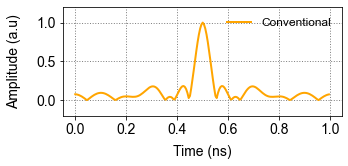

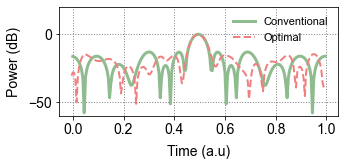

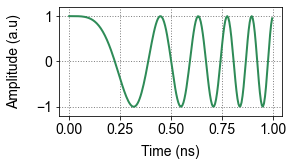

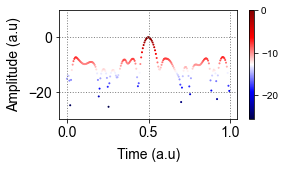

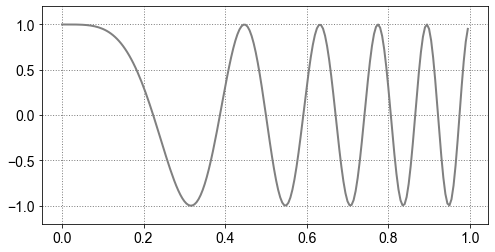

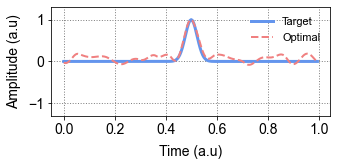

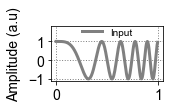

In [87]:
# 输出全局最优值和参数
print("全局最优结果：")
print(f"表达式: {global_best_expression}")
print(f"最小成本: {global_best_cost}")
print(f"最优参数: {global_best_params}")

# 绘图
fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression(global_best_expression)
plot_response(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, global_best_params,"C:\\Users\\user\\Desktop\\参数聚类工作推进\\Figure\\LFM\\2")

In [48]:
import time
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import chirp
from scipy.fft import fft, ifft, fftshift
from tqdm import tqdm

# 定义全局的最优变量
global_best_cost = float('inf')  # 初始设为正无穷
global_best_params = None
global_best_expression = None

# 配置参数
M_min = 1
M_max = 2
M = 2
a_min = -1
a_max = 1
tau_min = -1
tau_max = 1
t_min = 0
t_max = 1
g_min = 0
g_max = 1
T_min = 0
T_max = 1
a = 0.0001  # FIR阶数N
b = 1  # 理想响应比例
c = 1  # 惩罚比例
Gn = 5
Ne = 2
cxpb = 0.7
mutpb = 0.2
fs = 10000  # 采样频率
num_points = 1000  # 频率分辨率点数

# 假设 CSV 文件路径
input_csv_path = "C:\\Users\\user\\Desktop\\参数聚类工作推进\\Expression\\expressions.3.csv"  # 输入 CSV 文件
output_csv_path = "C:\\Users\\user\\Desktop\\参数聚类工作推进\\Results\\LFM.3.2.csv"

# 从 CSV 文件读取表达式
data = pd.read_csv(input_csv_path)

# 初始化结果列表
iteration_results = []

# 记录开始时间
start_time = time.time()
# 设定最大迭代次数和成本阈值
N_max = 1  # 可以根据需要调整最大迭代次数
cost_min = 1e-10  # 设置最低成本阈值

# 开始迭代过程
for iteration in range(N_max):
    print(f"Iteration {iteration + 1}/{N_max} starting...")



    # 参数设置
    A = 1                 # 信号振幅
    f0 = 0                # 起始频率（GHz）
    f1 = 10               # 结束频率（GHz）
    T = 1                  # 信号持续时间（秒）
    fs = 200               # 采样频率（Hz）

    # 时间向量
    t = np.arange(0, T, 1/fs)  # 从0到T，间隔为1/fs

    # 生成线性调频信号（chirp信号）
    signal = A * chirp(t, f0=f0, t1=T, f1=f1, method='linear')

    # 反转信号（用于脉压）
    r_signal = np.flip(signal)

    # 时域卷积脉压
    result_same = np.convolve(signal, r_signal, mode='same')

    # 计算信号的傅里叶变换
    N = len(signal)
    f = np.fft.fftfreq(N, d=1/fs)  # 频率向量
    #f = fftshift(f)  # 将频率从负到正移动
    signal_fft = fft(signal, N)  # 信号的傅里叶变换，长度为N
    r_signal_fft = fft(r_signal, N)  # 反转信号的傅里叶变换，长度为N

    # 频域相乘（脉压）
    H_result = signal_fft * r_signal_fft

    # 通过反傅里叶变换转换回时域
    Result = ifft(H_result)
    Result = fftshift(Result)  # 将频域移回中心
    Result = np.real(Result)

    # 定义高斯函数，用于拟合
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

    # 对脉压结果进行高斯拟合
    initial_guess = [np.max(result_same), t[np.argmax(result_same)], 0.1]
    popt, _ = curve_fit(gaussian, t, result_same, p0=initial_guess)

    # 拟合结果的参数
    A_fit, mu_fit, sigma_fit = popt

    # 生成拟合的高斯曲线
    gaussian_fit = gaussian(t, A_fit, mu_fit, 1*sigma_fit)

    H_w = gaussian_fit
    #H_w = result_same

    omega = 2*np.pi*1*f

    # 处理表达式
    fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression('FIR1')

    # 设计滤波器并计算最佳成本(GA)FIR1+FIR1*FIR2+FIR1*FIR2*FIR3+FIR1*FIR2*FIR3*FIR4+FIR1*FIR2*FIR3*FIR5+FIR1*FIR2*FIR4+FIR1*FIR2*FIR4*FIR5+FIR1*FIR3*FIR4+FIR1*FIR3*FIR4*FIR5+FIR1*FIR5+FIR2+FIR2*FIR3+FIR2*FIR3*FIR4+FIR2*FIR3*FIR5+FIR2*FIR5+FIR3*FIR5+FIR4*FIR5
    best_cost, best_params = fir_filter_design_with_GA_L_BFGS(
        a, b, c, H_w, omega, fir_filters, iir_drop_filters, iir_through_filters, a_min, a_max, tau_min, tau_max, t_min, t_max, g_min, g_max, T_min, T_max, M_min, M_max, Gn, Ne, cxpb, mutpb, numbered_expression
    )

    # 设计滤波器并计算最佳成本(GA+L-BFGS)
##################fir_filter_design_with_GA_L_BFGS
    # 设计滤波器并计算最佳成本(GA)
##################fir_filter_design_with_composite_cost

    # 更新全局最优值
    if best_cost < global_best_cost:
        global_best_cost = best_cost
        global_best_params = best_params
        global_best_expression = 'FIR1'

    # 将当前迭代的最优结果保存到列表
    iteration_results.append({
        'iteration': iteration + 1,
        'expression': 'FIR1',
        'best_cost': best_cost,
        'best_params': best_params
    })

    # 如果当前成本低于设定的最低阈值，则提前结束
    if global_best_cost < cost_min:
        print(f"Cost below threshold ({cost_min}) reached, stopping early.")
        break

    # 如果提前停止，则跳出外层迭代
    if global_best_cost < cost_min:
        break

    # 每次迭代结束时打印当前最优结果
    print(f"Iteration {iteration + 1} finished.")
    print(f"Current best cost: {global_best_cost}")
    print(f"Best parameters: {global_best_params}")
    print(f"Best expression: {global_best_expression}")

# 将每次迭代的最优结果保存为新的 CSV 文件
iteration_results_df = pd.DataFrame(iteration_results)
iteration_results_df.to_csv(output_csv_path, index=False)

# 输出全局最优值和参数
print("全局最优结果：")
print(f"表达式: {global_best_expression}")
print(f"最小成本: {global_best_cost}")
print(f"最优参数: {global_best_params}")

# 绘图
fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression(global_best_expression)
#plot_response(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, best_params)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Iteration 1/1 starting...
Optimized Coefficients for FIR1:
[-0.27891984]
Optimal Delays tau for FIR1:
[0.68135179]
Min-Cost: 2.13593687980927
Execution Time: 0.01 seconds
Iteration 1 finished.
Current best cost: 2.13593687980927
Best parameters: (array([-0.27891984]), array([0.68135179]))
Best expression: FIR1
全局最优结果：
表达式: FIR1
最小成本: 2.13593687980927
最优参数: (array([-0.27891984]), array([0.68135179]))
Elapsed time: 0.01 seconds


全局最优结果：
表达式: FIR1
最小成本: 2.13593687980927
最优参数: ([1], [0.5])


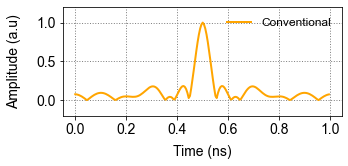

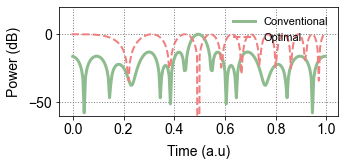

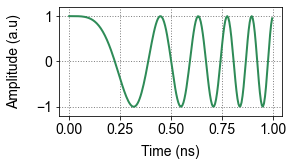

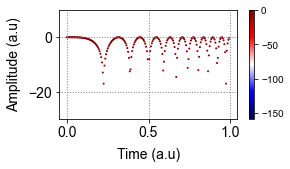

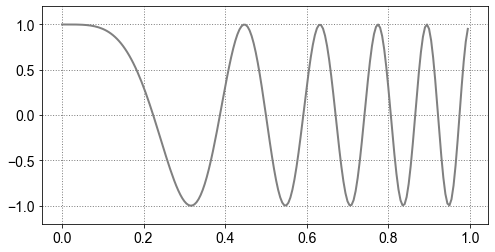

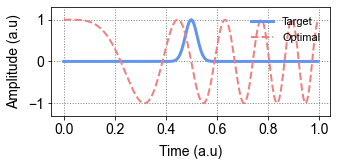

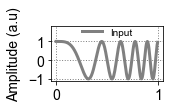

In [57]:
global_best_params = ([1], [0.5])
omega = 2*np.pi*1*f
# 输出全局最优值和参数
print("全局最优结果：")
print(f"表达式: {global_best_expression}")
print(f"最小成本: {global_best_cost}")
print(f"最优参数: {global_best_params}")

# 绘图
fir_filters, iir_drop_filters, iir_through_filters, numbered_expression = process_expression(global_best_expression)
plot_response(omega, H_w, fir_filters, iir_drop_filters, iir_through_filters, global_best_params,"C:\\Users\\user\\Desktop\\参数聚类工作推进\\Figure\\LFM\\3.0")